In [1]:
# !pip install tensorflow==2.10.0

# !pip install pandas-datareader==0.10.0

In [2]:
import math
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas_datareader as data_reader
import datetime

from tqdm import tqdm_notebook, tqdm
from collections import deque

In [3]:
print(data_reader.__version__)
print(tf.__version__)

0.10.0
2.10.0


In [4]:
class AI_Trader():
  
    def __init__(self, state_size, action_space=3, model_name="AITrader"):

        self.state_size = state_size
        self.action_space = action_space
        self.memory = deque(maxlen = 2000)
        self.inventory = []
        self.model = self.model_builder()
        self.model_name = self.model.name

        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_final = 0.01
        self.epsilon_decay = 0.995
  
    def model_builder(self):

        model = tf.keras.models.Sequential()
        model.add(tf.keras.layers.Dense(units=32, activation='relu', input_dim=self.state_size))
        model.add(tf.keras.layers.Dense(units=64, activation='relu'))
        model.add(tf.keras.layers.Dense(units=128, activation='relu'))
        model.add(tf.keras.layers.Dense(units=self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer="Adam")
        
        return model

    def trade(self, state):
        if random.random() <= self.epsilon:
            return random.randrange(self.action_space)
        act_values = self.model.predict(state)
        
        return np.argmax(act_values[0])
    
    def batch_train(self, batch_size):

        batch = []
        for i in range(len(self.memory) - batch_size + 1, len(self.memory)):
            batch.append(self.memory[i])

        for state, action, reward, next_state, done in batch:
            target = self.model.predict(state)

        if not done:
            target[0][action] = reward + self.gamma * np.amax(self.model.predict(next_state)[0])

        target[0][action] = reward

        self.model.fit(state, target, epochs=1, verbose=0)

        if self.epsilon > self.epsilon_final:
            self.epsilon *= self.epsilon_decay

In [5]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

In [6]:
def stocks_price_format(n):
    if n < 0:
        return "- $ {0:2f}".format(abs(n))
    else:
        return "$ {0:2f}".format(abs(n))

In [7]:
def dataset_loader(stock_name):

    dataset = data_reader.DataReader(stock_name, data_source="yahoo")

    start_date = str(dataset.index[0]).split()[0]
    end_date = str(dataset.index[1]).split()[0]

    close = dataset['Close']

    return close

In [8]:
def state_creator(data, timestep, window_size):
  
    starting_id = timestep - window_size + 1
    if starting_id >= 0:
        windowed_data = data[starting_id:timestep+1]
    else:
        windowed_data = abs(starting_id) * [data[0]] + list(data[0:timestep+1])
        
    state = []
    for i in range(window_size - 1):
        state.append(sigmoid(windowed_data[i+1] - windowed_data[i]))

    return np.array([state])

In [9]:
stock_name = "AAPL"
data = dataset_loader(stock_name).iloc[-50:]
data

Date
2022-09-06    154.529999
2022-09-07    155.960007
2022-09-08    154.460007
2022-09-09    157.369995
2022-09-12    163.429993
2022-09-13    153.839996
2022-09-14    155.309998
2022-09-15    152.369995
2022-09-16    150.699997
2022-09-19    154.479996
2022-09-20    156.899994
2022-09-21    153.720001
2022-09-22    152.740005
2022-09-23    150.429993
2022-09-26    150.770004
2022-09-27    151.759995
2022-09-28    149.839996
2022-09-29    142.479996
2022-09-30    138.199997
2022-10-03    142.449997
2022-10-04    146.100006
2022-10-05    146.399994
2022-10-06    145.429993
2022-10-07    140.089996
2022-10-10    140.419998
2022-10-11    138.979996
2022-10-12    138.339996
2022-10-13    142.990005
2022-10-14    138.380005
2022-10-17    142.410004
2022-10-18    143.750000
2022-10-19    143.860001
2022-10-20    143.389999
2022-10-21    147.270004
2022-10-24    149.449997
2022-10-25    152.339996
2022-10-26    149.350006
2022-10-27    144.800003
2022-10-28    155.740005
2022-10-31    153.33

In [10]:
window_size = 5
episodes = 100

batch_size = 8
data_samples = len(data) - 1

In [11]:
trader = AI_Trader(window_size)
trader.model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                192       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 3)                 387       
                                                                 
Total params: 11,011
Trainable params: 11,011
Non-trainable params: 0
_________________________________________________________________


In [12]:
total_pro = []
start_time = datetime.datetime.now()
for episode in range(1, episodes + 1):
  
    print("Episode: {}/{}".format(episode, episodes))

    state = state_creator(data, 10, window_size + 1)

    action = [0]
    total_profit = 0
    trader.inventory = []

    # for t in tqdm(range(data_samples)):
    for t in tqdm(range(window_size,data_samples)):
  
        action = trader.trade(state)

        next_state = state_creator(data, t+1, window_size + 1)
        reward = 0

        if action == 1: #Buying
            trader.inventory.append(data[t])
            print("AI Trader bought: ", stocks_price_format(data[t]))
      
        elif action == 2 and len(trader.inventory) > 0: #Selling
            buy_price = trader.inventory.pop(0)

            reward = max(data[t] - buy_price, 0)
            total_profit += data[t] - buy_price
            print("AI Trader sold: ", stocks_price_format(data[t]), " Profit: " + stocks_price_format(data[t] - buy_price) )

        if t == data_samples - 1:
            done = True
        else:
            done = False
      
        trader.memory.append((state, action, reward, next_state, done))

        state = next_state

        if done:
            print("########################")
            print("TOTAL PROFIT: {}".format(total_profit))
            print("########################")
            total_pro.append(total_profit)
        if len(trader.memory) > batch_size:
            trader.batch_train(batch_size)
      
    if episode % 10 == 0:
        trader.model.save("basic_ai_trader_{}.h5".format(episode))
end_time = datetime.datetime.now()
print("총 소요 시간: {}".format(end_time - start_time))

Episode: 1/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

AI Trader bought:  $ 152.369995
AI Trader bought:  $ 150.699997
AI Trader bought:  $ 154.479996
AI Trader sold:  $ 153.720001  Profit: $ 1.350006
1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:03<00:12,  2.73it/s]

AI Trader sold:  $ 150.770004  Profit: $ 0.070007
1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▋                                                               | 10/44 [00:04<00:17,  1.96it/s]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:06<00:21,  1.54it/s]

AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:07<00:26,  1.21it/s]

AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:09<00:29,  1.06it/s]

AI Trader sold:  $ 138.199997  Profit: - $ 16.279999
1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:10<00:31,  1.05s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.389999
1/1 [==============================] - 0s 56ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:33,  1.17s/it]

AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:13<00:36,  1.31s/it]

AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 54ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:15<00:37,  1.41s/it]

AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 57ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:16<00:37,  1.46s/it]

AI Trader sold:  $ 140.089996  Profit: - $ 6.309998
1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:18<00:36,  1.47s/it]

AI Trader sold:  $ 140.419998  Profit: - $ 5.009995
1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:19<00:34,  1.45s/it]

1/1 [==============================] - 0s 66ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:21<00:33,  1.46s/it]

AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:22<00:33,  1.50s/it]

AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:24<00:31,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:26<00:30,  1.52s/it]

AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:27<00:28,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:28<00:26,  1.49s/it]

1/1 [==============================] - 0s 54ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:30<00:26,  1.56s/it]

1/1 [==============================] - 0s 58ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:32<00:25,  1.57s/it]

AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 55ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:33<00:23,  1.58s/it]

AI Trader bought:  $ 149.449997
1/1 [==============================] - 0s 52ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:35<00:23,  1.71s/it]

AI Trader sold:  $ 152.339996  Profit: $ 14.000000
1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:37<00:22,  1.71s/it]

AI Trader sold:  $ 149.350006  Profit: $ 6.360001
1/1 [==============================] - 0s 61ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:39<00:19,  1.66s/it]

AI Trader sold:  $ 144.800003  Profit: $ 2.389999
1/1 [==============================] - 0s 50ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:40<00:18,  1.64s/it]

AI Trader bought:  $ 155.740005
1/1 [==============================] - 0s 46ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:42<00:17,  1.71s/it]

1/1 [==============================] - 0s 80ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:44<00:16,  1.80s/it]

AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:46<00:14,  1.80s/it]

1/1 [==============================] - 0s 51ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:47<00:11,  1.70s/it]

AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 83ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:49<00:10,  1.76s/it]

1/1 [==============================] - 0s 51ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:51<00:08,  1.74s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 8.350006
1/1 [==============================] - 0s 54ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:53<00:06,  1.73s/it]

AI Trader sold:  $ 139.500000  Profit: - $ 9.949997
1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:54<00:05,  1.74s/it]

1/1 [==============================] - 0s 86ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:56<00:03,  1.78s/it]

AI Trader bought:  $ 146.869995
1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:58<00:01,  1.79s/it]

AI Trader sold:  $ 149.699997  Profit: - $ 6.040009
########################
TOTAL PROFIT: -31.53997802734375
########################
1/1 [==============================] - 0s 53ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:00<00:00,  1.37s/it]


Episode: 2/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 50ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:06,  1.55s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:05,  1.55s/it]

AI Trader sold:  $ 152.369995  Profit: - $ 1.470001
1/1 [==============================] - 0s 51ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:02,  1.53s/it]

AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 53ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.50s/it]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.49s/it]

AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

AI Trader sold:  $ 153.720001  Profit: $ 3.020004
1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.54s/it]

AI Trader sold:  $ 152.740005  Profit: - $ 4.159988
1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:53,  1.49s/it]

1/1 [==============================] - 0s 54ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:57,  1.63s/it]

AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 63ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:57,  1.69s/it]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:53,  1.64s/it]

AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:50,  1.58s/it]

AI Trader sold:  $ 142.479996  Profit: - $ 8.290009
1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:47,  1.52s/it]

AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:44,  1.48s/it]

AI Trader sold:  $ 142.449997  Profit: - $ 7.389999
1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.46s/it]

AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:40,  1.44s/it]

AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:38,  1.42s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 145.429993  Profit: - $ 0.970001
1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.45s/it]

AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:34,  1.42s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 57ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.51s/it]

AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:32,  1.48s/it]

AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 43ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.42s/it]

1/1 [==============================] - 0s 51ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.46s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:25,  1.44s/it]

AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:24,  1.42s/it]

1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:24,  1.51s/it]

AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.47s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 149.449997  Profit: $ 5.589996
1/1 [==============================] - 0s 51ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.50s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 152.339996  Profit: $ 5.069992
1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.45s/it]

AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.46s/it]

AI Trader sold:  $ 139.500000  Profit: $ 1.119995
1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.44s/it]

AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.43s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 49ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.46s/it]

########################
TOTAL PROFIT: 15.6300048828125
########################
1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


Episode: 3/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:05,  1.53s/it]

1/1 [==============================] - 0s 43ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.51s/it]

AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.50s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 150.699997  Profit: - $ 1.669998
1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:05,  1.63s/it]

1/1 [==============================] - 0s 45ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:06,  1.70s/it]

AI Trader bought:  $ 156.899994
1/1 [==============================] - 0s 47ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:05,  1.72s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:00,  1.64s/it]

AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 38ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:56,  1.56s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 150.429993  Profit: - $ 6.470001
1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:56,  1.61s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 1.970001
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:54,  1.62s/it]

1/1 [==============================] - 0s 53ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:57,  1.74s/it]

AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 47ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:54,  1.69s/it]

AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:53,  1.73s/it]

1/1 [==============================] - 0s 56ms/step


 32%|██████████████████████████                                                        | 14/44 [00:23<00:51,  1.72s/it]

AI Trader sold:  $ 142.449997  Profit: - $ 7.389999
1/1 [==============================] - 0s 60ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:49,  1.72s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:26<00:47,  1.71s/it]

AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 69ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:28<00:45,  1.68s/it]

AI Trader sold:  $ 145.429993  Profit: - $ 0.970001
1/1 [==============================] - 0s 38ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:29<00:42,  1.62s/it]

1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:31<00:42,  1.68s/it]

1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:33<00:39,  1.65s/it]

1/1 [==============================] - 0s 47ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:35<00:39,  1.72s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:37<00:40,  1.86s/it]

AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 39ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:38<00:36,  1.74s/it]

AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:40<00:33,  1.65s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:41<00:30,  1.58s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 143.750000  Profit: $ 0.759995
1/1 [==============================] - 0s 41ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:43<00:28,  1.58s/it]

1/1 [==============================] - 0s 46ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:44<00:26,  1.53s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 143.389999  Profit: $ 5.009995
1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:46<00:24,  1.55s/it]

AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:47<00:22,  1.50s/it]

AI Trader sold:  $ 149.449997  Profit: $ 2.179993
1/1 [==============================] - 0s 50ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:48<00:20,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:50<00:19,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:51<00:17,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:53<00:16,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:54<00:15,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:56<00:13,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:57<00:12,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:59<00:10,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:01<00:09,  1.53s/it]

AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 47ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:02<00:07,  1.49s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.539993
1/1 [==============================] - 0s 53ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:04<00:06,  1.54s/it]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:05<00:04,  1.57s/it]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:07<00:03,  1.65s/it]

1/1 [==============================] - 0s 52ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:08<00:01,  1.58s/it]

1/1 [==============================] - 0s 39ms/step
########################
TOTAL PROFIT: -6.360015869140625
########################
1/1 [==============================] - 0s 47ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:10<00:00,  1.60s/it]


Episode: 4/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.42s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.52s/it]

1/1 [==============================] - 0s 51ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.49s/it]

1/1 [==============================] - 0s 45ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:58,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.50s/it]

AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 49ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.47s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 49ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.50s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 1.970001
1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.52s/it]

AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 55ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.54s/it]

1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:50,  1.57s/it]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:48,  1.56s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 39ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:46,  1.55s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:45,  1.56s/it]

AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:43,  1.55s/it]

AI Trader sold:  $ 146.399994  Profit: $ 0.299988
1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:41,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:42,  1.63s/it]

1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:40,  1.61s/it]

1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:39,  1.63s/it]

1/1 [==============================] - 0s 47ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:37,  1.62s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:35,  1.60s/it]

AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:32,  1.55s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 4.610001
1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:31,  1.56s/it]

1/1 [==============================] - 0s 48ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:29,  1.57s/it]

1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:28,  1.57s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:26,  1.54s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:43<00:23,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:22,  1.59s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:20,  1.54s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:49<00:18,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.54s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 155.740005
1/1 [==============================] - 0s 47ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:15,  1.54s/it]

AI Trader bought:  $ 153.339996
1/1 [==============================] - 0s 54ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:12,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:57<00:11,  1.63s/it]

1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:58<00:09,  1.56s/it]

AI Trader sold:  $ 138.380005  Profit: - $ 17.360001
1/1 [==============================] - 0s 46ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:00<00:07,  1.52s/it]

AI Trader sold:  $ 138.919998  Profit: - $ 14.419998
1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:01<00:05,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:03<00:04,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:04<00:03,  1.53s/it]

1/1 [==============================] - 0s 38ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:06<00:01,  1.48s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: -31.010009765625
########################
1/1 [==============================] - 0s 51ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:07<00:00,  1.54s/it]


Episode: 5/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.42s/it]

1/1 [==============================] - 0s 51ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:05,  1.56s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:04,  1.57s/it]

1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:58,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:57,  1.55s/it]

AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:52,  1.55s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 64ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:57,  1.74s/it]

1/1 [==============================] - 0s 52ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:54,  1.70s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:50,  1.64s/it]

1/1 [==============================] - 0s 59ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:49,  1.66s/it]

1/1 [==============================] - 0s 46ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:48,  1.66s/it]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:46,  1.68s/it]

AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 44ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:27<00:44,  1.65s/it]

1/1 [==============================] - 0s 51ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:29<00:43,  1.69s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:44,  1.77s/it]

AI Trader sold:  $ 140.419998  Profit: - $ 5.979996
1/1 [==============================] - 0s 39ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:32<00:41,  1.73s/it]

1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:34<00:37,  1.65s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:36<00:40,  1.82s/it]

1/1 [==============================] - 0s 49ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:38<00:39,  1.87s/it]

1/1 [==============================] - 0s 52ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:40<00:37,  1.85s/it]

AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 62ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:41<00:34,  1.79s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:43<00:30,  1.71s/it]

1/1 [==============================] - 0s 48ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:44<00:28,  1.66s/it]

AI Trader sold:  $ 143.389999  Profit: $ 0.979996
1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:46<00:25,  1.58s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:47<00:23,  1.58s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 149.449997  Profit: $ 5.699997
1/1 [==============================] - 0s 53ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:50<00:25,  1.79s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 152.339996  Profit: $ 5.069992
1/1 [==============================] - 0s 47ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:51<00:23,  1.78s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:53<00:21,  1.75s/it]

1/1 [==============================] - 0s 61ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:55<00:19,  1.78s/it]

AI Trader bought:  $ 155.740005
1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:56<00:17,  1.71s/it]

1/1 [==============================] - 0s 51ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:58<00:15,  1.71s/it]

AI Trader sold:  $ 150.649994  Profit: $ 1.299988
1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:00<00:13,  1.68s/it]

AI Trader sold:  $ 145.029999  Profit: - $ 10.710007
1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:01<00:11,  1.67s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 50ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:03<00:09,  1.65s/it]

AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:04<00:07,  1.60s/it]

1/1 [==============================] - 0s 64ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:06<00:06,  1.70s/it]

AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:08<00:05,  1.68s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 134.869995  Profit: - $ 4.630005
1/1 [==============================] - 0s 49ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:10<00:03,  1.72s/it]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:12<00:01,  1.71s/it]

########################
TOTAL PROFIT: -9.750045776367188
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:13<00:00,  1.67s/it]


Episode: 6/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:08,  1.60s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:08,  1.64s/it]

1/1 [==============================] - 0s 43ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:05,  1.60s/it]

1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:03,  1.59s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:01,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:03,  1.68s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:01,  1.66s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:13<00:59,  1.64s/it]

1/1 [==============================] - 0s 49ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:57,  1.66s/it]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:55,  1.64s/it]

1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:53,  1.63s/it]

1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:51,  1.62s/it]

AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:48,  1.57s/it]

1/1 [==============================] - 0s 54ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:46,  1.56s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 0.029999
1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:44,  1.55s/it]

1/1 [==============================] - 0s 58ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:43,  1.56s/it]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:27<00:42,  1.59s/it]

1/1 [==============================] - 0s 53ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:41,  1.60s/it]

1/1 [==============================] - 0s 42ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:39,  1.57s/it]

1/1 [==============================] - 0s 47ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:36,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:33<00:35,  1.52s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:33,  1.53s/it]

1/1 [==============================] - 0s 50ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:36<00:32,  1.56s/it]

1/1 [==============================] - 0s 44ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:38<00:31,  1.56s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:39<00:31,  1.64s/it]

1/1 [==============================] - 0s 48ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:41<00:29,  1.63s/it]

AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 47ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:43<00:27,  1.63s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 143.389999  Profit: - $ 0.470001
1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:44<00:26,  1.64s/it]

AI Trader bought:  $ 147.270004
1/1 [==============================] - 0s 57ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:46<00:24,  1.60s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 149.449997  Profit: $ 2.179993
1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:47<00:22,  1.58s/it]

AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 39ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:49<00:20,  1.54s/it]

1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:50<00:17,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:52<00:17,  1.55s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:53<00:15,  1.54s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 153.339996  Profit: $ 1.000000
1/1 [==============================] - 0s 52ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:55<00:14,  1.57s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:57<00:12,  1.55s/it]

1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:58<00:11,  1.60s/it]

1/1 [==============================] - 0s 59ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:00<00:09,  1.59s/it]

1/1 [==============================] - 0s 63ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:02<00:08,  1.65s/it]

1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:03<00:06,  1.65s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:05<00:04,  1.63s/it]

1/1 [==============================] - 0s 45ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:07<00:03,  1.78s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:09<00:01,  1.72s/it]

1/1 [==============================] - 0s 41ms/step
########################
TOTAL PROFIT: 2.67999267578125
########################
1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:10<00:00,  1.60s/it]


Episode: 7/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:08,  1.59s/it]

AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:02,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:03,  1.56s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 150.699997  Profit: - $ 4.610001
1/1 [==============================] - 0s 52ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:02,  1.57s/it]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.52s/it]

1/1 [==============================] - 0s 44ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:57,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.55s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:54,  1.56s/it]

AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:52,  1.53s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.55s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:48,  1.55s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:46,  1.56s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 0.029999
1/1 [==============================] - 0s 47ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:45,  1.57s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:43,  1.57s/it]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:42,  1.58s/it]

1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:44,  1.72s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 47ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:41,  1.67s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 40ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:39,  1.64s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.110001
1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:33<00:37,  1.62s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 138.339996  Profit: - $ 2.080002
1/1 [==============================] - 0s 40ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:35,  1.59s/it]

1/1 [==============================] - 0s 55ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:36<00:32,  1.57s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:32,  1.63s/it]

1/1 [==============================] - 0s 58ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:39<00:31,  1.68s/it]

1/1 [==============================] - 0s 81ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:41<00:29,  1.66s/it]

1/1 [==============================] - 0s 51ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:43<00:28,  1.68s/it]

1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:44<00:25,  1.62s/it]

1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:46<00:25,  1.73s/it]

1/1 [==============================] - 0s 68ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:48<00:24,  1.73s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:50<00:22,  1.74s/it]

1/1 [==============================] - 0s 73ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:52<00:21,  1.82s/it]

1/1 [==============================] - 0s 61ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:54<00:20,  1.87s/it]

1/1 [==============================] - 0s 60ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:55<00:18,  1.89s/it]

1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:57<00:16,  1.81s/it]

AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 85ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:59<00:14,  1.76s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:01<00:13,  1.87s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:02<00:10,  1.75s/it]

1/1 [==============================] - 0s 71ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 47ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:04<00:08,  1.68s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:05<00:06,  1.62s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:07<00:04,  1.58s/it]

1/1 [==============================] - 0s 49ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:08<00:03,  1.55s/it]

1/1 [==============================] - 0s 60ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:10<00:01,  1.50s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL PROFIT: -16.699996948242188
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:11<00:00,  1.63s/it]


Episode: 8/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.49s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 44ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 40ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.44s/it]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.47s/it]

1/1 [==============================] - 0s 56ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:51,  1.60s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:48,  1.56s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:46,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.46s/it]

AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:35,  1.42s/it]

1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.43s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.110001
1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.45s/it]

1/1 [==============================] - 0s 59ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.49s/it]

AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.48s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 59ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:28,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:22,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:23,  1.54s/it]

1/1 [==============================] - 0s 47ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:21,  1.52s/it]

AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.45s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 149.350006  Profit: - $ 2.989990
1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.47s/it]

1/1 [==============================] - 0s 64ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:16,  1.62s/it]

1/1 [==============================] - 0s 57ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:14,  1.62s/it]

1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:13,  1.66s/it]

1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:12,  1.74s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:10,  1.68s/it]

AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.58s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 63ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.62s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader sold:  $ 139.500000  Profit: $ 1.119995
1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:05,  1.67s/it]

1/1 [==============================] - 0s 61ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:04<00:03,  1.67s/it]

1/1 [==============================] - 0s 48ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.74s/it]

1/1 [==============================] - 0s 50ms/step
########################
TOTAL PROFIT: 7.2899932861328125
########################
1/1 [==============================] - 0s 51ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:07<00:00,  1.53s/it]


Episode: 9/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:08,  1.60s/it]

1/1 [==============================] - 0s 43ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:15,  1.80s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:10,  1.73s/it]

1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:06,  1.67s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 63ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:09,  1.79s/it]

AI Trader sold:  $ 156.899994  Profit: $ 2.419998
1/1 [==============================] - 0s 39ms/step


 14%|███████████▎                                                                       | 6/44 [00:10<01:02,  1.64s/it]

1/1 [==============================] - 0s 51ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:59,  1.62s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 57ms/step


 18%|███████████████                                                                    | 8/44 [00:13<00:59,  1.64s/it]

1/1 [==============================] - 0s 61ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<00:59,  1.71s/it]

1/1 [==============================] - 0s 48ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:54,  1.61s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 51ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:52,  1.58s/it]

1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:49,  1.54s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:46,  1.51s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:45,  1.53s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 0.029999
1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:44,  1.52s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 60ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:42,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:27<00:41,  1.53s/it]

1/1 [==============================] - 0s 46ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:41,  1.59s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:39,  1.57s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:36,  1.53s/it]

AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 43ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:33<00:33,  1.46s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.339996  Profit: - $ 1.750000
1/1 [==============================] - 0s 39ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:32,  1.46s/it]

AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 49ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:29,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:29,  1.47s/it]

1/1 [==============================] - 0s 54ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.48s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 143.750000  Profit: $ 3.330002
1/1 [==============================] - 0s 63ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:28,  1.56s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 143.860001  Profit: $ 4.880005
1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:42<00:28,  1.65s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader sold:  $ 143.389999  Profit: $ 0.399994
1/1 [==============================] - 0s 85ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:44<00:26,  1.67s/it]

1/1 [==============================] - 0s 101ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:46<00:27,  1.84s/it]

1/1 [==============================] - 0s 50ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:48<00:25,  1.85s/it]

1/1 [==============================] - 0s 51ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:50<00:23,  1.82s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:51<00:20,  1.75s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:53<00:18,  1.71s/it]

1/1 [==============================] - 0s 46ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:55<00:16,  1.69s/it]

1/1 [==============================] - 0s 47ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:56<00:15,  1.68s/it]

1/1 [==============================] - 0s 46ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:58<00:13,  1.67s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 53ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:59<00:11,  1.66s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 138.880005  Profit: - $ 6.149994
1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:01<00:09,  1.63s/it]

1/1 [==============================] - 0s 60ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:03<00:08,  1.66s/it]

1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:05<00:06,  1.69s/it]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:06<00:04,  1.62s/it]

1/1 [==============================] - 0s 61ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:07<00:03,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:09<00:01,  1.63s/it]

AI Trader bought:  $ 149.699997
########################
TOTAL PROFIT: 10.020004272460938
########################
1/1 [==============================] - 0s 44ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:11<00:00,  1.62s/it]


Episode: 10/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:06,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:07,  1.61s/it]

1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:03,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:06<00:59,  1.48s/it]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.54s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 65ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.53s/it]

AI Trader sold:  $ 150.429993  Profit: - $ 2.310013
1/1 [==============================] - 0s 52ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:53,  1.52s/it]

1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:56,  1.65s/it]

1/1 [==============================] - 0s 56ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:53,  1.63s/it]

1/1 [==============================] - 0s 80ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:52,  1.65s/it]

1/1 [==============================] - 0s 169ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:54,  1.77s/it]

1/1 [==============================] - 0s 70ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 59ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:53,  1.79s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 0.029999
1/1 [==============================] - 0s 59ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:52,  1.81s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 59ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:26<00:50,  1.81s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:28<00:51,  1.92s/it]

1/1 [==============================] - 0s 41ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:30<00:46,  1.81s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:31<00:43,  1.76s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 47ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:33<00:40,  1.70s/it]

1/1 [==============================] - 0s 48ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:34<00:38,  1.67s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:36<00:36,  1.64s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:38<00:33,  1.62s/it]

1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:39<00:32,  1.61s/it]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:41<00:30,  1.60s/it]

1/1 [==============================] - 0s 59ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:42<00:28,  1.59s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:44<00:27,  1.60s/it]

1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:46<00:25,  1.60s/it]

1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:47<00:24,  1.63s/it]

1/1 [==============================] - 0s 50ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:49<00:22,  1.61s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:50<00:20,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:52<00:19,  1.59s/it]

1/1 [==============================] - 0s 50ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:54<00:17,  1.58s/it]

1/1 [==============================] - 0s 41ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:55<00:15,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:56<00:13,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:58<00:13,  1.64s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:00<00:11,  1.61s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 40ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:02<00:09,  1.61s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 6.649994
1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:03<00:08,  1.62s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 66ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:05<00:06,  1.67s/it]

1/1 [==============================] - 0s 62ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:07<00:05,  1.72s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 67ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:09<00:03,  1.78s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 146.869995
1/1 [==============================] - 0s 70ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:11<00:01,  1.84s/it]

1/1 [==============================] - 0s 71ms/step
AI Trader sold:  $ 149.699997  Profit: $ 14.830002
########################
TOTAL PROFIT: 14.110000610351562
########################
1/1 [==============================] - 0s 45ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:12<00:00,  1.66s/it]


Episode: 11/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:12,  1.68s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:19,  1.90s/it]

1/1 [==============================] - 0s 125ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:18,  1.91s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 150.699997  Profit: - $ 4.610001
1/1 [==============================] - 0s 49ms/step


  9%|███████▌                                                                           | 4/44 [00:07<01:11,  1.78s/it]

1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:07,  1.72s/it]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:10<01:03,  1.68s/it]

1/1 [==============================] - 0s 67ms/step


 16%|█████████████▏                                                                     | 7/44 [00:12<01:04,  1.75s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:14<01:02,  1.74s/it]

1/1 [==============================] - 0s 55ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<01:02,  1.77s/it]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:17<00:58,  1.72s/it]

1/1 [==============================] - 0s 52ms/step


 25%|████████████████████▌                                                             | 11/44 [00:19<00:57,  1.76s/it]

1/1 [==============================] - 0s 46ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:20<00:54,  1.71s/it]

1/1 [==============================] - 0s 49ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:22<00:50,  1.63s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:24<00:48,  1.63s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.449997  Profit: $ 4.250000
1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:25<00:47,  1.63s/it]

1/1 [==============================] - 0s 45ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:27<00:46,  1.64s/it]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:29<00:44,  1.65s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:30<00:41,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:32<00:40,  1.63s/it]

1/1 [==============================] - 0s 59ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:33<00:39,  1.64s/it]

1/1 [==============================] - 0s 57ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:35<00:37,  1.64s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:37<00:37,  1.69s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:38<00:34,  1.66s/it]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:40<00:32,  1.64s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:42<00:30,  1.63s/it]

1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:43<00:29,  1.63s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:45<00:27,  1.62s/it]

AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:46<00:25,  1.60s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 52ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:48<00:24,  1.60s/it]

1/1 [==============================] - 0s 45ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:50<00:23,  1.70s/it]

1/1 [==============================] - 0s 53ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:52<00:22,  1.70s/it]

1/1 [==============================] - 0s 48ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:53<00:20,  1.74s/it]

1/1 [==============================] - 0s 56ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:55<00:18,  1.71s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:57<00:16,  1.69s/it]

1/1 [==============================] - 0s 57ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:58<00:14,  1.66s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:00<00:13,  1.68s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:02<00:11,  1.67s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 138.880005  Profit: - $ 6.149994
1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:03<00:10,  1.69s/it]

1/1 [==============================] - 0s 42ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:05<00:08,  1.66s/it]

1/1 [==============================] - 0s 51ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:07<00:06,  1.68s/it]

1/1 [==============================] - 0s 51ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:08<00:04,  1.66s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:10<00:03,  1.63s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:12<00:01,  1.64s/it]

1/1 [==============================] - 0s 40ms/step
########################
TOTAL PROFIT: 9.370010375976562
########################
1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:13<00:00,  1.67s/it]


Episode: 12/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:09,  1.62s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:08,  1.62s/it]

1/1 [==============================] - 0s 51ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:10,  1.73s/it]

1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:07,  1.68s/it]

1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:04,  1.65s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:03,  1.66s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:02,  1.70s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:13<01:02,  1.75s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<00:59,  1.70s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:57,  1.70s/it]

1/1 [==============================] - 0s 51ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:56,  1.70s/it]

1/1 [==============================] - 0s 51ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:20<00:53,  1.67s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 58ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:51,  1.66s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 138.199997  Profit: - $ 4.279999
1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:23<00:49,  1.65s/it]

1/1 [==============================] - 0s 46ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:25<00:48,  1.68s/it]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:26<00:46,  1.67s/it]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:28<00:44,  1.64s/it]

1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:30<00:42,  1.64s/it]

AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 39ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:31<00:40,  1.60s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 140.419998  Profit: $ 0.330002
1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:33<00:38,  1.62s/it]

1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:34<00:37,  1.61s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:36<00:37,  1.71s/it]

1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:38<00:35,  1.68s/it]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:40<00:33,  1.68s/it]

1/1 [==============================] - 0s 49ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:41<00:31,  1.66s/it]

1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:43<00:28,  1.60s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:44<00:27,  1.60s/it]

1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:46<00:25,  1.62s/it]

1/1 [==============================] - 0s 60ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:48<00:24,  1.62s/it]

1/1 [==============================] - 0s 47ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:49<00:22,  1.62s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:51<00:21,  1.65s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 47ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:53<00:19,  1.65s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 53ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:54<00:18,  1.65s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 47ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:56<00:16,  1.68s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:58<00:14,  1.66s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:59<00:13,  1.66s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:01<00:11,  1.65s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.880005  Profit: - $ 11.769989
1/1 [==============================] - 0s 40ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:02<00:09,  1.64s/it]

AI Trader sold:  $ 138.380005  Profit: - $ 6.649994
1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:04<00:07,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:05<00:06,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:07<00:05,  1.67s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 51ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:09<00:03,  1.65s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 51ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:11<00:01,  1.66s/it]

1/1 [==============================] - 0s 59ms/step
########################
TOTAL PROFIT: 4.5600128173828125
########################
1/1 [==============================] - 0s 58ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:12<00:00,  1.65s/it]


Episode: 13/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:20,  1.88s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:13,  1.76s/it]

AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 51ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:06,  1.63s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 150.699997  Profit: - $ 1.669998
1/1 [==============================] - 0s 43ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:04,  1.62s/it]

1/1 [==============================] - 0s 48ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:00,  1.56s/it]

1/1 [==============================] - 0s 47ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:00,  1.59s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 56ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:59,  1.62s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 152.740005  Profit: - $ 0.979996
1/1 [==============================] - 0s 54ms/step


 18%|███████████████                                                                    | 8/44 [00:13<00:59,  1.65s/it]

1/1 [==============================] - 0s 45ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:57,  1.64s/it]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:55,  1.62s/it]

1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:53,  1.62s/it]

1/1 [==============================] - 0s 58ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:51,  1.62s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:48,  1.56s/it]

1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:46,  1.54s/it]

1/1 [==============================] - 0s 47ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:45,  1.56s/it]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:26<00:47,  1.68s/it]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:27<00:43,  1.60s/it]

1/1 [==============================] - 0s 48ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:29<00:41,  1.60s/it]

1/1 [==============================] - 0s 47ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:39,  1.60s/it]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:32<00:38,  1.61s/it]

1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:33<00:36,  1.61s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:35<00:35,  1.62s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:37<00:34,  1.62s/it]

1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:38<00:32,  1.61s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:40<00:30,  1.60s/it]

1/1 [==============================] - 0s 51ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:41<00:28,  1.60s/it]

1/1 [==============================] - 0s 47ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:43<00:27,  1.62s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:45<00:26,  1.63s/it]

1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:46<00:24,  1.64s/it]

1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:48<00:22,  1.63s/it]

1/1 [==============================] - 0s 60ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:50<00:21,  1.63s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 51ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:51<00:19,  1.61s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 46ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:53<00:18,  1.70s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 39ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:55<00:16,  1.66s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:56<00:14,  1.65s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:58<00:13,  1.63s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 51ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:00<00:11,  1.63s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.880005  Profit: - $ 11.769989
1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:01<00:09,  1.63s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 6.649994
1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:03<00:08,  1.63s/it]

1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:04<00:06,  1.62s/it]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:06<00:04,  1.63s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 49ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:08<00:03,  1.64s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 50ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:09<00:01,  1.63s/it]

1/1 [==============================] - 0s 49ms/step
########################
TOTAL PROFIT: 5.860015869140625
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:11<00:00,  1.62s/it]


Episode: 14/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:17,  1.80s/it]

1/1 [==============================] - 0s 61ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:22,  1.96s/it]

1/1 [==============================] - 0s 65ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:21,  1.99s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:07<01:12,  1.82s/it]

AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 72ms/step


 11%|█████████▍                                                                         | 5/44 [00:09<01:07,  1.73s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 156.899994  Profit: $ 2.419998
1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:10<01:03,  1.67s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 50ms/step


 16%|█████████████▏                                                                     | 7/44 [00:12<01:00,  1.64s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader sold:  $ 152.740005  Profit: - $ 0.979996
1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:13<01:01,  1.70s/it]

1/1 [==============================] - 0s 52ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<00:55,  1.59s/it]

1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:53,  1.56s/it]

1/1 [==============================] - 0s 48ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:51,  1.55s/it]

1/1 [==============================] - 0s 38ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:49,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:49,  1.59s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:23<00:47,  1.57s/it]

1/1 [==============================] - 0s 59ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:45,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:26<00:43,  1.56s/it]

1/1 [==============================] - 0s 66ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:28<00:44,  1.63s/it]

1/1 [==============================] - 0s 69ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:30<00:47,  1.82s/it]

1/1 [==============================] - 0s 68ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:32<00:48,  1.94s/it]

1/1 [==============================] - 0s 76ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:34<00:49,  2.08s/it]

1/1 [==============================] - 0s 71ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:37<00:48,  2.09s/it]

1/1 [==============================] - 0s 69ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:39<00:48,  2.20s/it]

1/1 [==============================] - 0s 76ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:42<00:48,  2.32s/it]

1/1 [==============================] - 0s 78ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:44<00:46,  2.32s/it]

1/1 [==============================] - 0s 65ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:46<00:42,  2.25s/it]

1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:47<00:36,  2.02s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:50<00:35,  2.06s/it]

1/1 [==============================] - 0s 59ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:51<00:31,  1.99s/it]

1/1 [==============================] - 0s 56ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:53<00:30,  2.00s/it]

1/1 [==============================] - 0s 51ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:55<00:26,  1.93s/it]

1/1 [==============================] - 0s 93ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:58<00:26,  2.04s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 63ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [01:00<00:25,  2.11s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 67ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:02<00:22,  2.08s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 63ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:04<00:20,  2.01s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 39ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:06<00:18,  2.01s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 62ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:07<00:15,  1.93s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 58ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:09<00:13,  1.86s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 138.880005  Profit: - $ 11.769989
1/1 [==============================] - 0s 63ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:11<00:11,  1.93s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 6.649994
1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:13<00:09,  1.91s/it]

1/1 [==============================] - 0s 47ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:15<00:07,  1.78s/it]

1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:16<00:05,  1.76s/it]

AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 61ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:18<00:03,  1.73s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 57ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:20<00:01,  1.73s/it]

1/1 [==============================] - 0s 46ms/step
########################
TOTAL PROFIT: 9.95001220703125
########################
1/1 [==============================] - 0s 55ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:22<00:00,  1.86s/it]


Episode: 15/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:21,  1.89s/it]

1/1 [==============================] - 0s 51ms/step


  5%|███▊                                                                               | 2/44 [00:04<01:26,  2.06s/it]

1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:18,  1.91s/it]

1/1 [==============================] - 0s 49ms/step


  9%|███████▌                                                                           | 4/44 [00:07<01:13,  1.85s/it]

1/1 [==============================] - 0s 46ms/step


 11%|█████████▍                                                                         | 5/44 [00:09<01:12,  1.87s/it]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:11<01:09,  1.82s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 73ms/step


 16%|█████████████▏                                                                     | 7/44 [00:13<01:11,  1.93s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 152.740005  Profit: - $ 0.979996
1/1 [==============================] - 0s 52ms/step


 18%|███████████████                                                                    | 8/44 [00:15<01:08,  1.91s/it]

1/1 [==============================] - 0s 65ms/step


 20%|████████████████▉                                                                  | 9/44 [00:17<01:11,  2.04s/it]

1/1 [==============================] - 0s 77ms/step


 23%|██████████████████▋                                                               | 10/44 [00:19<01:11,  2.10s/it]

1/1 [==============================] - 0s 51ms/step


 25%|████████████████████▌                                                             | 11/44 [00:21<01:06,  2.03s/it]

1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:23<01:03,  1.98s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:25<01:01,  1.98s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.199997  Profit: - $ 4.279999
1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:27<00:57,  1.90s/it]

1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:29<00:54,  1.89s/it]

1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:30<00:51,  1.85s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:32<00:50,  1.86s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:34<00:45,  1.76s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 140.089996  Profit: - $ 5.339996
1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:36<00:44,  1.77s/it]

1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:37<00:40,  1.69s/it]

1/1 [==============================] - 0s 51ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:39<00:37,  1.63s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:40<00:35,  1.60s/it]

1/1 [==============================] - 0s 42ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:42<00:32,  1.56s/it]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:43<00:32,  1.62s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:45<00:30,  1.60s/it]

1/1 [==============================] - 0s 46ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:46<00:28,  1.60s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:48<00:26,  1.58s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:50<00:24,  1.56s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:51<00:24,  1.62s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:53<00:22,  1.59s/it]

1/1 [==============================] - 0s 45ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:54<00:20,  1.56s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:56<00:18,  1.55s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:57<00:16,  1.53s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 48ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:59<00:15,  1.53s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 47ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:00<00:13,  1.52s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:02<00:12,  1.51s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 51ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:03<00:10,  1.53s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 138.880005  Profit: - $ 11.769989
1/1 [==============================] - 0s 49ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:05<00:09,  1.64s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 6.649994
1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:07<00:07,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:08<00:06,  1.57s/it]

1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:10<00:04,  1.54s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 41ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:11<00:03,  1.53s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 48ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:13<00:01,  1.52s/it]

1/1 [==============================] - 0s 50ms/step
########################
TOTAL PROFIT: 1.7900238037109375
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:14<00:00,  1.70s/it]


Episode: 16/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:08,  1.64s/it]

1/1 [==============================] - 0s 81ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:13,  1.80s/it]

1/1 [==============================] - 0s 84ms/step


  9%|███████▌                                                                           | 4/44 [00:07<01:25,  2.14s/it]

1/1 [==============================] - 0s 51ms/step


 11%|█████████▍                                                                         | 5/44 [00:09<01:22,  2.11s/it]

1/1 [==============================] - 0s 48ms/step


 14%|███████████▎                                                                       | 6/44 [00:12<01:22,  2.18s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 53ms/step


 16%|█████████████▏                                                                     | 7/44 [00:14<01:21,  2.21s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 152.740005  Profit: - $ 0.979996
1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:16<01:14,  2.08s/it]

1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:18<01:13,  2.11s/it]

1/1 [==============================] - 0s 88ms/step


 23%|██████████████████▋                                                               | 10/44 [00:21<01:19,  2.33s/it]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:23<01:12,  2.20s/it]

1/1 [==============================] - 0s 47ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:25<01:12,  2.26s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 57ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:27<01:10,  2.27s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:29<01:05,  2.17s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 0.029999
1/1 [==============================] - 0s 90ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:31<01:02,  2.15s/it]

1/1 [==============================] - 0s 92ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 56ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:34<01:03,  2.27s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 68ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:36<00:59,  2.20s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 55ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:38<00:54,  2.10s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 140.089996  Profit: - $ 6.309998
1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:40<00:49,  1.98s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 5.009995
1/1 [==============================] - 0s 53ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:41<00:44,  1.86s/it]

1/1 [==============================] - 0s 56ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:43<00:42,  1.83s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:45<00:39,  1.78s/it]

1/1 [==============================] - 0s 70ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:47<00:39,  1.89s/it]

1/1 [==============================] - 0s 58ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:49<00:39,  1.96s/it]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:51<00:36,  1.91s/it]

1/1 [==============================] - 0s 52ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:52<00:33,  1.88s/it]

1/1 [==============================] - 0s 64ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:54<00:32,  1.89s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 57ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:56<00:31,  1.95s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 58ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:59<00:29,  2.00s/it]

1/1 [==============================] - 0s 50ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [01:01<00:27,  1.99s/it]

1/1 [==============================] - 0s 47ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [01:03<00:27,  2.13s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [01:05<00:24,  2.01s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 50ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:06<00:20,  1.86s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 91ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:08<00:17,  1.79s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:09<00:15,  1.72s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:11<00:13,  1.71s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 72ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:13<00:11,  1.70s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader sold:  $ 138.880005  Profit: - $ 11.769989
1/1 [==============================] - 0s 51ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:14<00:10,  1.69s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 6.649994
1/1 [==============================] - 0s 51ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:16<00:08,  1.68s/it]

1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:18<00:06,  1.68s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:19<00:04,  1.67s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 68ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:22<00:03,  1.83s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:23<00:01,  1.76s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: 7.9600372314453125
########################
1/1 [==============================] - 0s 45ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:25<00:00,  1.94s/it]


Episode: 17/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:09,  1.62s/it]

1/1 [==============================] - 0s 53ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:11,  1.70s/it]

1/1 [==============================] - 0s 49ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:05,  1.61s/it]

1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:07,  1.68s/it]

1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:02,  1.61s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:00,  1.58s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:57,  1.56s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 51ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.55s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 150.429993  Profit: - $ 3.290009
1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:54,  1.55s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 1.970001
1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:52,  1.54s/it]

1/1 [==============================] - 0s 40ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:50,  1.52s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.52s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 49ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:47,  1.52s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.51s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.389999
1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:44,  1.53s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 45ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:40,  1.51s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 54ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:40,  1.55s/it]

AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:37,  1.49s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 140.419998  Profit: $ 2.220001
1/1 [==============================] - 0s 53ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.51s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 7.419998
1/1 [==============================] - 0s 40ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:35,  1.54s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.339996  Profit: - $ 7.089996
1/1 [==============================] - 0s 53ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:33,  1.54s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.900009
1/1 [==============================] - 0s 47ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:34,  1.62s/it]

1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:31,  1.58s/it]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:39<00:31,  1.66s/it]

1/1 [==============================] - 0s 46ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:30,  1.67s/it]

1/1 [==============================] - 0s 54ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:42<00:27,  1.63s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 58ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:44<00:26,  1.63s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 51ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:45<00:24,  1.64s/it]

1/1 [==============================] - 0s 66ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:47<00:25,  1.79s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:49<00:22,  1.76s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 98ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:51<00:20,  1.74s/it]

1/1 [==============================] - 0s 66ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:52<00:18,  1.70s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 52ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:54<00:17,  1.71s/it]

1/1 [==============================] - 0s 56ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:56<00:16,  1.79s/it]

1/1 [==============================] - 0s 91ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 101ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:59<00:16,  2.00s/it]

1/1 [==============================] - 0s 71ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 61ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:01<00:13,  1.99s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 138.880005  Profit: - $ 11.769989
1/1 [==============================] - 0s 80ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:03<00:13,  2.17s/it]

1/1 [==============================] - 0s 72ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 6.649994
1/1 [==============================] - 0s 61ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:05<00:10,  2.15s/it]

1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:07<00:08,  2.13s/it]

1/1 [==============================] - 0s 54ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:09<00:06,  2.04s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 85ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:12<00:04,  2.23s/it]

1/1 [==============================] - 0s 71ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 60ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:14<00:02,  2.27s/it]

1/1 [==============================] - 0s 60ms/step
########################
TOTAL PROFIT: -14.569961547851562
########################
1/1 [==============================] - 0s 62ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:16<00:00,  1.75s/it]


Episode: 18/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 64ms/step


  2%|█▉                                                                                 | 1/44 [00:02<01:46,  2.47s/it]

1/1 [==============================] - 0s 69ms/step


  5%|███▊                                                                               | 2/44 [00:04<01:43,  2.47s/it]

1/1 [==============================] - 0s 68ms/step


  7%|█████▋                                                                             | 3/44 [00:07<01:37,  2.39s/it]

1/1 [==============================] - 0s 52ms/step


  9%|███████▌                                                                           | 4/44 [00:09<01:36,  2.40s/it]

1/1 [==============================] - 0s 53ms/step


 11%|█████████▍                                                                         | 5/44 [00:11<01:29,  2.30s/it]

1/1 [==============================] - 0s 60ms/step


 14%|███████████▎                                                                       | 6/44 [00:14<01:27,  2.31s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 63ms/step


 16%|█████████████▏                                                                     | 7/44 [00:16<01:24,  2.29s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 74ms/step


 18%|███████████████                                                                    | 8/44 [00:18<01:22,  2.29s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 150.429993  Profit: - $ 3.290009
1/1 [==============================] - 0s 59ms/step


 20%|████████████████▉                                                                  | 9/44 [00:20<01:12,  2.07s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 1.970001
1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▋                                                               | 10/44 [00:21<01:05,  1.93s/it]

1/1 [==============================] - 0s 40ms/step


 25%|████████████████████▌                                                             | 11/44 [00:23<01:00,  1.83s/it]

1/1 [==============================] - 0s 47ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:25<00:55,  1.75s/it]

1/1 [==============================] - 0s 63ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:26<00:54,  1.75s/it]

1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████                                                        | 14/44 [00:28<00:51,  1.72s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:29<00:48,  1.67s/it]

1/1 [==============================] - 0s 48ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:31<00:46,  1.65s/it]

1/1 [==============================] - 0s 45ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:33<00:45,  1.70s/it]

1/1 [==============================] - 0s 47ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:35<00:44,  1.73s/it]

1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:36<00:41,  1.67s/it]

1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:38<00:39,  1.65s/it]

1/1 [==============================] - 0s 47ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:39<00:38,  1.66s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:41<00:35,  1.63s/it]

1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:43<00:34,  1.63s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:44<00:32,  1.65s/it]

1/1 [==============================] - 0s 53ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:46<00:32,  1.69s/it]

1/1 [==============================] - 0s 54ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:48<00:30,  1.70s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:49<00:28,  1.67s/it]

1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:51<00:26,  1.63s/it]

1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:53<00:24,  1.62s/it]

1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:54<00:22,  1.59s/it]

1/1 [==============================] - 0s 51ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:56<00:21,  1.62s/it]

1/1 [==============================] - 0s 43ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:57<00:19,  1.62s/it]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:59<00:17,  1.62s/it]

1/1 [==============================] - 0s 66ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:01<00:17,  1.71s/it]

1/1 [==============================] - 0s 48ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:03<00:15,  1.69s/it]

1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:04<00:13,  1.67s/it]

1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:06<00:11,  1.66s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 50ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:07<00:09,  1.63s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 46ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:09<00:07,  1.60s/it]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:11<00:06,  1.60s/it]

1/1 [==============================] - 0s 59ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:12<00:04,  1.57s/it]

1/1 [==============================] - 0s 56ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:14<00:03,  1.75s/it]

1/1 [==============================] - 0s 47ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:16<00:01,  1.66s/it]

1/1 [==============================] - 0s 49ms/step
########################
TOTAL PROFIT: -5.760009765625
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:17<00:00,  1.76s/it]


Episode: 19/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:12,  1.68s/it]

1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:12,  1.73s/it]

1/1 [==============================] - 0s 54ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:07,  1.66s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 53ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:06,  1.67s/it]

1/1 [==============================] - 0s 78ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 43ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:03,  1.64s/it]

1/1 [==============================] - 0s 40ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:01,  1.62s/it]

1/1 [==============================] - 0s 58ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:02,  1.68s/it]

1/1 [==============================] - 0s 72ms/step


 18%|███████████████                                                                    | 8/44 [00:13<01:03,  1.77s/it]

1/1 [==============================] - 0s 55ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<01:05,  1.86s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 48ms/step


 23%|██████████████████▋                                                               | 10/44 [00:17<00:59,  1.76s/it]

1/1 [==============================] - 0s 56ms/step


 25%|████████████████████▌                                                             | 11/44 [00:19<00:59,  1.81s/it]

1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:21<00:58,  1.82s/it]

1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:22<00:55,  1.80s/it]

1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:24<00:52,  1.75s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 53ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:26<00:51,  1.77s/it]

1/1 [==============================] - 0s 57ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:28<00:52,  1.89s/it]

1/1 [==============================] - 0s 45ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:30<00:49,  1.83s/it]

1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:31<00:44,  1.69s/it]

1/1 [==============================] - 0s 73ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:33<00:45,  1.82s/it]

1/1 [==============================] - 0s 56ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:35<00:43,  1.81s/it]

1/1 [==============================] - 0s 65ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:37<00:44,  1.93s/it]

1/1 [==============================] - 0s 83ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 70ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:40<00:46,  2.10s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 59ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:42<00:44,  2.14s/it]

1/1 [==============================] - 0s 62ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:44<00:43,  2.16s/it]

1/1 [==============================] - 0s 71ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:46<00:41,  2.18s/it]

1/1 [==============================] - 0s 70ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:48<00:39,  2.21s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 60ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:50<00:36,  2.14s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:53<00:34,  2.15s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 58ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:55<00:31,  2.09s/it]

1/1 [==============================] - 0s 64ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.059998
1/1 [==============================] - 0s 63ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:57<00:30,  2.18s/it]

1/1 [==============================] - 0s 58ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:59<00:27,  2.12s/it]

1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [01:01<00:24,  2.02s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 48ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:03<00:21,  1.96s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 155.740005  Profit: $ 10.940002
1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:04<00:18,  1.83s/it]

1/1 [==============================] - 0s 68ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:06<00:16,  1.84s/it]

1/1 [==============================] - 0s 56ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:08<00:14,  1.81s/it]

1/1 [==============================] - 0s 54ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:10<00:12,  1.82s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:11<00:10,  1.73s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:13<00:08,  1.73s/it]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:15<00:06,  1.75s/it]

1/1 [==============================] - 0s 53ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:16<00:05,  1.71s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 47ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:18<00:03,  1.72s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 47ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:19<00:01,  1.66s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL PROFIT: 32.02000427246094
########################
1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:21<00:00,  1.85s/it]


Episode: 20/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

AI Trader bought:  $ 153.839996
1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.45s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 155.309998  Profit: $ 1.470001
1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.52s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:10,  1.72s/it]

1/1 [==============================] - 0s 58ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:07,  1.69s/it]

1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:04,  1.65s/it]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:01,  1.61s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 51ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:58,  1.58s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 152.740005  Profit: - $ 0.979996
1/1 [==============================] - 0s 49ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:56,  1.57s/it]

1/1 [==============================] - 0s 49ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:54,  1.57s/it]

1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:52,  1.55s/it]

1/1 [==============================] - 0s 49ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:50,  1.54s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:50,  1.57s/it]

1/1 [==============================] - 0s 55ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:49,  1.61s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 138.199997  Profit: - $ 11.639999
1/1 [==============================] - 0s 44ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:48,  1.61s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:46,  1.59s/it]

1/1 [==============================] - 0s 52ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:44,  1.59s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:27<00:43,  1.60s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 46ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:42,  1.62s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 140.089996  Profit: - $ 6.309998
1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:41,  1.64s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 5.009995
1/1 [==============================] - 0s 53ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:32<00:42,  1.78s/it]

1/1 [==============================] - 0s 56ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:34<00:40,  1.74s/it]

1/1 [==============================] - 0s 70ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:35<00:38,  1.74s/it]

1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:37<00:35,  1.69s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:39<00:33,  1.65s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:40<00:31,  1.64s/it]

1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:42<00:28,  1.61s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:43<00:26,  1.58s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 57ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:45<00:25,  1.61s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:47<00:25,  1.68s/it]

1/1 [==============================] - 0s 56ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:48<00:22,  1.62s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:50<00:21,  1.62s/it]

1/1 [==============================] - 0s 64ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:52<00:19,  1.66s/it]

1/1 [==============================] - 0s 52ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:53<00:18,  1.65s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:55<00:16,  1.64s/it]

1/1 [==============================] - 0s 54ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:56<00:14,  1.63s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:58<00:13,  1.64s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:00<00:11,  1.63s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:01<00:09,  1.63s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 42ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:03<00:08,  1.75s/it]

1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:05<00:06,  1.72s/it]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:07<00:05,  1.71s/it]

1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:08<00:03,  1.68s/it]

1/1 [==============================] - 0s 64ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:10<00:01,  1.73s/it]

1/1 [==============================] - 0s 85ms/step
########################
TOTAL PROFIT: -19.089981079101562
########################
1/1 [==============================] - 0s 71ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:12<00:00,  1.65s/it]


Episode: 21/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:25,  2.00s/it]

1/1 [==============================] - 0s 70ms/step


  5%|███▊                                                                               | 2/44 [00:04<01:27,  2.07s/it]

1/1 [==============================] - 0s 63ms/step


  7%|█████▋                                                                             | 3/44 [00:06<01:27,  2.14s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 63ms/step


  9%|███████▌                                                                           | 4/44 [00:08<01:26,  2.17s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 67ms/step


 11%|█████████▍                                                                         | 5/44 [00:10<01:22,  2.13s/it]

1/1 [==============================] - 0s 66ms/step


 14%|███████████▎                                                                       | 6/44 [00:12<01:21,  2.15s/it]

1/1 [==============================] - 0s 60ms/step


 16%|█████████████▏                                                                     | 7/44 [00:15<01:22,  2.22s/it]

AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 59ms/step


 18%|███████████████                                                                    | 8/44 [00:17<01:15,  2.10s/it]

1/1 [==============================] - 0s 55ms/step


 20%|████████████████▉                                                                  | 9/44 [00:19<01:13,  2.10s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 1.970001
1/1 [==============================] - 0s 61ms/step


 23%|██████████████████▋                                                               | 10/44 [00:21<01:11,  2.10s/it]

1/1 [==============================] - 0s 64ms/step


 25%|████████████████████▌                                                             | 11/44 [00:23<01:09,  2.09s/it]

1/1 [==============================] - 0s 53ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:25<01:07,  2.10s/it]

1/1 [==============================] - 0s 72ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:27<01:08,  2.20s/it]

1/1 [==============================] - 0s 68ms/step


 32%|██████████████████████████                                                        | 14/44 [00:30<01:11,  2.38s/it]

1/1 [==============================] - 0s 60ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:32<01:07,  2.34s/it]

1/1 [==============================] - 0s 60ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:35<01:04,  2.32s/it]

1/1 [==============================] - 0s 70ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:37<01:00,  2.22s/it]

1/1 [==============================] - 0s 72ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:39<00:59,  2.28s/it]

1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:41<00:53,  2.16s/it]

1/1 [==============================] - 0s 57ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:43<00:52,  2.18s/it]

1/1 [==============================] - 0s 84ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:45<00:49,  2.16s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 76ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:47<00:47,  2.18s/it]

1/1 [==============================] - 0s 66ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 60ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:50<00:46,  2.21s/it]

1/1 [==============================] - 0s 64ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:52<00:44,  2.22s/it]

1/1 [==============================] - 0s 64ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:54<00:41,  2.19s/it]

1/1 [==============================] - 0s 63ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:56<00:39,  2.18s/it]

1/1 [==============================] - 0s 55ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:58<00:36,  2.15s/it]

1/1 [==============================] - 0s 66ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 61ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [01:00<00:33,  2.11s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 57ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [01:02<00:31,  2.10s/it]

1/1 [==============================] - 0s 52ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [01:04<00:28,  2.02s/it]

1/1 [==============================] - 0s 64ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [01:07<00:27,  2.09s/it]

1/1 [==============================] - 0s 66ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [01:09<00:25,  2.16s/it]

1/1 [==============================] - 0s 59ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:12<00:25,  2.34s/it]

1/1 [==============================] - 0s 58ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:14<00:23,  2.36s/it]

1/1 [==============================] - 0s 62ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:16<00:21,  2.38s/it]

1/1 [==============================] - 0s 59ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:19<00:18,  2.32s/it]

1/1 [==============================] - 0s 59ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:21<00:15,  2.25s/it]

1/1 [==============================] - 0s 72ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 62ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:23<00:13,  2.19s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 79ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:25<00:10,  2.15s/it]

1/1 [==============================] - 0s 87ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:27<00:08,  2.14s/it]

1/1 [==============================] - 0s 67ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:29<00:06,  2.13s/it]

1/1 [==============================] - 0s 69ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:31<00:04,  2.15s/it]

1/1 [==============================] - 0s 62ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:34<00:02,  2.18s/it]

1/1 [==============================] - 0s 69ms/step
########################
TOTAL PROFIT: 9.840011596679688
########################
1/1 [==============================] - 0s 63ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:36<00:00,  2.18s/it]


Episode: 22/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


  2%|█▉                                                                                 | 1/44 [00:02<01:34,  2.19s/it]

1/1 [==============================] - 0s 61ms/step


  5%|███▊                                                                               | 2/44 [00:04<01:33,  2.22s/it]

1/1 [==============================] - 0s 58ms/step


  7%|█████▋                                                                             | 3/44 [00:06<01:31,  2.24s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 61ms/step


  9%|███████▌                                                                           | 4/44 [00:08<01:29,  2.24s/it]

1/1 [==============================] - 0s 66ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 54ms/step


 11%|█████████▍                                                                         | 5/44 [00:11<01:25,  2.18s/it]

1/1 [==============================] - 0s 61ms/step


 14%|███████████▎                                                                       | 6/44 [00:13<01:28,  2.33s/it]

1/1 [==============================] - 0s 69ms/step


 16%|█████████████▏                                                                     | 7/44 [00:15<01:22,  2.24s/it]

1/1 [==============================] - 0s 85ms/step


 18%|███████████████                                                                    | 8/44 [00:17<01:20,  2.23s/it]

1/1 [==============================] - 0s 91ms/step


 20%|████████████████▉                                                                  | 9/44 [00:20<01:20,  2.29s/it]

1/1 [==============================] - 0s 77ms/step


 23%|██████████████████▋                                                               | 10/44 [00:22<01:20,  2.37s/it]

1/1 [==============================] - 0s 49ms/step


 25%|████████████████████▌                                                             | 11/44 [00:25<01:16,  2.31s/it]

1/1 [==============================] - 0s 69ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:27<01:11,  2.23s/it]

1/1 [==============================] - 0s 88ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:29<01:10,  2.26s/it]

1/1 [==============================] - 0s 59ms/step


 32%|██████████████████████████                                                        | 14/44 [00:31<01:07,  2.24s/it]

1/1 [==============================] - 0s 58ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:33<01:02,  2.15s/it]

1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:35<00:58,  2.09s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:37<00:55,  2.04s/it]

1/1 [==============================] - 0s 58ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:39<00:52,  2.03s/it]

1/1 [==============================] - 0s 58ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:41<00:50,  2.00s/it]

1/1 [==============================] - 0s 71ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:43<00:47,  1.98s/it]

1/1 [==============================] - 0s 56ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:45<00:46,  2.00s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:47<00:43,  1.98s/it]

1/1 [==============================] - 0s 59ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:49<00:41,  1.98s/it]

1/1 [==============================] - 0s 51ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:51<00:39,  1.97s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 57ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:53<00:39,  2.07s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader sold:  $ 143.750000  Profit: $ 1.339996
1/1 [==============================] - 0s 64ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:55<00:37,  2.08s/it]

1/1 [==============================] - 0s 70ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:57<00:35,  2.10s/it]

1/1 [==============================] - 0s 53ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:59<00:33,  2.10s/it]

1/1 [==============================] - 0s 64ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [01:01<00:31,  2.11s/it]

1/1 [==============================] - 0s 60ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [01:04<00:29,  2.12s/it]

1/1 [==============================] - 0s 61ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [01:06<00:27,  2.13s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [01:08<00:25,  2.09s/it]

1/1 [==============================] - 0s 57ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:10<00:22,  2.06s/it]

1/1 [==============================] - 0s 61ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:12<00:20,  2.04s/it]

1/1 [==============================] - 0s 71ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:14<00:18,  2.02s/it]

1/1 [==============================] - 0s 73ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:16<00:16,  2.03s/it]

1/1 [==============================] - 0s 69ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:18<00:14,  2.12s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 53ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:21<00:13,  2.24s/it]

1/1 [==============================] - 0s 72ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 67ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:23<00:11,  2.26s/it]

1/1 [==============================] - 0s 70ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:25<00:09,  2.26s/it]

1/1 [==============================] - 0s 54ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:27<00:06,  2.24s/it]

1/1 [==============================] - 0s 73ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:30<00:04,  2.23s/it]

1/1 [==============================] - 0s 66ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:32<00:02,  2.32s/it]

1/1 [==============================] - 0s 73ms/step
########################
TOTAL PROFIT: 4.6199951171875
########################
1/1 [==============================] - 0s 82ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:34<00:00,  2.15s/it]


Episode: 23/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 72ms/step


  2%|█▉                                                                                 | 1/44 [00:02<01:40,  2.33s/it]

1/1 [==============================] - 0s 56ms/step


  5%|███▊                                                                               | 2/44 [00:04<01:39,  2.38s/it]

1/1 [==============================] - 0s 70ms/step


  7%|█████▋                                                                             | 3/44 [00:07<01:36,  2.36s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 74ms/step


  9%|███████▌                                                                           | 4/44 [00:09<01:32,  2.31s/it]

1/1 [==============================] - 0s 70ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 84ms/step


 11%|█████████▍                                                                         | 5/44 [00:11<01:29,  2.30s/it]

1/1 [==============================] - 0s 60ms/step


 14%|███████████▎                                                                       | 6/44 [00:13<01:23,  2.21s/it]

1/1 [==============================] - 0s 51ms/step


 16%|█████████████▏                                                                     | 7/44 [00:15<01:18,  2.13s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 92ms/step


 18%|███████████████                                                                    | 8/44 [00:17<01:15,  2.10s/it]

1/1 [==============================] - 0s 64ms/step


 20%|████████████████▉                                                                  | 9/44 [00:19<01:11,  2.06s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 56ms/step


 23%|██████████████████▋                                                               | 10/44 [00:21<01:09,  2.04s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 67ms/step


 25%|████████████████████▌                                                             | 11/44 [00:23<01:06,  2.03s/it]

1/1 [==============================] - 0s 64ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:25<01:04,  2.03s/it]

1/1 [==============================] - 0s 70ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 60ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:27<01:02,  2.01s/it]

1/1 [==============================] - 0s 69ms/step


 32%|██████████████████████████                                                        | 14/44 [00:29<01:00,  2.01s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 58ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:31<00:58,  2.02s/it]

1/1 [==============================] - 0s 60ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:33<00:56,  2.01s/it]

1/1 [==============================] - 0s 59ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:35<00:54,  2.03s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 61ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:38<00:56,  2.17s/it]

1/1 [==============================] - 0s 56ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:40<00:53,  2.15s/it]

1/1 [==============================] - 0s 64ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 60ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:42<00:50,  2.11s/it]

1/1 [==============================] - 0s 62ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:44<00:49,  2.14s/it]

1/1 [==============================] - 0s 64ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:46<00:47,  2.14s/it]

1/1 [==============================] - 0s 67ms/step
AI Trader sold:  $ 142.990005  Profit: $ 0.510010
1/1 [==============================] - 0s 61ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:48<00:43,  2.09s/it]

1/1 [==============================] - 0s 68ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:50<00:41,  2.09s/it]

1/1 [==============================] - 0s 60ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:52<00:39,  2.07s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader sold:  $ 143.750000  Profit: - $ 1.679993
1/1 [==============================] - 0s 70ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:54<00:37,  2.08s/it]

1/1 [==============================] - 0s 65ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:57<00:36,  2.12s/it]

1/1 [==============================] - 0s 74ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:59<00:34,  2.14s/it]

1/1 [==============================] - 0s 65ms/step
AI Trader sold:  $ 147.270004  Profit: $ 6.850006
1/1 [==============================] - 0s 71ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [01:01<00:32,  2.15s/it]

1/1 [==============================] - 0s 60ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [01:03<00:29,  2.13s/it]

1/1 [==============================] - 0s 61ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [01:05<00:27,  2.08s/it]

1/1 [==============================] - 0s 62ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [01:07<00:24,  2.05s/it]

1/1 [==============================] - 0s 60ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:09<00:22,  2.07s/it]

AI Trader bought:  $ 155.740005
1/1 [==============================] - 0s 63ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:11<00:19,  2.00s/it]

1/1 [==============================] - 0s 61ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:13<00:19,  2.12s/it]

1/1 [==============================] - 0s 66ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:15<00:16,  2.11s/it]

1/1 [==============================] - 0s 67ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:18<00:15,  2.18s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 50ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:20<00:12,  2.16s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 17.360001
1/1 [==============================] - 0s 52ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:22<00:10,  2.10s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 53ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:24<00:08,  2.07s/it]

1/1 [==============================] - 0s 69ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:26<00:06,  2.03s/it]

1/1 [==============================] - 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:28<00:04,  2.02s/it]

1/1 [==============================] - 0s 53ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:30<00:02,  2.09s/it]

1/1 [==============================] - 0s 65ms/step
########################
TOTAL PROFIT: -17.160003662109375
########################
1/1 [==============================] - 0s 61ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:32<00:00,  2.11s/it]


Episode: 24/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


  2%|█▉                                                                                 | 1/44 [00:02<01:34,  2.20s/it]

1/1 [==============================] - 0s 58ms/step


  5%|███▊                                                                               | 2/44 [00:04<01:27,  2.09s/it]

1/1 [==============================] - 0s 59ms/step


  7%|█████▋                                                                             | 3/44 [00:06<01:25,  2.08s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 62ms/step


  9%|███████▌                                                                           | 4/44 [00:08<01:22,  2.06s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 71ms/step


 11%|█████████▍                                                                         | 5/44 [00:10<01:21,  2.10s/it]

1/1 [==============================] - 0s 68ms/step


 14%|███████████▎                                                                       | 6/44 [00:12<01:19,  2.09s/it]

1/1 [==============================] - 0s 57ms/step


 16%|█████████████▏                                                                     | 7/44 [00:14<01:17,  2.09s/it]

1/1 [==============================] - 0s 51ms/step


 18%|███████████████                                                                    | 8/44 [00:16<01:17,  2.15s/it]

1/1 [==============================] - 0s 58ms/step


 20%|████████████████▉                                                                  | 9/44 [00:18<01:14,  2.12s/it]

1/1 [==============================] - 0s 59ms/step


 23%|██████████████████▋                                                               | 10/44 [00:21<01:15,  2.21s/it]

1/1 [==============================] - 0s 55ms/step


 25%|████████████████████▌                                                             | 11/44 [00:23<01:11,  2.16s/it]

1/1 [==============================] - 0s 67ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:25<01:09,  2.18s/it]

1/1 [==============================] - 0s 52ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:28<01:09,  2.23s/it]

1/1 [==============================] - 0s 66ms/step


 32%|██████████████████████████                                                        | 14/44 [00:30<01:07,  2.25s/it]

1/1 [==============================] - 0s 59ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:32<01:06,  2.29s/it]

1/1 [==============================] - 0s 58ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:34<01:02,  2.22s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:36<00:58,  2.16s/it]

1/1 [==============================] - 0s 66ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:38<00:54,  2.10s/it]

1/1 [==============================] - 0s 66ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:40<00:52,  2.09s/it]

1/1 [==============================] - 0s 60ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:42<00:49,  2.06s/it]

1/1 [==============================] - 0s 51ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:44<00:47,  2.07s/it]

1/1 [==============================] - 0s 59ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:46<00:45,  2.06s/it]

1/1 [==============================] - 0s 60ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:48<00:43,  2.05s/it]

AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 60ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:50<00:39,  1.96s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:52<00:37,  1.96s/it]

1/1 [==============================] - 0s 67ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.369995
1/1 [==============================] - 0s 61ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:54<00:35,  1.98s/it]

1/1 [==============================] - 0s 60ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:56<00:33,  1.99s/it]

1/1 [==============================] - 0s 70ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 60ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:58<00:32,  2.03s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 147.270004  Profit: $ 4.860001
1/1 [==============================] - 0s 60ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [01:01<00:32,  2.16s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.059998
1/1 [==============================] - 0s 61ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [01:03<00:30,  2.14s/it]

1/1 [==============================] - 0s 61ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [01:05<00:27,  2.13s/it]

1/1 [==============================] - 0s 69ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [01:07<00:25,  2.10s/it]

1/1 [==============================] - 0s 57ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:09<00:22,  2.07s/it]

1/1 [==============================] - 0s 62ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:11<00:20,  2.05s/it]

1/1 [==============================] - 0s 64ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:13<00:18,  2.04s/it]

1/1 [==============================] - 0s 71ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 69ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:15<00:16,  2.04s/it]

1/1 [==============================] - 0s 70ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:17<00:14,  2.02s/it]

1/1 [==============================] - 0s 68ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 68ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:19<00:12,  2.01s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 63ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:21<00:09,  2.00s/it]

1/1 [==============================] - 0s 70ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 60ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:23<00:07,  1.99s/it]

1/1 [==============================] - 0s 53ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:25<00:06,  2.01s/it]

1/1 [==============================] - 0s 57ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:27<00:03,  2.00s/it]

1/1 [==============================] - 0s 70ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:29<00:02,  2.01s/it]

1/1 [==============================] - 0s 55ms/step
########################
TOTAL PROFIT: 7.839996337890625
########################
1/1 [==============================] - 0s 59ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:31<00:00,  2.08s/it]


Episode: 25/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:25,  2.00s/it]

1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:04<01:26,  2.05s/it]

1/1 [==============================] - 0s 68ms/step


  7%|█████▋                                                                             | 3/44 [00:06<01:22,  2.02s/it]

AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 49ms/step


  9%|███████▌                                                                           | 4/44 [00:08<01:23,  2.08s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 48ms/step


 11%|█████████▍                                                                         | 5/44 [00:10<01:20,  2.07s/it]

1/1 [==============================] - 0s 72ms/step


 14%|███████████▎                                                                       | 6/44 [00:12<01:17,  2.05s/it]

1/1 [==============================] - 0s 59ms/step


 16%|█████████████▏                                                                     | 7/44 [00:14<01:15,  2.03s/it]

1/1 [==============================] - 0s 62ms/step


 18%|███████████████                                                                    | 8/44 [00:16<01:12,  2.01s/it]

1/1 [==============================] - 0s 57ms/step


 20%|████████████████▉                                                                  | 9/44 [00:18<01:10,  2.00s/it]

1/1 [==============================] - 0s 59ms/step


 23%|██████████████████▋                                                               | 10/44 [00:20<01:08,  2.01s/it]

1/1 [==============================] - 0s 60ms/step


 25%|████████████████████▌                                                             | 11/44 [00:22<01:05,  1.99s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:24<01:03,  1.99s/it]

1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:26<01:02,  2.00s/it]

1/1 [==============================] - 0s 64ms/step


 32%|██████████████████████████                                                        | 14/44 [00:28<01:00,  2.00s/it]

1/1 [==============================] - 0s 70ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:30<00:57,  1.99s/it]

1/1 [==============================] - 0s 65ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:32<00:55,  1.98s/it]

1/1 [==============================] - 0s 158ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:34<00:56,  2.11s/it]

1/1 [==============================] - 0s 78ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:36<00:57,  2.20s/it]

1/1 [==============================] - 0s 89ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:39<00:56,  2.24s/it]

1/1 [==============================] - 0s 74ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:41<00:55,  2.30s/it]

1/1 [==============================] - 0s 60ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:44<00:54,  2.37s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:46<00:50,  2.29s/it]

1/1 [==============================] - 0s 69ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:48<00:47,  2.25s/it]

1/1 [==============================] - 0s 77ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:50<00:45,  2.28s/it]

1/1 [==============================] - 0s 61ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:53<00:42,  2.26s/it]

1/1 [==============================] - 0s 55ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:55<00:39,  2.22s/it]

1/1 [==============================] - 0s 63ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:57<00:37,  2.20s/it]

1/1 [==============================] - 0s 60ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:59<00:35,  2.21s/it]

1/1 [==============================] - 0s 88ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [01:01<00:33,  2.22s/it]

1/1 [==============================] - 0s 68ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [01:04<00:31,  2.29s/it]

1/1 [==============================] - 0s 66ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [01:06<00:30,  2.32s/it]

1/1 [==============================] - 0s 66ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [01:08<00:27,  2.31s/it]

1/1 [==============================] - 0s 66ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:11<00:25,  2.31s/it]

1/1 [==============================] - 0s 59ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:13<00:22,  2.26s/it]

1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:15<00:20,  2.27s/it]

1/1 [==============================] - 0s 45ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:17<00:17,  2.13s/it]

1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:19<00:13,  1.94s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 49ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:20<00:11,  1.84s/it]

1/1 [==============================] - 0s 81ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 39ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:22<00:08,  1.80s/it]

1/1 [==============================] - 0s 64ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:24<00:08,  2.05s/it]

1/1 [==============================] - 0s 70ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:27<00:06,  2.09s/it]

1/1 [==============================] - 0s 56ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:29<00:04,  2.13s/it]

1/1 [==============================] - 0s 68ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:31<00:02,  2.14s/it]

1/1 [==============================] - 0s 64ms/step
########################
TOTAL PROFIT: 3.279998779296875
########################
1/1 [==============================] - 0s 61ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:33<00:00,  2.13s/it]


Episode: 26/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 57ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:23,  1.94s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 50ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:18,  1.87s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:10,  1.72s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:05,  1.64s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 154.479996  Profit: - $ 0.830002
1/1 [==============================] - 0s 46ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:02,  1.61s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:59,  1.58s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:57,  1.56s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.54s/it]

1/1 [==============================] - 0s 59ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:56,  1.62s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:56,  1.66s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 48ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:53,  1.62s/it]

1/1 [==============================] - 0s 53ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:53,  1.67s/it]

1/1 [==============================] - 0s 57ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:52,  1.68s/it]

1/1 [==============================] - 0s 54ms/step


 32%|██████████████████████████                                                        | 14/44 [00:23<00:50,  1.67s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 139ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:25<00:51,  1.78s/it]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:26<00:48,  1.72s/it]

1/1 [==============================] - 0s 59ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:28<00:47,  1.75s/it]

1/1 [==============================] - 0s 67ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:30<00:47,  1.84s/it]

1/1 [==============================] - 0s 58ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:32<00:46,  1.85s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 52ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:34<00:46,  1.92s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 62ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:37<00:52,  2.26s/it]

1/1 [==============================] - 0s 76ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:39<00:49,  2.26s/it]

1/1 [==============================] - 0s 61ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:42<00:47,  2.25s/it]

1/1 [==============================] - 0s 69ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:44<00:45,  2.25s/it]

1/1 [==============================] - 0s 73ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 59ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:46<00:42,  2.22s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader sold:  $ 143.750000  Profit: $ 1.339996
1/1 [==============================] - 0s 61ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:48<00:39,  2.19s/it]

1/1 [==============================] - 0s 72ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:50<00:37,  2.21s/it]

1/1 [==============================] - 0s 71ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:53<00:35,  2.19s/it]

1/1 [==============================] - 0s 70ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:55<00:32,  2.18s/it]

1/1 [==============================] - 0s 72ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:57<00:30,  2.16s/it]

1/1 [==============================] - 0s 59ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:59<00:27,  2.13s/it]

1/1 [==============================] - 0s 51ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [01:01<00:25,  2.12s/it]

1/1 [==============================] - 0s 71ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:04<00:25,  2.32s/it]

1/1 [==============================] - 0s 62ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:06<00:22,  2.27s/it]

1/1 [==============================] - 0s 61ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:08<00:20,  2.26s/it]

1/1 [==============================] - 0s 60ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:10<00:17,  2.19s/it]

1/1 [==============================] - 0s 57ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:12<00:14,  2.12s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 52ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:14<00:12,  2.12s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 60ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:16<00:10,  2.07s/it]

1/1 [==============================] - 0s 60ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:18<00:08,  2.01s/it]

1/1 [==============================] - 0s 60ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:20<00:05,  1.96s/it]

1/1 [==============================] - 0s 57ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:22<00:04,  2.00s/it]

1/1 [==============================] - 0s 66ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:24<00:02,  2.02s/it]

1/1 [==============================] - 0s 60ms/step
########################
TOTAL PROFIT: -4.530029296875
########################
1/1 [==============================] - 0s 55ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:26<00:00,  1.96s/it]


Episode: 27/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 63ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:25,  2.00s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 38ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:12,  1.73s/it]

1/1 [==============================] - 0s 62ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:16,  1.86s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 44ms/step


  9%|███████▌                                                                           | 4/44 [00:07<01:12,  1.80s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 154.479996  Profit: - $ 0.830002
1/1 [==============================] - 0s 38ms/step


 11%|█████████▍                                                                         | 5/44 [00:09<01:09,  1.78s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 39ms/step


 14%|███████████▎                                                                       | 6/44 [00:10<01:09,  1.83s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:12<01:04,  1.75s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 51ms/step


 18%|███████████████                                                                    | 8/44 [00:14<01:03,  1.75s/it]

1/1 [==============================] - 0s 52ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<00:59,  1.71s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 52ms/step


 23%|██████████████████▋                                                               | 10/44 [00:17<00:57,  1.68s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 56ms/step


 25%|████████████████████▌                                                             | 11/44 [00:19<00:55,  1.68s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:20<00:52,  1.64s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:22<00:49,  1.61s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:23<00:47,  1.60s/it]

1/1 [==============================] - 0s 67ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:25<00:48,  1.66s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 48ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:27<00:46,  1.65s/it]

1/1 [==============================] - 0s 47ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:29<00:46,  1.71s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 46ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:30<00:44,  1.70s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 52ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:32<00:42,  1.69s/it]

1/1 [==============================] - 0s 65ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 59ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:34<00:41,  1.74s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 6.449997
1/1 [==============================] - 0s 59ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:36<00:41,  1.79s/it]

1/1 [==============================] - 0s 73ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 58ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:38<00:40,  1.84s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.900009
1/1 [==============================] - 0s 46ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:39<00:37,  1.79s/it]

1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:41<00:35,  1.75s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:43<00:34,  1.80s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 143.750000  Profit: $ 3.330002
1/1 [==============================] - 0s 62ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:45<00:32,  1.79s/it]

1/1 [==============================] - 0s 39ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:46<00:30,  1.78s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:48<00:27,  1.72s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 147.270004  Profit: $ 8.930008
1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:50<00:25,  1.73s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 149.449997  Profit: $ 7.039993
1/1 [==============================] - 0s 46ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:51<00:23,  1.69s/it]

1/1 [==============================] - 0s 45ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:53<00:21,  1.64s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:54<00:19,  1.60s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:56<00:18,  1.66s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:58<00:16,  1.68s/it]

1/1 [==============================] - 0s 119ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:00<00:15,  1.68s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:01<00:13,  1.66s/it]

1/1 [==============================] - 0s 53ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:03<00:11,  1.64s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 51ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:05<00:09,  1.65s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:06<00:08,  1.66s/it]

1/1 [==============================] - 0s 67ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:08<00:06,  1.66s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:10<00:05,  1.67s/it]

1/1 [==============================] - 0s 66ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:11<00:03,  1.69s/it]

1/1 [==============================] - 0s 59ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:13<00:01,  1.69s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: 14.94000244140625
########################
1/1 [==============================] - 0s 47ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:15<00:00,  1.71s/it]


Episode: 28/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:10,  1.64s/it]

1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:09,  1.64s/it]

1/1 [==============================] - 0s 51ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:11,  1.75s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:07<01:12,  1.81s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 55ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:11,  1.84s/it]

1/1 [==============================] - 0s 56ms/step


 14%|███████████▎                                                                       | 6/44 [00:10<01:10,  1.85s/it]

1/1 [==============================] - 0s 66ms/step


 16%|█████████████▏                                                                     | 7/44 [00:12<01:07,  1.83s/it]

1/1 [==============================] - 0s 50ms/step


 18%|███████████████                                                                    | 8/44 [00:14<01:05,  1.81s/it]

1/1 [==============================] - 0s 41ms/step


 20%|████████████████▉                                                                  | 9/44 [00:16<01:01,  1.76s/it]

1/1 [==============================] - 0s 54ms/step


 23%|██████████████████▋                                                               | 10/44 [00:17<01:00,  1.78s/it]

1/1 [==============================] - 0s 52ms/step


 25%|████████████████████▌                                                             | 11/44 [00:19<01:00,  1.83s/it]

1/1 [==============================] - 0s 55ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:21<00:56,  1.77s/it]

1/1 [==============================] - 0s 62ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:23<00:53,  1.73s/it]

1/1 [==============================] - 0s 59ms/step


 32%|██████████████████████████                                                        | 14/44 [00:24<00:50,  1.69s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:26<00:48,  1.66s/it]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:27<00:46,  1.65s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:29<00:44,  1.64s/it]

1/1 [==============================] - 0s 55ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:31<00:42,  1.65s/it]

1/1 [==============================] - 0s 46ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:33<00:43,  1.74s/it]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:34<00:40,  1.69s/it]

1/1 [==============================] - 0s 59ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:36<00:39,  1.70s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:38<00:36,  1.67s/it]

1/1 [==============================] - 0s 48ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:39<00:34,  1.63s/it]

1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:41<00:32,  1.64s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:42<00:30,  1.62s/it]

1/1 [==============================] - 0s 53ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:44<00:30,  1.67s/it]

1/1 [==============================] - 0s 48ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:46<00:29,  1.72s/it]

1/1 [==============================] - 0s 66ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:48<00:27,  1.73s/it]

1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:49<00:26,  1.73s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:51<00:24,  1.76s/it]

1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:53<00:22,  1.71s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:54<00:20,  1.69s/it]

1/1 [==============================] - 0s 46ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:56<00:18,  1.70s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:58<00:16,  1.69s/it]

1/1 [==============================] - 0s 45ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:59<00:14,  1.64s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:01<00:13,  1.69s/it]

1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:03<00:11,  1.63s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:04<00:09,  1.63s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 63ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:06<00:08,  1.65s/it]

1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:08<00:06,  1.62s/it]

1/1 [==============================] - 0s 54ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:09<00:05,  1.67s/it]

1/1 [==============================] - 0s 62ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:11<00:03,  1.61s/it]

1/1 [==============================] - 0s 56ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:12<00:01,  1.60s/it]

1/1 [==============================] - 0s 45ms/step
########################
TOTAL PROFIT: 3.279998779296875
########################
1/1 [==============================] - 0s 46ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:14<00:00,  1.69s/it]


Episode: 29/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:12,  1.69s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:09,  1.65s/it]

1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:07,  1.64s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:05,  1.63s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 154.479996  Profit: - $ 0.830002
1/1 [==============================] - 0s 49ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:02,  1.60s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:00,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:59,  1.61s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 43ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:56,  1.58s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:55,  1.58s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:53,  1.57s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 48ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:54,  1.65s/it]

1/1 [==============================] - 0s 47ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:51,  1.60s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 49ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:48,  1.57s/it]

1/1 [==============================] - 0s 53ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:48,  1.60s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:46,  1.60s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:44,  1.59s/it]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:27<00:42,  1.56s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:40,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:41,  1.64s/it]

AI Trader sold:  $ 140.419998  Profit: - $ 5.009995
1/1 [==============================] - 0s 59ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:32<00:39,  1.63s/it]

1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:33<00:36,  1.60s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:35<00:35,  1.62s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:36<00:34,  1.63s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:38<00:32,  1.64s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 53ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:40<00:32,  1.71s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 143.750000  Profit: $ 1.339996
1/1 [==============================] - 0s 51ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:42<00:31,  1.74s/it]

1/1 [==============================] - 0s 40ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:43<00:28,  1.67s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:45<00:25,  1.62s/it]

1/1 [==============================] - 0s 51ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:46<00:23,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:48<00:24,  1.72s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:50<00:22,  1.76s/it]

1/1 [==============================] - 0s 48ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:52<00:20,  1.72s/it]

1/1 [==============================] - 0s 52ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:54<00:18,  1.72s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:55<00:17,  1.70s/it]

1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:57<00:15,  1.70s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:58<00:13,  1.66s/it]

1/1 [==============================] - 0s 59ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:00<00:11,  1.70s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:02<00:10,  1.69s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 46ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:04<00:08,  1.69s/it]

1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:05<00:06,  1.63s/it]

1/1 [==============================] - 0s 74ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:07<00:05,  1.70s/it]

1/1 [==============================] - 0s 45ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:09<00:03,  1.83s/it]

1/1 [==============================] - 0s 40ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:11<00:01,  1.75s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: 0.1699981689453125
########################
1/1 [==============================] - 0s 58ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:12<00:00,  1.65s/it]


Episode: 30/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 67ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:15,  1.75s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:10,  1.68s/it]

1/1 [==============================] - 0s 61ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:08,  1.67s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 43ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:04,  1.61s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 154.479996  Profit: - $ 0.830002
1/1 [==============================] - 0s 65ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:10,  1.81s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 47ms/step


 14%|███████████▎                                                                       | 6/44 [00:10<01:09,  1.83s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█████████████▏                                                                     | 7/44 [00:12<01:05,  1.78s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 47ms/step


 18%|███████████████                                                                    | 8/44 [00:13<01:01,  1.71s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<00:58,  1.68s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 52ms/step


 23%|██████████████████▋                                                               | 10/44 [00:17<00:56,  1.68s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 49ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:54,  1.64s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:20<00:51,  1.62s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:50,  1.62s/it]

1/1 [==============================] - 0s 54ms/step


 32%|██████████████████████████                                                        | 14/44 [00:23<00:49,  1.66s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 61ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:25<00:48,  1.68s/it]

1/1 [==============================] - 0s 66ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 68ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:27<00:48,  1.71s/it]

1/1 [==============================] - 0s 59ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:28<00:47,  1.74s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:30<00:44,  1.71s/it]

1/1 [==============================] - 0s 65ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:32<00:43,  1.75s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:34<00:41,  1.73s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 6.449997
1/1 [==============================] - 0s 66ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:36<00:42,  1.85s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:38<00:41,  1.88s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.570007
1/1 [==============================] - 0s 48ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:39<00:37,  1.77s/it]

1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:41<00:33,  1.68s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 51ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:42<00:32,  1.72s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 143.750000  Profit: $ 1.339996
1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:44<00:29,  1.66s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:46<00:27,  1.62s/it]

1/1 [==============================] - 0s 45ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:47<00:25,  1.59s/it]

1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:49<00:23,  1.57s/it]

1/1 [==============================] - 0s 47ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:50<00:22,  1.59s/it]

1/1 [==============================] - 0s 46ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:52<00:22,  1.71s/it]

1/1 [==============================] - 0s 68ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:54<00:21,  1.79s/it]

1/1 [==============================] - 0s 47ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:56<00:19,  1.79s/it]

AI Trader bought:  $ 155.740005
1/1 [==============================] - 0s 57ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:58<00:17,  1.74s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 153.339996  Profit: - $ 2.400009
1/1 [==============================] - 0s 45ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:59<00:15,  1.67s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:01<00:13,  1.64s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:02<00:11,  1.61s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 49ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:04<00:09,  1.62s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 44ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:05<00:08,  1.61s/it]

1/1 [==============================] - 0s 66ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:07<00:06,  1.74s/it]

1/1 [==============================] - 0s 51ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:09<00:05,  1.73s/it]

1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:11<00:03,  1.73s/it]

1/1 [==============================] - 0s 62ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:13<00:01,  1.81s/it]

1/1 [==============================] - 0s 55ms/step
########################
TOTAL PROFIT: -5.7500152587890625
########################
1/1 [==============================] - 0s 61ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:15<00:00,  1.71s/it]


Episode: 31/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:18,  1.83s/it]

1/1 [==============================] - 0s 82ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:11,  1.69s/it]

1/1 [==============================] - 0s 49ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:06,  1.63s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 48ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:03,  1.59s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 154.479996  Profit: - $ 0.830002
1/1 [==============================] - 0s 40ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:02,  1.60s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 58ms/step


 14%|███████████▎                                                                       | 6/44 [00:10<01:06,  1.75s/it]

1/1 [==============================] - 0s 65ms/step


 16%|█████████████▏                                                                     | 7/44 [00:12<01:11,  1.92s/it]

1/1 [==============================] - 0s 65ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 49ms/step


 18%|███████████████                                                                    | 8/44 [00:14<01:09,  1.92s/it]

1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:16<01:05,  1.86s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▋                                                               | 10/44 [00:17<00:59,  1.75s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 64ms/step


 25%|████████████████████▌                                                             | 11/44 [00:19<00:56,  1.71s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:20<00:54,  1.70s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 57ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:22<00:53,  1.71s/it]

1/1 [==============================] - 0s 46ms/step


 32%|██████████████████████████                                                        | 14/44 [00:24<00:50,  1.67s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:26<00:51,  1.78s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.620010
1/1 [==============================] - 0s 58ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:27<00:47,  1.71s/it]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:29<00:45,  1.69s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 54ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:31<00:42,  1.65s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:32<00:40,  1.64s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:34<00:38,  1.62s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 6.449997
1/1 [==============================] - 0s 50ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:35<00:37,  1.62s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:37<00:35,  1.62s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.570007
1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:38<00:33,  1.60s/it]

1/1 [==============================] - 0s 59ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:40<00:32,  1.62s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 54ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:42<00:31,  1.64s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 143.750000  Profit: $ 1.339996
1/1 [==============================] - 0s 47ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:43<00:29,  1.64s/it]

1/1 [==============================] - 0s 53ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:45<00:27,  1.64s/it]

1/1 [==============================] - 0s 63ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:47<00:26,  1.68s/it]

1/1 [==============================] - 0s 55ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:49<00:25,  1.68s/it]

1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:50<00:23,  1.68s/it]

1/1 [==============================] - 0s 56ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:52<00:21,  1.65s/it]

1/1 [==============================] - 0s 48ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:53<00:19,  1.65s/it]

1/1 [==============================] - 0s 54ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:55<00:17,  1.62s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:57<00:16,  1.68s/it]

1/1 [==============================] - 0s 54ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:58<00:14,  1.65s/it]

1/1 [==============================] - 0s 52ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:00<00:13,  1.66s/it]

1/1 [==============================] - 0s 51ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:02<00:11,  1.63s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 40ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:03<00:09,  1.58s/it]

1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:05<00:07,  1.55s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:06<00:06,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:08<00:04,  1.55s/it]

1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:09<00:03,  1.54s/it]

1/1 [==============================] - 0s 55ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:11<00:01,  1.59s/it]

1/1 [==============================] - 0s 49ms/step
########################
TOTAL PROFIT: -2.8100128173828125
########################
1/1 [==============================] - 0s 59ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:12<00:00,  1.66s/it]


Episode: 32/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:05,  1.51s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:05,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:08,  1.68s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 44ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:07,  1.68s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 154.479996  Profit: - $ 0.830002
1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:05,  1.68s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 40ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:02,  1.65s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:02,  1.70s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:13<00:58,  1.63s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:57,  1.66s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 54ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:55,  1.62s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 48ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:53,  1.62s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:51,  1.60s/it]

1/1 [==============================] - 0s 72ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 58ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:49,  1.59s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:46,  1.56s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.979996
1/1 [==============================] - 0s 47ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:44,  1.54s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 4.669998
1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:43,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:27<00:41,  1.53s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 39ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:39,  1.53s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 43ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:37,  1.52s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:36,  1.52s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 3.500000
1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:33<00:34,  1.52s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:33,  1.51s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.790009
1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:36<00:31,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:30,  1.51s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:39<00:28,  1.51s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 143.750000  Profit: - $ 1.679993
1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:41<00:28,  1.59s/it]

1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:42<00:26,  1.56s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 39ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:44<00:24,  1.54s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 147.270004  Profit: $ 7.180008
1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:45<00:22,  1.53s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 149.449997  Profit: $ 9.029999
1/1 [==============================] - 0s 50ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:47<00:21,  1.53s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 152.339996  Profit: $ 14.000000
1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:48<00:20,  1.57s/it]

1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:50<00:18,  1.54s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 50ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:51<00:16,  1.53s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 155.740005  Profit: $ 13.330002
1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:53<00:15,  1.59s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 153.339996  Profit: $ 9.949997
1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:54<00:14,  1.56s/it]

1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:56<00:12,  1.55s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:57<00:10,  1.54s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 52ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:59<00:09,  1.53s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 6.419998
1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:00<00:07,  1.52s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 52ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:02<00:06,  1.54s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 51ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:04<00:04,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:05<00:03,  1.56s/it]

1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:07<00:01,  1.59s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL PROFIT: 32.93000793457031
########################
1/1 [==============================] - 0s 46ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:08<00:00,  1.56s/it]


Episode: 33/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:24,  1.96s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:11,  1.70s/it]

1/1 [==============================] - 0s 68ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:10,  1.73s/it]

1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:09,  1.73s/it]

1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:07,  1.72s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:10<01:05,  1.71s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:02,  1.68s/it]

1/1 [==============================] - 0s 51ms/step


 18%|███████████████                                                                    | 8/44 [00:13<00:59,  1.65s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<00:56,  1.60s/it]

1/1 [==============================] - 0s 45ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:53,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:51,  1.56s/it]

1/1 [==============================] - 0s 66ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:49,  1.56s/it]

1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:47,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:46,  1.56s/it]

1/1 [==============================] - 0s 47ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:44,  1.55s/it]

1/1 [==============================] - 0s 52ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:42,  1.53s/it]

1/1 [==============================] - 0s 52ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:27<00:41,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:39,  1.52s/it]

1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:37,  1.51s/it]

1/1 [==============================] - 0s 45ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:32<00:38,  1.60s/it]

1/1 [==============================] - 0s 46ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:33<00:36,  1.57s/it]

1/1 [==============================] - 0s 40ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:35<00:34,  1.55s/it]

1/1 [==============================] - 0s 48ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:36<00:32,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:38<00:30,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:39<00:29,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:41<00:27,  1.55s/it]

1/1 [==============================] - 0s 43ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:42<00:26,  1.54s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:44<00:24,  1.53s/it]

1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:45<00:22,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:47<00:21,  1.55s/it]

1/1 [==============================] - 0s 40ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:48<00:19,  1.53s/it]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:50<00:18,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:51<00:16,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:53<00:15,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:54<00:13,  1.52s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:56<00:12,  1.61s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:58<00:11,  1.58s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:59<00:09,  1.56s/it]

1/1 [==============================] - 0s 60ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:01<00:07,  1.55s/it]

1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:02<00:06,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:04<00:04,  1.53s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:06<00:03,  1.59s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 146.869995  Profit: $ 1.839996
1/1 [==============================] - 0s 39ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:07<00:01,  1.57s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.819992
########################
TOTAL PROFIT: 12.659988403320312
########################
1/1 [==============================] - 0s 53ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:09<00:00,  1.57s/it]


Episode: 34/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 52ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:23,  1.94s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:10,  1.67s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:05,  1.60s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 63ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:04,  1.62s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 120ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:04,  1.66s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 51ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:01,  1.63s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 47ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:00,  1.62s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 55ms/step


 18%|███████████████                                                                    | 8/44 [00:13<00:57,  1.61s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 46ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:56,  1.62s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 2.949997
1/1 [==============================] - 0s 55ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:55,  1.64s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 40ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:53,  1.64s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:54,  1.69s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:50,  1.62s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 70ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:47,  1.59s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.979996
1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:45,  1.56s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 3.739990
1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:43,  1.55s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:27<00:41,  1.53s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:39,  1.53s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 56ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:38,  1.53s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 2.059998
1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:36,  1.52s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.979996  Profit: $ 0.779999
1/1 [==============================] - 0s 56ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:33<00:36,  1.57s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 55ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:35<00:34,  1.55s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 142.990005  Profit: - $ 3.409988
1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:36<00:32,  1.53s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 7.049988
1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:38<00:30,  1.52s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 142.410004  Profit: $ 2.320007
1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:39<00:28,  1.51s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.410004
1/1 [==============================] - 0s 61ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:41<00:27,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:42<00:26,  1.58s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:44<00:25,  1.58s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:45<00:23,  1.57s/it]

1/1 [==============================] - 0s 55ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:48<00:24,  1.73s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:49<00:22,  1.70s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 48ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:51<00:19,  1.64s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 45ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:52<00:17,  1.61s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 48ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:54<00:15,  1.59s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:55<00:14,  1.56s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:57<00:12,  1.55s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 39ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:58<00:10,  1.53s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:00<00:09,  1.53s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 43ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:01<00:07,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 68ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:03<00:06,  1.59s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 51ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:05<00:04,  1.66s/it]

1/1 [==============================] - 0s 46ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:07<00:03,  1.66s/it]

1/1 [==============================] - 0s 48ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:08<00:01,  1.66s/it]

1/1 [==============================] - 0s 51ms/step
########################
TOTAL PROFIT: -10.299957275390625
########################
1/1 [==============================] - 0s 46ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:10<00:00,  1.59s/it]


Episode: 35/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 53ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:12,  1.68s/it]

1/1 [==============================] - 0s 52ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:09,  1.66s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:06,  1.63s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:03,  1.58s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 48ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:04,  1.65s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:01,  1.61s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 50ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:58,  1.57s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 50ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.55s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 150.429993  Profit: - $ 3.290009
1/1 [==============================] - 0s 51ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:53,  1.54s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 1.970001
1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:50,  1.52s/it]

1/1 [==============================] - 0s 47ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.52s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:47,  1.52s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.51s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 0.029999
1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:43,  1.51s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:40,  1.51s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.50s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:39,  1.57s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 5.009995
1/1 [==============================] - 0s 45ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:38,  1.62s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.110001
1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:36,  1.59s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:36,  1.65s/it]

1/1 [==============================] - 0s 58ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:36<00:34,  1.64s/it]

1/1 [==============================] - 0s 44ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:33,  1.67s/it]

1/1 [==============================] - 0s 52ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:39<00:31,  1.65s/it]

1/1 [==============================] - 0s 45ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:41<00:29,  1.65s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:42<00:27,  1.64s/it]

1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:44<00:26,  1.64s/it]

1/1 [==============================] - 0s 64ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:46<00:25,  1.69s/it]

1/1 [==============================] - 0s 46ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:47<00:23,  1.66s/it]

1/1 [==============================] - 0s 47ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:49<00:21,  1.62s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 51ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:50<00:19,  1.62s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 54ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:52<00:17,  1.61s/it]

1/1 [==============================] - 0s 65ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 54ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:54<00:16,  1.69s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 48ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:56<00:15,  1.67s/it]

1/1 [==============================] - 0s 65ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:57<00:13,  1.71s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 52ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:59<00:11,  1.68s/it]

1/1 [==============================] - 0s 136ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 39ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:01<00:10,  1.67s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:02<00:08,  1.62s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:04<00:06,  1.60s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 55ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:06<00:05,  1.68s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 57ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:07<00:03,  1.66s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 48ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:09<00:01,  1.67s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: 9.44000244140625
########################
1/1 [==============================] - 0s 51ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:10<00:00,  1.61s/it]


Episode: 36/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 64ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:20,  1.88s/it]

1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                               | 2/44 [00:04<01:28,  2.10s/it]

1/1 [==============================] - 0s 101ms/step


  7%|█████▋                                                                             | 3/44 [00:06<01:23,  2.04s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 60ms/step


  9%|███████▌                                                                           | 4/44 [00:08<01:19,  1.99s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 59ms/step


 11%|█████████▍                                                                         | 5/44 [00:09<01:14,  1.90s/it]

1/1 [==============================] - 0s 58ms/step


 14%|███████████▎                                                                       | 6/44 [00:11<01:10,  1.85s/it]

1/1 [==============================] - 0s 90ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:13<01:12,  1.97s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 43ms/step


 18%|███████████████                                                                    | 8/44 [00:15<01:10,  1.97s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader sold:  $ 150.429993  Profit: - $ 3.290009
1/1 [==============================] - 0s 60ms/step


 20%|████████████████▉                                                                  | 9/44 [00:17<01:08,  1.97s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 1.970001
1/1 [==============================] - 0s 58ms/step


 23%|██████████████████▋                                                               | 10/44 [00:19<01:06,  1.95s/it]

1/1 [==============================] - 0s 61ms/step


 25%|████████████████████▌                                                             | 11/44 [00:21<01:04,  1.97s/it]

1/1 [==============================] - 0s 60ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:23<01:04,  2.03s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 49ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:25<00:58,  1.88s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 63ms/step


 32%|██████████████████████████                                                        | 14/44 [00:27<00:56,  1.87s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 0.029999
1/1 [==============================] - 0s 70ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:29<00:57,  1.97s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 44ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:31<00:53,  1.91s/it]

1/1 [==============================] - 0s 47ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:32<00:47,  1.76s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 47ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:33<00:42,  1.64s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:35<00:39,  1.56s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 5.009995
1/1 [==============================] - 0s 89ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:36<00:37,  1.55s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.110001
1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:38<00:35,  1.55s/it]

1/1 [==============================] - 0s 67ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:39<00:34,  1.57s/it]

1/1 [==============================] - 0s 40ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:41<00:32,  1.54s/it]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:42<00:29,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:44<00:28,  1.48s/it]

1/1 [==============================] - 0s 78ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:46<00:31,  1.74s/it]

1/1 [==============================] - 0s 51ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:48<00:32,  1.91s/it]

1/1 [==============================] - 0s 53ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:51<00:31,  2.00s/it]

1/1 [==============================] - 0s 61ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:53<00:30,  2.00s/it]

1/1 [==============================] - 0s 60ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:55<00:27,  1.99s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:57<00:25,  2.00s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 43ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:59<00:23,  1.99s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 52ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:01<00:21,  1.98s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 62ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:03<00:19,  1.99s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:04<00:17,  1.95s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:06<00:14,  1.81s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:07<00:11,  1.70s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 48ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:09<00:09,  1.64s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:10<00:08,  1.60s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:12<00:06,  1.56s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:13<00:04,  1.56s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:15<00:03,  1.58s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 40ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:16<00:01,  1.54s/it]

1/1 [==============================] - 0s 52ms/step
########################
TOTAL PROFIT: 9.44000244140625
########################
1/1 [==============================] - 0s 51ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:18<00:00,  1.78s/it]


Episode: 37/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.45s/it]

1/1 [==============================] - 0s 55ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.50s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.49s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:57,  1.55s/it]

AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.47s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 150.429993  Profit: - $ 3.290009
1/1 [==============================] - 0s 46ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.46s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 1.970001
1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.48s/it]

1/1 [==============================] - 0s 62ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:48,  1.53s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.51s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:45,  1.50s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 0.029999
1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.49s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.48s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 47ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.47s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 51ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.47s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 5.009995
1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.110001
1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.50s/it]

1/1 [==============================] - 0s 40ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:26,  1.56s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:24,  1.52s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.48s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.46s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.46s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 51ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.47s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 46ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.46s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 57ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.45s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 41ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.44s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 58ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.47s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.50s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.52s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.49s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 48ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.48s/it]

1/1 [==============================] - 0s 50ms/step
########################
TOTAL PROFIT: 13.32000732421875
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


Episode: 38/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:08,  1.64s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:03,  1.54s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 45ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.50s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 48ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.47s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 40ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.45s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.45s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 150.429993  Profit: - $ 3.290009
1/1 [==============================] - 0s 39ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:50,  1.45s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 1.970001
1/1 [==============================] - 0s 52ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.46s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.45s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.46s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 0.029999
1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.45s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.45s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 47ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.45s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 48ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.46s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 42ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.45s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 5.979996
1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:37,  1.57s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 6.449997
1/1 [==============================] - 0s 40ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:35,  1.56s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.339996  Profit: - $ 1.750000
1/1 [==============================] - 0s 39ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:33,  1.52s/it]

1/1 [==============================] - 0s 40ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:30,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.47s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 40ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.47s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.46s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.46s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 46ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.46s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.46s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.45s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 58ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:11,  1.60s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 50ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:09,  1.58s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 42ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.57s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:06,  1.56s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 62ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.60s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 49ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:03,  1.59s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 52ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.59s/it]

1/1 [==============================] - 0s 52ms/step
########################
TOTAL PROFIT: 5.260009765625
########################
1/1 [==============================] - 0s 70ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.50s/it]


Episode: 39/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 60ms/step


  2%|█▉                                                                                 | 1/44 [00:02<01:29,  2.08s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:13,  1.76s/it]

1/1 [==============================] - 0s 49ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:09,  1.70s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:07,  1.68s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:03,  1.62s/it]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:00,  1.59s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:57,  1.56s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 50ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.55s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:53,  1.54s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 2.949997
1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.53s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:50,  1.52s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:51,  1.61s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:48,  1.57s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:46,  1.55s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.979996
1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:44,  1.54s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 3.739990
1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:44,  1.57s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 49ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:41,  1.55s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 69ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:41,  1.59s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:39,  1.56s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 2.059998
1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:37,  1.55s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.979996  Profit: $ 0.779999
1/1 [==============================] - 0s 40ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:33<00:35,  1.53s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:33,  1.52s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 142.990005  Profit: - $ 3.409988
1/1 [==============================] - 0s 48ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:36<00:31,  1.51s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 7.049988
1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:30,  1.51s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.410004  Profit: $ 2.320007
1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:39<00:28,  1.52s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.410004
1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:27,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:42<00:25,  1.51s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:43<00:24,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 45ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:45<00:22,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:21,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:48<00:20,  1.60s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 52ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:50<00:19,  1.62s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 48ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:51<00:18,  1.64s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:53<00:15,  1.60s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 58ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:54<00:14,  1.58s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:56<00:12,  1.56s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:57<00:10,  1.55s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 41ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:59<00:09,  1.54s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:01<00:07,  1.54s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:02<00:06,  1.54s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 93ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:04<00:05,  1.68s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 52ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:06<00:03,  1.72s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 49ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:07<00:01,  1.68s/it]

1/1 [==============================] - 0s 51ms/step
########################
TOTAL PROFIT: -2.8299560546875
########################
1/1 [==============================] - 0s 52ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:09<00:00,  1.58s/it]


Episode: 40/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:09,  1.62s/it]

1/1 [==============================] - 0s 53ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:05,  1.57s/it]

1/1 [==============================] - 0s 56ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:08,  1.67s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 43ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:06,  1.67s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:06,  1.71s/it]

1/1 [==============================] - 0s 40ms/step


 14%|███████████▎                                                                       | 6/44 [00:10<01:09,  1.84s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:12<01:06,  1.81s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:13<01:03,  1.75s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<00:58,  1.68s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 2.949997
1/1 [==============================] - 0s 53ms/step


 23%|██████████████████▋                                                               | 10/44 [00:17<00:57,  1.68s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 46ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:53,  1.62s/it]

1/1 [==============================] - 0s 70ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:20<00:51,  1.61s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:49,  1.59s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████                                                        | 14/44 [00:23<00:47,  1.57s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.979996
1/1 [==============================] - 0s 57ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:46,  1.59s/it]

1/1 [==============================] - 0s 64ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 3.739990
1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:26<00:46,  1.66s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 52ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:28<00:45,  1.69s/it]

1/1 [==============================] - 0s 67ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:30<00:44,  1.70s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 43ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:31<00:42,  1.70s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 2.059998
1/1 [==============================] - 0s 77ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:33<00:41,  1.75s/it]

1/1 [==============================] - 0s 67ms/step
AI Trader sold:  $ 138.979996  Profit: $ 0.779999
1/1 [==============================] - 0s 47ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:35<00:39,  1.72s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 40ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:37<00:38,  1.74s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 142.990005  Profit: - $ 3.409988
1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:38<00:35,  1.68s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 7.049988
1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:40<00:32,  1.62s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 142.410004  Profit: $ 2.320007
1/1 [==============================] - 0s 51ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:41<00:30,  1.59s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.410004
1/1 [==============================] - 0s 59ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:43<00:28,  1.58s/it]

1/1 [==============================] - 0s 46ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:44<00:27,  1.61s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:46<00:26,  1.63s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.880005
1/1 [==============================] - 0s 55ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:48<00:25,  1.68s/it]

1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:50<00:23,  1.69s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:51<00:21,  1.64s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:53<00:19,  1.63s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:54<00:17,  1.60s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 72ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:56<00:17,  1.71s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 51ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:58<00:15,  1.68s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:00<00:14,  1.76s/it]

1/1 [==============================] - 0s 64ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:01<00:12,  1.72s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:03<00:10,  1.67s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:05<00:08,  1.63s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:06<00:06,  1.61s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:08<00:05,  1.68s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:09<00:03,  1.64s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:11<00:01,  1.60s/it]

1/1 [==============================] - 0s 50ms/step
########################
TOTAL PROFIT: -2.8299560546875
########################
1/1 [==============================] - 0s 46ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:12<00:00,  1.66s/it]


Episode: 41/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:07,  1.56s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:07,  1.61s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:06,  1.61s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 54ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:06,  1.66s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 48ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:02,  1.61s/it]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:59,  1.58s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:57,  1.56s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 39ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.55s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 49ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:53,  1.53s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 2.949997
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:52,  1.56s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 57ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:54,  1.66s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:57,  1.79s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 64ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:54,  1.77s/it]

1/1 [==============================] - 0s 72ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████                                                        | 14/44 [00:23<00:58,  1.95s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.979996
1/1 [==============================] - 0s 54ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:25<00:53,  1.85s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 3.739990
1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:27<00:54,  1.94s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 55ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:29<00:51,  1.89s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:31<00:48,  1.87s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:32<00:45,  1.81s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 2.059998
1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:34<00:41,  1.74s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 138.979996  Profit: $ 0.779999
1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:36<00:39,  1.70s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:37<00:37,  1.69s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.990005  Profit: - $ 3.409988
1/1 [==============================] - 0s 51ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:39<00:34,  1.66s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 7.049988
1/1 [==============================] - 0s 53ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:40<00:33,  1.67s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 142.410004  Profit: $ 2.320007
1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:42<00:32,  1.71s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.410004
1/1 [==============================] - 0s 60ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:44<00:29,  1.66s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:45<00:27,  1.62s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:47<00:25,  1.61s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:49<00:24,  1.60s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.059998
1/1 [==============================] - 0s 50ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:50<00:22,  1.59s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:52<00:20,  1.60s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:53<00:19,  1.60s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 48ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:55<00:17,  1.62s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:57<00:16,  1.62s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:59<00:15,  1.70s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:00<00:13,  1.68s/it]

1/1 [==============================] - 0s 68ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:03<00:13,  1.89s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 57ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:04<00:11,  1.86s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 55ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:06<00:09,  1.90s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 47ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:08<00:07,  1.98s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 56ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:10<00:05,  1.91s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 96ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:12<00:03,  1.92s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 49ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:14<00:01,  1.85s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL PROFIT: 2.760040283203125
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:15<00:00,  1.72s/it]


Episode: 42/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:09,  1.61s/it]

1/1 [==============================] - 0s 54ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:09,  1.65s/it]

1/1 [==============================] - 0s 49ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:06,  1.63s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 46ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:05,  1.64s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:04,  1.65s/it]

1/1 [==============================] - 0s 48ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:02,  1.65s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 59ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:03,  1.71s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 47ms/step


 18%|███████████████                                                                    | 8/44 [00:13<01:07,  1.86s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:15<01:05,  1.87s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 2.949997
1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▋                                                               | 10/44 [00:17<01:03,  1.87s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 53ms/step


 25%|████████████████████▌                                                             | 11/44 [00:19<01:02,  1.88s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 55ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:21<01:02,  1.95s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:23<01:02,  2.03s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████                                                        | 14/44 [00:25<01:00,  2.02s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.979996
1/1 [==============================] - 0s 81ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:28<01:01,  2.12s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 3.739990
1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:30<00:56,  2.03s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:31<00:51,  1.91s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 46ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:33<00:47,  1.83s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:34<00:44,  1.76s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 2.059998
1/1 [==============================] - 0s 51ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:36<00:41,  1.72s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 138.979996  Profit: $ 0.779999
1/1 [==============================] - 0s 44ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:38<00:38,  1.69s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 44ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:39<00:36,  1.66s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 142.990005  Profit: - $ 3.409988
1/1 [==============================] - 0s 46ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:41<00:34,  1.66s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 7.049988
1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:43<00:35,  1.78s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 142.410004  Profit: $ 2.320007
1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:45<00:35,  1.87s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.410004
1/1 [==============================] - 0s 48ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:47<00:34,  1.90s/it]

1/1 [==============================] - 0s 94ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:50<00:36,  2.13s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:52<00:33,  2.11s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:54<00:31,  2.10s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.059998
1/1 [==============================] - 0s 45ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:56<00:28,  2.02s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:58<00:25,  1.97s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:59<00:23,  1.95s/it]

1/1 [==============================] - 0s 66ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 72ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:01<00:21,  1.98s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:04<00:20,  2.00s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 47ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:06<00:18,  2.02s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:08<00:16,  2.04s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 75ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:10<00:14,  2.07s/it]

1/1 [==============================] - 0s 67ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:12<00:12,  2.06s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 45ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:14<00:10,  2.07s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:16<00:08,  2.01s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:18<00:06,  2.01s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 55ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:20<00:04,  2.01s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 57ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:22<00:02,  2.04s/it]

1/1 [==============================] - 0s 59ms/step
########################
TOTAL PROFIT: 2.760040283203125
########################
1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:24<00:00,  1.91s/it]


Episode: 43/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 45ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:24,  1.97s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                               | 2/44 [00:04<01:26,  2.06s/it]

1/1 [==============================] - 0s 52ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:21,  1.98s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 49ms/step


  9%|███████▌                                                                           | 4/44 [00:07<01:17,  1.95s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 48ms/step


 11%|█████████▍                                                                         | 5/44 [00:09<01:15,  1.92s/it]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                       | 6/44 [00:11<01:12,  1.90s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:13<01:10,  1.91s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 47ms/step


 18%|███████████████                                                                    | 8/44 [00:15<01:09,  1.92s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:17<01:06,  1.89s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 2.949997
1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▋                                                               | 10/44 [00:19<01:04,  1.89s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 53ms/step


 25%|████████████████████▌                                                             | 11/44 [00:21<01:01,  1.88s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:22<00:59,  1.87s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:24<00:58,  1.87s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:26<00:56,  1.89s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.979996
1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:28<00:54,  1.90s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 3.739990
1/1 [==============================] - 0s 55ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:30<00:53,  1.92s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 49ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:32<00:51,  1.90s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 56ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:34<00:49,  1.89s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:36<00:47,  1.89s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 2.059998
1/1 [==============================] - 0s 45ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:38<00:46,  1.92s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.979996  Profit: $ 0.779999
1/1 [==============================] - 0s 94ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:40<00:47,  2.08s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 59ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:42<00:44,  2.02s/it]

1/1 [==============================] - 0s 66ms/step
AI Trader sold:  $ 142.990005  Profit: - $ 3.409988
1/1 [==============================] - 0s 42ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:44<00:40,  1.92s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 7.049988
1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:45<00:37,  1.86s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.410004  Profit: $ 2.320007
1/1 [==============================] - 0s 52ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:47<00:34,  1.83s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.410004
1/1 [==============================] - 0s 52ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:49<00:34,  1.90s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 53ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:51<00:32,  1.92s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:53<00:31,  1.95s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:55<00:28,  1.93s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.059998
1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:57<00:26,  1.87s/it]

1/1 [==============================] - 0s 47ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:59<00:23,  1.84s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [01:00<00:21,  1.82s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 67ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:02<00:19,  1.81s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 45ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:04<00:18,  1.82s/it]

1/1 [==============================] - 0s 69ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 56ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:06<00:16,  1.81s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:08<00:14,  1.80s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:10<00:12,  1.84s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 41ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:11<00:10,  1.75s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:13<00:08,  1.70s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 47ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:14<00:06,  1.68s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:16<00:04,  1.65s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:18<00:03,  1.66s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 50ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:19<00:01,  1.66s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL PROFIT: 2.760040283203125
########################
1/1 [==============================] - 0s 39ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:21<00:00,  1.84s/it]


Episode: 44/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:11,  1.66s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:08,  1.64s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:06,  1.63s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:05,  1.63s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 59ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:03,  1.64s/it]

1/1 [==============================] - 0s 46ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:02,  1.64s/it]

1/1 [==============================] - 0s 101ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:01,  1.66s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:13<00:58,  1.64s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:56,  1.63s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 150.770004  Profit: - $ 2.949997
1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:54,  1.62s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 0.980011
1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:53,  1.61s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:54,  1.70s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 51ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:51,  1.67s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:48,  1.63s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.979996
1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:46,  1.61s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 3.739990
1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:26<00:45,  1.61s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 49ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:27<00:43,  1.61s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 47ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:29<00:41,  1.61s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:40,  1.61s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 2.059998
1/1 [==============================] - 0s 44ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:32<00:38,  1.60s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.979996  Profit: $ 0.779999
1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:34<00:36,  1.59s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 60ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:35<00:35,  1.59s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 142.990005  Profit: - $ 3.409988
1/1 [==============================] - 0s 39ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:37<00:33,  1.60s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 7.049988
1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:38<00:31,  1.60s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.410004  Profit: $ 2.320007
1/1 [==============================] - 0s 53ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:40<00:30,  1.60s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.410004
1/1 [==============================] - 0s 44ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:42<00:29,  1.66s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:43<00:27,  1.65s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:45<00:25,  1.62s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 39ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:47<00:24,  1.62s/it]

1/1 [==============================] - 0s 62ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.059998
1/1 [==============================] - 0s 51ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:48<00:23,  1.65s/it]

1/1 [==============================] - 0s 52ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:50<00:22,  1.75s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 46ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:52<00:20,  1.73s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 45ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:54<00:19,  1.73s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:55<00:17,  1.72s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 153.339996  Profit: $ 8.539993
1/1 [==============================] - 0s 48ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:57<00:15,  1.70s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:59<00:13,  1.65s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 51ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:00<00:11,  1.64s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 40ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:02<00:09,  1.65s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 12.269989
1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:04<00:08,  1.67s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.919998  Profit: - $ 6.110001
1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:05<00:06,  1.68s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 139.500000  Profit: $ 0.619995
1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:07<00:05,  1.69s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 47ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:09<00:03,  1.69s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 146.869995  Profit: $ 12.000000
1/1 [==============================] - 0s 50ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:10<00:01,  1.67s/it]

1/1 [==============================] - 0s 42ms/step
########################
TOTAL PROFIT: 2.760040283203125
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:12<00:00,  1.64s/it]


Episode: 45/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:05,  1.52s/it]

1/1 [==============================] - 0s 52ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:05,  1.56s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:05,  1.60s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:05,  1.65s/it]

1/1 [==============================] - 0s 65ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 70ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:09,  1.79s/it]

1/1 [==============================] - 0s 45ms/step


 14%|███████████▎                                                                       | 6/44 [00:10<01:13,  1.93s/it]

1/1 [==============================] - 0s 81ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 50ms/step


 16%|█████████████▏                                                                     | 7/44 [00:12<01:13,  1.97s/it]

1/1 [==============================] - 0s 50ms/step


 18%|███████████████                                                                    | 8/44 [00:14<01:06,  1.84s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 53ms/step


 20%|████████████████▉                                                                  | 9/44 [00:16<01:03,  1.81s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 48ms/step


 23%|██████████████████▋                                                               | 10/44 [00:17<00:59,  1.74s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 1.960007
1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▌                                                             | 11/44 [00:19<00:56,  1.72s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:20<00:54,  1.69s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:22<00:51,  1.67s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 51ms/step


 32%|██████████████████████████                                                        | 14/44 [00:24<00:49,  1.65s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.979996
1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:25<00:47,  1.63s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 4.669998
1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:27<00:45,  1.64s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 67ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:29<00:44,  1.66s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:30<00:44,  1.71s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 47ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:32<00:42,  1.68s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 9.419998
1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:34<00:39,  1.66s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 3.500000
1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:35<00:38,  1.66s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:37<00:36,  1.66s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.790009
1/1 [==============================] - 0s 49ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:39<00:36,  1.73s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 8.019989
1/1 [==============================] - 0s 48ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:41<00:33,  1.69s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.410004  Profit: - $ 3.019989
1/1 [==============================] - 0s 56ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:42<00:32,  1.69s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 143.750000  Profit: $ 3.660004
1/1 [==============================] - 0s 47ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:44<00:30,  1.70s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:46<00:28,  1.67s/it]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:47<00:26,  1.66s/it]

1/1 [==============================] - 0s 71ms/step
AI Trader sold:  $ 147.270004  Profit: $ 8.930008
1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:49<00:24,  1.65s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 149.449997  Profit: $ 5.589996
1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:50<00:22,  1.63s/it]

1/1 [==============================] - 0s 47ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:52<00:21,  1.62s/it]

1/1 [==============================] - 0s 52ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:54<00:19,  1.60s/it]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:55<00:17,  1.62s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:57<00:16,  1.66s/it]

1/1 [==============================] - 0s 52ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:59<00:15,  1.69s/it]

1/1 [==============================] - 0s 55ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:01<00:13,  1.75s/it]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:02<00:12,  1.73s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:04<00:10,  1.70s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:05<00:08,  1.65s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:07<00:06,  1.66s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:09<00:04,  1.65s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 51ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:11<00:03,  1.71s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 48ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:12<00:01,  1.69s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.199997
########################
TOTAL PROFIT: 6.9100189208984375
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:14<00:00,  1.69s/it]


Episode: 46/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 48ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:06,  1.55s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 155.309998
1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:09,  1.66s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:06,  1.62s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 39ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:04,  1.62s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 154.479996  Profit: - $ 0.830002
1/1 [==============================] - 0s 47ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:03,  1.64s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 56ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:02,  1.65s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 50ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:00,  1.62s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 152.740005
1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:57,  1.59s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 52ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:55,  1.59s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:53,  1.58s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.059998
1/1 [==============================] - 0s 53ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:53,  1.61s/it]

1/1 [==============================] - 0s 58ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 46ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:50,  1.59s/it]

1/1 [==============================] - 0s 60ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:49,  1.60s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:47,  1.59s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 11.270004
1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:45,  1.58s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 6.639999
1/1 [==============================] - 0s 59ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:44,  1.58s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:27<00:45,  1.67s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:29<00:44,  1.70s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 51ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:42,  1.69s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:32<00:40,  1.67s/it]

1/1 [==============================] - 0s 83ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 11.449997
1/1 [==============================] - 0s 53ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:34<00:38,  1.67s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:35<00:36,  1.64s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 142.990005  Profit: - $ 7.779999
1/1 [==============================] - 0s 47ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:37<00:34,  1.62s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:39<00:32,  1.63s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader sold:  $ 142.410004  Profit: - $ 7.429993
1/1 [==============================] - 0s 51ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:40<00:30,  1.61s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 143.750000  Profit: $ 1.270004
1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:42<00:28,  1.60s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:43<00:26,  1.59s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 56ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:45<00:25,  1.58s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 147.270004  Profit: $ 9.070007
1/1 [==============================] - 0s 51ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:46<00:23,  1.56s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 149.449997  Profit: $ 3.050003
1/1 [==============================] - 0s 58ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:48<00:22,  1.60s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 152.339996  Profit: $ 6.910004
1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:50<00:20,  1.59s/it]

1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:51<00:18,  1.54s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 144.800003
1/1 [==============================] - 0s 46ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:53<00:17,  1.57s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 155.740005  Profit: $ 15.650009
1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:54<00:15,  1.59s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 153.339996  Profit: $ 12.919998
1/1 [==============================] - 0s 51ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:56<00:14,  1.58s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.649994
1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:58<00:13,  1.66s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 145.029999
1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:59<00:11,  1.62s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 65ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:01<00:09,  1.64s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.380005  Profit: $ 0.040009
1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:02<00:08,  1.62s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.539993
1/1 [==============================] - 0s 63ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:04<00:06,  1.73s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 139.500000  Profit: - $ 4.360001
1/1 [==============================] - 0s 62ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:06<00:05,  1.74s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 134.869995
1/1 [==============================] - 0s 53ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:08<00:03,  1.72s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 146.869995  Profit: $ 3.479996
1/1 [==============================] - 0s 48ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:10<00:01,  1.71s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 149.699997  Profit: $ 4.899994
########################
TOTAL PROFIT: 13.660018920898438
########################
1/1 [==============================] - 0s 51ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:11<00:00,  1.62s/it]


Episode: 47/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:07,  1.56s/it]

1/1 [==============================] - 0s 47ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:04,  1.54s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:08,  1.67s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 47ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:04,  1.61s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 69ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:04,  1.64s/it]

1/1 [==============================] - 0s 52ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:01,  1.63s/it]

1/1 [==============================] - 0s 50ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:59,  1.61s/it]

1/1 [==============================] - 0s 51ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:58,  1.63s/it]

1/1 [==============================] - 0s 39ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<01:00,  1.72s/it]

1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:57,  1.68s/it]

1/1 [==============================] - 0s 47ms/step


 25%|████████████████████▌                                                             | 11/44 [00:18<00:54,  1.67s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 39ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:53,  1.68s/it]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:21<00:50,  1.63s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:49,  1.63s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.389999
1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:24<00:46,  1.60s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 146.100006  Profit: $ 7.900009
1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:26<00:44,  1.58s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:27<00:42,  1.58s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 47ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:29<00:41,  1.59s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:39,  1.58s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 5.979996
1/1 [==============================] - 0s 42ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:32<00:37,  1.56s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 6.449997
1/1 [==============================] - 0s 43ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:33<00:36,  1.58s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:35<00:34,  1.58s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.900009
1/1 [==============================] - 0s 50ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:37<00:32,  1.57s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.380005  Profit: $ 0.040009
1/1 [==============================] - 0s 56ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:38<00:31,  1.59s/it]

1/1 [==============================] - 0s 66ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:40<00:31,  1.63s/it]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:41<00:29,  1.61s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:43<00:26,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:45<00:26,  1.65s/it]

1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:46<00:24,  1.61s/it]

1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:48<00:22,  1.59s/it]

1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:49<00:20,  1.59s/it]

1/1 [==============================] - 0s 55ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:51<00:19,  1.64s/it]

1/1 [==============================] - 0s 55ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:53<00:18,  1.71s/it]

1/1 [==============================] - 0s 48ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:55<00:17,  1.71s/it]

1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:56<00:14,  1.66s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:58<00:13,  1.64s/it]

1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:59<00:11,  1.61s/it]

1/1 [==============================] - 0s 46ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:01<00:09,  1.60s/it]

1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:03<00:07,  1.59s/it]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:04<00:06,  1.59s/it]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:06<00:04,  1.63s/it]

1/1 [==============================] - 0s 48ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:08<00:03,  1.70s/it]

1/1 [==============================] - 0s 62ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:10<00:01,  1.78s/it]

1/1 [==============================] - 0s 59ms/step
########################
TOTAL PROFIT: -5.1999664306640625
########################
1/1 [==============================] - 0s 54ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:11<00:00,  1.63s/it]


Episode: 48/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 61ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:08,  1.60s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:08,  1.63s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:23,  2.04s/it]

1/1 [==============================] - 0s 22ms/step


  9%|███████▌                                                                           | 4/44 [00:07<01:17,  1.94s/it]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:08,  1.75s/it]

1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████                                                        | 14/44 [00:59<05:01, 10.05s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 9.309998
1/1 [==============================] - 0s 80ms/step


 34%|██████████████████████████▉                                                    | 15/44 [24:48<3:31:40, 437.95s/it]

1/1 [==============================] - 0s 90ms/step
AI Trader bought:  $ 146.100006
1/1 [==============================] - 0s 24ms/step


 36%|████████████████████████████▋                                                  | 16/44 [24:50<2:23:03, 306.55s/it]

1/1 [==============================] - 0s 24ms/step


 39%|██████████████████████████████▌                                                | 17/44 [24:51<1:36:34, 214.61s/it]

1/1 [==============================] - 0s 16ms/step


 41%|████████████████████████████████▎                                              | 18/44 [24:51<1:05:08, 150.34s/it]

1/1 [==============================] - 0s 88ms/step


 43%|██████████████████████████████████▉                                              | 19/44 [24:53<44:00, 105.61s/it]

1/1 [==============================] - 0s 24ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [24:55<29:45, 74.41s/it]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 24ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [24:56<20:05, 52.42s/it]

1/1 [==============================] - 0s 24ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [24:57<13:32, 36.95s/it]

1/1 [==============================] - 0s 24ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [24:58<09:10, 26.20s/it]

1/1 [==============================] - 0s 24ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [24:59<06:13, 18.67s/it]

1/1 [==============================] - 0s 16ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [25:00<04:13, 13.34s/it]

1/1 [==============================] - 0s 24ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [25:01<02:52,  9.60s/it]

1/1 [==============================] - 0s 24ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [25:01<01:58,  6.95s/it]

1/1 [==============================] - 0s 24ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [25:02<01:21,  5.12s/it]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 147.270004  Profit: $ 1.169998
1/1 [==============================] - 0s 24ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [25:03<00:58,  3.88s/it]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 149.449997  Profit: $ 10.470001
1/1 [==============================] - 0s 24ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [25:04<00:41,  2.96s/it]

1/1 [==============================] - 0s 32ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [25:05<00:30,  2.36s/it]

1/1 [==============================] - 0s 32ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [25:06<00:23,  1.93s/it]

1/1 [==============================] - 0s 24ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [25:07<00:17,  1.61s/it]

1/1 [==============================] - 0s 24ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [25:08<00:13,  1.38s/it]

1/1 [==============================] - 0s 24ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [25:08<00:10,  1.22s/it]

1/1 [==============================] - 0s 24ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [25:09<00:08,  1.10s/it]

1/1 [==============================] - 0s 32ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [25:10<00:07,  1.03s/it]

1/1 [==============================] - 0s 24ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [25:11<00:06,  1.03s/it]

1/1 [==============================] - 0s 24ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [25:12<00:04,  1.00it/s]

1/1 [==============================] - 0s 24ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [25:13<00:03,  1.01it/s]

1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [25:14<00:02,  1.08it/s]

1/1 [==============================] - 0s 16ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [25:14<00:01,  1.17it/s]

1/1 [==============================] - 0s 29ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [25:15<00:00,  1.24it/s]

1/1 [==============================] - 0s 16ms/step
########################
TOTAL PROFIT: 2.3300018310546875
########################
1/1 [==============================] - 0s 24ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [25:16<00:00, 34.46s/it]


Episode: 49/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 56ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:36,  1.18it/s]

1/1 [==============================] - 0s 24ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:34,  1.22it/s]

1/1 [==============================] - 0s 24ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:35,  1.16it/s]

1/1 [==============================] - 0s 38ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:35,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█████████▍                                                                         | 5/44 [00:04<00:33,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 14%|███████████▎                                                                       | 6/44 [00:05<00:32,  1.18it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:31,  1.17it/s]

1/1 [==============================] - 0s 32ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:30,  1.20it/s]

1/1 [==============================] - 0s 24ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:30,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:29,  1.13it/s]

1/1 [==============================] - 0s 24ms/step


 25%|████████████████████▌                                                             | 11/44 [00:09<00:28,  1.14it/s]

1/1 [==============================] - 0s 32ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:10<00:28,  1.13it/s]

1/1 [==============================] - 0s 32ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:11<00:30,  1.02it/s]

1/1 [==============================] - 0s 32ms/step


 32%|██████████████████████████                                                        | 14/44 [00:12<00:28,  1.04it/s]

1/1 [==============================] - 0s 32ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:13<00:27,  1.06it/s]

1/1 [==============================] - 0s 24ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:14<00:25,  1.11it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:15<00:24,  1.10it/s]

1/1 [==============================] - 0s 24ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:16<00:23,  1.11it/s]

1/1 [==============================] - 0s 32ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:16<00:22,  1.10it/s]

1/1 [==============================] - 0s 24ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:17<00:21,  1.09it/s]

1/1 [==============================] - 0s 24ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:18<00:21,  1.08it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:19<00:20,  1.08it/s]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 24ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:20<00:19,  1.09it/s]

1/1 [==============================] - 0s 24ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:21<00:18,  1.10it/s]

1/1 [==============================] - 0s 24ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:22<00:17,  1.10it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 16ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:23<00:15,  1.13it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:24<00:14,  1.15it/s]

1/1 [==============================] - 0s 32ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:25<00:14,  1.13it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 147.270004  Profit: $ 4.279999
1/1 [==============================] - 0s 24ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:25<00:12,  1.16it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 149.449997  Profit: $ 5.699997
1/1 [==============================] - 0s 24ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:26<00:12,  1.11it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 152.339996
1/1 [==============================] - 0s 16ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:27<00:11,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:28<00:10,  1.11it/s]

1/1 [==============================] - 0s 24ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:29<00:09,  1.16it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 155.740005  Profit: $ 3.400009
1/1 [==============================] - 0s 24ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:30<00:08,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:30<00:07,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:31<00:06,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:32<00:05,  1.20it/s]

1/1 [==============================] - 0s 32ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:33<00:05,  1.16it/s]

1/1 [==============================] - 0s 24ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:34<00:04,  1.14it/s]

1/1 [==============================] - 0s 24ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:35<00:03,  1.17it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 24ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:35<00:02,  1.21it/s]

1/1 [==============================] - 0s 24ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:36<00:01,  1.22it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.369995
1/1 [==============================] - 0s 24ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:37<00:00,  1.23it/s]

1/1 [==============================] - 0s 24ms/step
########################
TOTAL PROFIT: 20.75
########################
1/1 [==============================] - 0s 24ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:38<00:00,  1.15it/s]


Episode: 50/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 24ms/step


  2%|█▉                                                                                 | 1/44 [00:00<00:34,  1.23it/s]

1/1 [==============================] - 0s 32ms/step


  5%|███▊                                                                               | 2/44 [00:01<00:33,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


  7%|█████▋                                                                             | 3/44 [00:02<00:31,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


  9%|███████▌                                                                           | 4/44 [00:03<00:31,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 11%|█████████▍                                                                         | 5/44 [00:03<00:30,  1.28it/s]

1/1 [==============================] - 0s 16ms/step


 14%|███████████▎                                                                       | 6/44 [00:04<00:31,  1.19it/s]

1/1 [==============================] - 0s 24ms/step


 16%|█████████████▏                                                                     | 7/44 [00:05<00:30,  1.22it/s]

1/1 [==============================] - 0s 32ms/step


 18%|███████████████                                                                    | 8/44 [00:06<00:29,  1.23it/s]

1/1 [==============================] - 0s 24ms/step


 20%|████████████████▉                                                                  | 9/44 [00:07<00:28,  1.25it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 24ms/step


 23%|██████████████████▋                                                               | 10/44 [00:08<00:27,  1.26it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 24ms/step


 25%|████████████████████▌                                                             | 11/44 [00:08<00:26,  1.25it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:09<00:25,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:10<00:24,  1.26it/s]

1/1 [==============================] - 0s 24ms/step


 32%|██████████████████████████                                                        | 14/44 [00:11<00:23,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:11<00:22,  1.27it/s]

1/1 [==============================] - 0s 16ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:12<00:21,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:13<00:20,  1.29it/s]

1/1 [==============================] - 0s 24ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:14<00:20,  1.29it/s]

1/1 [==============================] - 0s 32ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:15<00:19,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:15<00:18,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:16<00:18,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:17<00:17,  1.28it/s]

1/1 [==============================] - 0s 24ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:18<00:17,  1.21it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 24ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:19<00:16,  1.23it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader bought:  $ 142.410004
1/1 [==============================] - 0s 32ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:19<00:15,  1.24it/s]

1/1 [==============================] - 0s 24ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.369995
1/1 [==============================] - 0s 32ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:20<00:14,  1.26it/s]

1/1 [==============================] - 0s 16ms/step
AI Trader sold:  $ 143.860001  Profit: $ 1.449997
1/1 [==============================] - 0s 24ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:21<00:13,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:22<00:12,  1.27it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:23<00:11,  1.28it/s]

1/1 [==============================] - 0s 58ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:24<00:12,  1.10it/s]

1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:25<00:14,  1.10s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:27<00:14,  1.24s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:28<00:14,  1.32s/it]

1/1 [==============================] - 0s 46ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:30<00:14,  1.41s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:32<00:13,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:33<00:12,  1.52s/it]

1/1 [==============================] - 0s 53ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:35<00:10,  1.53s/it]

1/1 [==============================] - 0s 45ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:37<00:10,  1.77s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:39<00:08,  1.75s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.539993
1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:41<00:06,  1.75s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:42<00:05,  1.70s/it]

1/1 [==============================] - 0s 46ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [00:44<00:03,  1.75s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.369995
1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [00:46<00:01,  1.70s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL PROFIT: 15.719970703125
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:47<00:00,  1.08s/it]


Episode: 51/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:07,  1.57s/it]

1/1 [==============================] - 0s 43ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:05,  1.55s/it]

1/1 [==============================] - 0s 43ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:03,  1.55s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:02,  1.57s/it]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:02,  1.60s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:00,  1.58s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:58,  1.57s/it]

1/1 [==============================] - 0s 55ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.55s/it]

1/1 [==============================] - 0s 43ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:54,  1.55s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:53,  1.56s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:51,  1.57s/it]

1/1 [==============================] - 0s 45ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.56s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:46,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:44,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.52s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:40<02:35,  5.76s/it]

1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:41<01:56,  4.50s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:43<01:30,  3.61s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 5.979996
1/1 [==============================] - 0s 51ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:45<01:11,  3.00s/it]

1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:46<00:58,  2.56s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 40ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:48<00:49,  2.23s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:49<00:42,  2.01s/it]

1/1 [==============================] - 0s 52ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:51<00:37,  1.86s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:52<00:33,  1.77s/it]

1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:54<00:30,  1.68s/it]

1/1 [==============================] - 0s 40ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:55<00:27,  1.64s/it]

1/1 [==============================] - 0s 53ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:57<00:26,  1.63s/it]

1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:58<00:23,  1.60s/it]

1/1 [==============================] - 0s 52ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [01:00<00:22,  1.58s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [01:02<00:21,  1.64s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [01:03<00:19,  1.62s/it]

1/1 [==============================] - 0s 68ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [01:05<00:17,  1.61s/it]

1/1 [==============================] - 0s 47ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [01:06<00:15,  1.57s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [01:08<00:14,  1.65s/it]

1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [01:10<00:12,  1.61s/it]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [01:11<00:11,  1.60s/it]

1/1 [==============================] - 0s 53ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:13<00:09,  1.58s/it]

1/1 [==============================] - 0s 74ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 43ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:14<00:07,  1.56s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.539993
1/1 [==============================] - 0s 51ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:16<00:06,  1.55s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:17<00:04,  1.53s/it]

1/1 [==============================] - 0s 45ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:19<00:03,  1.53s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.369995
1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:20<00:01,  1.52s/it]

1/1 [==============================] - 0s 53ms/step
########################
TOTAL PROFIT: 7.5699920654296875
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:22<00:00,  1.87s/it]


Episode: 52/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:05,  1.52s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.50s/it]

1/1 [==============================] - 0s 46ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:58,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:57,  1.54s/it]

1/1 [==============================] - 0s 44ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:58,  1.63s/it]

1/1 [==============================] - 0s 51ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:56,  1.61s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:54,  1.60s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:52,  1.59s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 47ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:50,  1.57s/it]

1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:47,  1.55s/it]

1/1 [==============================] - 0s 46ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:46,  1.54s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.389999
1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:45,  1.56s/it]

1/1 [==============================] - 0s 51ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:43,  1.56s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:41,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.53s/it]

1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:38,  1.53s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 52ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 7.419998
1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:35,  1.53s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:34,  1.55s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.570007
1/1 [==============================] - 0s 43ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:32,  1.54s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 45ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:30,  1.54s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.070007
1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:29,  1.53s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.369995
1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:27,  1.55s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:42<00:27,  1.64s/it]

1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:43<00:25,  1.62s/it]

1/1 [==============================] - 0s 62ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:45<00:24,  1.61s/it]

1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:22,  1.59s/it]

1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:48<00:20,  1.58s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:50<00:19,  1.60s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:51<00:17,  1.57s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:53<00:15,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:54<00:13,  1.55s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:56<00:12,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:57<00:10,  1.55s/it]

1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:59<00:09,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:00<00:07,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:02<00:06,  1.55s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:03<00:04,  1.60s/it]

1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:05<00:03,  1.65s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.369995
1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:07<00:01,  1.61s/it]

1/1 [==============================] - 0s 44ms/step
########################
TOTAL PROFIT: 5.55999755859375
########################
1/1 [==============================] - 0s 46ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:08<00:00,  1.56s/it]


Episode: 53/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:10,  1.67s/it]

1/1 [==============================] - 0s 54ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:04,  1.58s/it]

1/1 [==============================] - 0s 44ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:02,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:00,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:59,  1.56s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.53s/it]

1/1 [==============================] - 0s 43ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.51s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 66ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.52s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 54ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.53s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.52s/it]

1/1 [==============================] - 0s 65ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.53s/it]

1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:44,  1.52s/it]

1/1 [==============================] - 0s 58ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.53s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 45ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:41,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:37,  1.51s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 140.419998  Profit: - $ 5.979996
1/1 [==============================] - 0s 44ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:36,  1.59s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:34,  1.55s/it]

1/1 [==============================] - 0s 44ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:32,  1.55s/it]

1/1 [==============================] - 0s 59ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:32,  1.64s/it]

1/1 [==============================] - 0s 49ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:31,  1.64s/it]

1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:28,  1.60s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:26,  1.56s/it]

1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:43<00:24,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:21,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:49<00:18,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:15,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:12,  1.56s/it]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:57<00:10,  1.57s/it]

1/1 [==============================] - 0s 51ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:59<00:09,  1.66s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:00<00:08,  1.61s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.539993
1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:02<00:06,  1.58s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:03<00:04,  1.55s/it]

1/1 [==============================] - 0s 65ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:05<00:03,  1.57s/it]

1/1 [==============================] - 0s 65ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.369995
1/1 [==============================] - 0s 47ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:06<00:01,  1.61s/it]

1/1 [==============================] - 0s 51ms/step
########################
TOTAL PROFIT: 2.91998291015625
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:08<00:00,  1.55s/it]


Episode: 54/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 37ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:05,  1.53s/it]

1/1 [==============================] - 0s 56ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:07,  1.62s/it]

1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:04,  1.57s/it]

1/1 [==============================] - 0s 43ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:02,  1.56s/it]

1/1 [==============================] - 0s 43ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:00,  1.55s/it]

1/1 [==============================] - 0s 48ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:58,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:57,  1.55s/it]

1/1 [==============================] - 0s 44ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:53,  1.54s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.53s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.52s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 51ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.51s/it]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:50,  1.61s/it]

1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:47,  1.57s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.389999
1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:45,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.53s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:41,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:38,  1.54s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 51ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.52s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 7.419998
1/1 [==============================] - 0s 43ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:34,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.53s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.570007
1/1 [==============================] - 0s 47ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:31,  1.51s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.50s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.52s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 46ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:25,  1.53s/it]

1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:24,  1.52s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 45ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.52s/it]

1/1 [==============================] - 0s 46ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:21,  1.52s/it]

1/1 [==============================] - 0s 47ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:49<00:19,  1.60s/it]

1/1 [==============================] - 0s 47ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:17,  1.58s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:15,  1.55s/it]

1/1 [==============================] - 0s 50ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.52s/it]

1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:12,  1.53s/it]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.55s/it]

1/1 [==============================] - 0s 50ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:58<00:09,  1.53s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 42ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.52s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.539993
1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:01<00:06,  1.52s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 51ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.50s/it]

1/1 [==============================] - 0s 45ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:04<00:03,  1.52s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.369995
1/1 [==============================] - 0s 50ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.50s/it]

1/1 [==============================] - 0s 42ms/step
########################
TOTAL PROFIT: 4.0999908447265625
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:07<00:00,  1.53s/it]


Episode: 55/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:13,  1.76s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:08,  1.67s/it]

1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:05,  1.64s/it]

1/1 [==============================] - 0s 53ms/step


 11%|█████████▍                                                                         | 5/44 [00:08<01:02,  1.60s/it]

1/1 [==============================] - 0s 40ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:02,  1.66s/it]

1/1 [==============================] - 0s 43ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<01:00,  1.63s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:57,  1.60s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:54,  1.57s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:52,  1.55s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 48ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:50,  1.54s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:49,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:47,  1.55s/it]

1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:45,  1.53s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:44,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:42,  1.51s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:40,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:39,  1.51s/it]

1/1 [==============================] - 0s 46ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:37,  1.51s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 60ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:36,  1.52s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 7.419998
1/1 [==============================] - 0s 47ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:35,  1.54s/it]

1/1 [==============================] - 0s 44ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:33,  1.52s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.570007
1/1 [==============================] - 0s 43ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:36<00:33,  1.61s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:31,  1.58s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:39<00:29,  1.56s/it]

1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:27,  1.55s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:42<00:26,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:43<00:24,  1.55s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:45<00:23,  1.56s/it]

1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:21,  1.55s/it]

1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:48<00:19,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:49<00:18,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:51<00:16,  1.54s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:15,  1.52s/it]

1/1 [==============================] - 0s 51ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:54<00:13,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:12,  1.54s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:57<00:10,  1.56s/it]

1/1 [==============================] - 0s 46ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:59<00:09,  1.55s/it]

1/1 [==============================] - 0s 51ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:00<00:07,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:02<00:06,  1.54s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 51ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:03<00:04,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:05<00:03,  1.61s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.369995
1/1 [==============================] - 0s 46ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:06<00:01,  1.59s/it]

1/1 [==============================] - 0s 41ms/step
########################
TOTAL PROFIT: 10.949996948242188
########################
1/1 [==============================] - 0s 51ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:08<00:00,  1.55s/it]


Episode: 56/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:06,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:04,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:02,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:01,  1.53s/it]

1/1 [==============================] - 0s 51ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.53s/it]

1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:58,  1.54s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:54,  1.55s/it]

1/1 [==============================] - 0s 75ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.52s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.53s/it]

1/1 [==============================] - 0s 46ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.52s/it]

1/1 [==============================] - 0s 51ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.54s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:43,  1.60s/it]

1/1 [==============================] - 0s 61ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:43,  1.66s/it]

1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:40,  1.62s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:38,  1.59s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 43ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:36,  1.57s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:34,  1.56s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 142.990005  Profit: - $ 3.409988
1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:32,  1.54s/it]

1/1 [==============================] - 0s 45ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:30,  1.52s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.410004  Profit: $ 1.990005
1/1 [==============================] - 0s 48ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.50s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 143.750000  Profit: $ 4.770004
1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:26,  1.50s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 43ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:25,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:43<00:23,  1.49s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 51ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:20,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:49<00:17,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:14,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:12,  1.56s/it]

1/1 [==============================] - 0s 47ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.55s/it]

1/1 [==============================] - 0s 49ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:58<00:09,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.53s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:01<00:06,  1.52s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:04<00:02,  1.50s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.949997
1/1 [==============================] - 0s 45ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.50s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.199997
########################
TOTAL PROFIT: 25.900009155273438
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:07<00:00,  1.52s/it]


Episode: 57/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.50s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:56,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:55,  1.59s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:52,  1.55s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:51,  1.56s/it]

1/1 [==============================] - 0s 45ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.54s/it]

1/1 [==============================] - 0s 61ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.54s/it]

1/1 [==============================] - 0s 43ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.52s/it]

1/1 [==============================] - 0s 66ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:44,  1.65s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:43,  1.69s/it]

1/1 [==============================] - 0s 43ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:40,  1.63s/it]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:38,  1.61s/it]

1/1 [==============================] - 0s 46ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:36,  1.58s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:34,  1.57s/it]

1/1 [==============================] - 0s 42ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:32,  1.56s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:30,  1.54s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:29,  1.55s/it]

1/1 [==============================] - 0s 51ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:27,  1.53s/it]

1/1 [==============================] - 0s 47ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:26,  1.54s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:43<00:25,  1.62s/it]

1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:45<00:23,  1.59s/it]

1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:21,  1.56s/it]

1/1 [==============================] - 0s 39ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:48<00:20,  1.55s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:49<00:18,  1.54s/it]

1/1 [==============================] - 0s 46ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:51<00:16,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:15,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:54<00:13,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:12,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:57<00:10,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:58<00:09,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:00<00:07,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:01<00:06,  1.51s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:03<00:04,  1.53s/it]

1/1 [==============================] - 0s 44ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:04<00:03,  1.53s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.369995
1/1 [==============================] - 0s 50ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:06<00:01,  1.54s/it]

1/1 [==============================] - 0s 42ms/step
########################
TOTAL PROFIT: 12.389984130859375
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:07<00:00,  1.54s/it]


Episode: 58/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:05,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:04,  1.53s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:07,  1.65s/it]

1/1 [==============================] - 0s 39ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:03,  1.59s/it]

1/1 [==============================] - 0s 48ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:00,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:53,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:50,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.52s/it]

1/1 [==============================] - 0s 45ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.53s/it]

1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.52s/it]

1/1 [==============================] - 0s 59ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.51s/it]

1/1 [==============================] - 0s 46ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.50s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.50s/it]

AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:35,  1.46s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:36,  1.57s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:34,  1.56s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.900009
1/1 [==============================] - 0s 46ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:32,  1.55s/it]

1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.54s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 142.410004  Profit: $ 3.430008
1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:29,  1.55s/it]

1/1 [==============================] - 0s 45ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.55s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:26,  1.55s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 143.389999
1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:24,  1.53s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.53s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 149.449997  Profit: $ 6.059998
1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.53s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 149.350006
1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 155.740005  Profit: $ 6.389999
1/1 [==============================] - 0s 45ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:14,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:12,  1.56s/it]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.56s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:58<00:09,  1.63s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 42ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.59s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.539993
1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:01<00:06,  1.57s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.55s/it]

1/1 [==============================] - 0s 61ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:04<00:03,  1.55s/it]

AI Trader sold:  $ 146.869995  Profit: $ 7.369995
1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.50s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL PROFIT: 30.100006103515625
########################
1/1 [==============================] - 0s 51ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:07<00:00,  1.53s/it]


Episode: 59/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.49s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 43ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.51s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.52s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 154.479996  Profit: $ 2.110001
1/1 [==============================] - 0s 38ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.51s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 40ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.50s/it]

1/1 [==============================] - 0s 45ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.52s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 45ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.51s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.52s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.53s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:50,  1.62s/it]

1/1 [==============================] - 0s 50ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:46,  1.56s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:44,  1.55s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 3.739990
1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.53s/it]

1/1 [==============================] - 0s 44ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:41,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:35,  1.50s/it]

1/1 [==============================] - 0s 60ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:36,  1.59s/it]

1/1 [==============================] - 0s 44ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:34,  1.56s/it]

1/1 [==============================] - 0s 42ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:32,  1.53s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 44ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.410004  Profit: $ 4.029999
1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.51s/it]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:25,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:24,  1.50s/it]

1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.58s/it]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:17,  1.56s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.52s/it]

1/1 [==============================] - 0s 54ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.50s/it]

1/1 [==============================] - 0s 53ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:05,  1.49s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.52s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.369995
1/1 [==============================] - 0s 33ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.52s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL PROFIT: 8.979995727539062
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.52s/it]


Episode: 60/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.50s/it]

1/1 [==============================] - 0s 44ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.50s/it]

1/1 [==============================] - 0s 55ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:59,  1.61s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:56,  1.57s/it]

1/1 [==============================] - 0s 39ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:54,  1.56s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 41ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.52s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.50s/it]

1/1 [==============================] - 0s 82ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.51s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 52ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.50s/it]

1/1 [==============================] - 0s 45ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.50s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:32,  1.49s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.990005  Profit: - $ 3.409988
1/1 [==============================] - 0s 43ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.49s/it]

1/1 [==============================] - 0s 70ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:31,  1.56s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.410004  Profit: $ 3.430008
1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:29,  1.54s/it]

1/1 [==============================] - 0s 47ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.53s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.49s/it]

1/1 [==============================] - 0s 67ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.52s/it]

1/1 [==============================] - 0s 45ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.52s/it]

1/1 [==============================] - 0s 38ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.53s/it]

1/1 [==============================] - 0s 70ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.53s/it]

1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.53s/it]

1/1 [==============================] - 0s 52ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 42ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.50s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:05,  1.49s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 99ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.53s/it]

1/1 [==============================] - 0s 44ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.52s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 146.869995  Profit: $ 8.489990
1/1 [==============================] - 0s 40ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.61s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.779999
########################
TOTAL PROFIT: 23.69000244140625
########################
1/1 [==============================] - 0s 35ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.52s/it]


Episode: 61/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:53,  1.53s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:51,  1.51s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 48ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.50s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.51s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.51s/it]

1/1 [==============================] - 0s 45ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:41,  1.58s/it]

1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:39,  1.57s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:37,  1.56s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 51ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:35,  1.54s/it]

1/1 [==============================] - 0s 51ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.50s/it]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:26,  1.48s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 61ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.47s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 43ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.49s/it]

1/1 [==============================] - 0s 45ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.50s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.50s/it]

1/1 [==============================] - 0s 45ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.51s/it]

1/1 [==============================] - 0s 36ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.59s/it]

1/1 [==============================] - 0s 73ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.57s/it]

1/1 [==============================] - 0s 45ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.55s/it]

1/1 [==============================] - 0s 62ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.54s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.52s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.52s/it]

1/1 [==============================] - 0s 45ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.50s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.949997
1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.49s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.199997
########################
TOTAL PROFIT: 21.1099853515625
########################
1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 62/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 47ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:07,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:02,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:02,  1.53s/it]

1/1 [==============================] - 0s 43ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:03,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:00,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:59,  1.58s/it]

1/1 [==============================] - 0s 54ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:57,  1.57s/it]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:56,  1.57s/it]

1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:57,  1.64s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:53,  1.58s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:51,  1.55s/it]

1/1 [==============================] - 0s 44ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:47,  1.55s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:43,  1.52s/it]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.51s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:41,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.53s/it]

1/1 [==============================] - 0s 58ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:38,  1.53s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.53s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 7.419998
1/1 [==============================] - 0s 43ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:35,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.53s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.570007
1/1 [==============================] - 0s 52ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:31,  1.52s/it]

1/1 [==============================] - 0s 37ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.51s/it]

1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.50s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 45ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:25,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:43<00:25,  1.58s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 50ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:23,  1.56s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:21,  1.51s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:49<00:17,  1.49s/it]

1/1 [==============================] - 0s 51ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.47s/it]

1/1 [==============================] - 0s 34ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.47s/it]

1/1 [==============================] - 0s 63ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:05,  1.47s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 139.500000
1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.47s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 146.869995  Profit: $ 7.369995
1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.47s/it]

1/1 [==============================] - 0s 43ms/step
########################
TOTAL PROFIT: 6.9199981689453125
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 63/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:03,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:01,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.49s/it]

AI Trader bought:  $ 153.720001
1/1 [==============================] - 0s 46ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.45s/it]

1/1 [==============================] - 0s 59ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.48s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.46s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 51ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 151.759995  Profit: - $ 1.960007
1/1 [==============================] - 0s 52ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.48s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 63ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.48s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 142.479996
1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.46s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.199997
1/1 [==============================] - 0s 39ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.46s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.48s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 4.329987
1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.47s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader bought:  $ 146.399994
1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.48s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 145.429993
1/1 [==============================] - 0s 41ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.47s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 140.089996
1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.48s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:34,  1.57s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.990005  Profit: - $ 7.779999
1/1 [==============================] - 0s 42ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:32,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:30,  1.52s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.410004  Profit: - $ 7.429993
1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.50s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 143.750000  Profit: $ 1.270004
1/1 [==============================] - 0s 65ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:27,  1.55s/it]

1/1 [==============================] - 0s 38ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:27,  1.63s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:25,  1.59s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 147.270004  Profit: $ 9.070007
1/1 [==============================] - 0s 44ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:23,  1.56s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 149.449997  Profit: $ 7.000000
1/1 [==============================] - 0s 51ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.53s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 152.339996  Profit: $ 5.940002
1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.47s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 155.740005  Profit: $ 10.310013
1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.49s/it]

1/1 [==============================] - 0s 59ms/step
AI Trader sold:  $ 153.339996  Profit: $ 13.250000
1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.48s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.599991
1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.56s/it]

1/1 [==============================] - 0s 35ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.53s/it]

1/1 [==============================] - 0s 43ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.53s/it]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.52s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: 24.74005126953125
########################
1/1 [==============================] - 0s 46ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 64/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.47s/it]

1/1 [==============================] - 0s 54ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.48s/it]

1/1 [==============================] - 0s 34ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 34ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.47s/it]

1/1 [==============================] - 0s 36ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.48s/it]

1/1 [==============================] - 0s 56ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.49s/it]

1/1 [==============================] - 0s 35ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:45,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.50s/it]

1/1 [==============================] - 0s 51ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.46s/it]

1/1 [==============================] - 0s 68ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:17,  1.56s/it]

1/1 [==============================] - 0s 37ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:15,  1.52s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.46s/it]

1/1 [==============================] - 0s 58ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.48s/it]

1/1 [==============================] - 0s 56ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.47s/it]

1/1 [==============================] - 0s 51ms/step
########################
TOTAL PROFIT: 0
########################
1/1 [==============================] - 0s 44ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.47s/it]


Episode: 65/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 51ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:58,  1.58s/it]

1/1 [==============================] - 0s 49ms/step


 18%|███████████████                                                                    | 8/44 [00:12<01:00,  1.67s/it]

1/1 [==============================] - 0s 36ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:57,  1.64s/it]

1/1 [==============================] - 0s 61ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:55,  1.64s/it]

1/1 [==============================] - 0s 46ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:52,  1.59s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:50,  1.57s/it]

1/1 [==============================] - 0s 45ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:48,  1.56s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:46,  1.54s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:43,  1.51s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.650009
1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:41,  1.49s/it]

1/1 [==============================] - 0s 53ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:40,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:34,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:32,  1.50s/it]

1/1 [==============================] - 0s 46ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.48s/it]

1/1 [==============================] - 0s 36ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:31,  1.56s/it]

1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.52s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:25,  1.50s/it]

1/1 [==============================] - 0s 37ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.49s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.520004
1/1 [==============================] - 0s 44ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.49s/it]

1/1 [==============================] - 0s 37ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:17,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:12,  1.53s/it]

1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.49s/it]

1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:05,  1.47s/it]

1/1 [==============================] - 0s 36ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.46s/it]

1/1 [==============================] - 0s 50ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.47s/it]

1/1 [==============================] - 0s 66ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.59s/it]

1/1 [==============================] - 0s 41ms/step
########################
TOTAL PROFIT: 7.170013427734375
########################
1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 66/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:16,  1.77s/it]

1/1 [==============================] - 0s 38ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:07,  1.62s/it]

1/1 [==============================] - 0s 49ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:02,  1.53s/it]

1/1 [==============================] - 0s 46ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:01,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.51s/it]

1/1 [==============================] - 0s 45ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:56,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.46s/it]

1/1 [==============================] - 0s 53ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.45s/it]

1/1 [==============================] - 0s 71ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:50,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:47,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:44,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.48s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.650009
1/1 [==============================] - 0s 60ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:41,  1.58s/it]

1/1 [==============================] - 0s 43ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:38,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:36,  1.53s/it]

1/1 [==============================] - 0s 58ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.51s/it]

1/1 [==============================] - 0s 48ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:33,  1.51s/it]

1/1 [==============================] - 0s 38ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.49s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 45ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.48s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.520004
1/1 [==============================] - 0s 48ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.47s/it]

1/1 [==============================] - 0s 51ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.57s/it]

1/1 [==============================] - 0s 49ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:09,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.50s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.919998
1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.45s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 149.699997  Profit: $ 10.779999
########################
TOTAL PROFIT: 17.95001220703125
########################
1/1 [==============================] - 0s 63ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.49s/it]


Episode: 67/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:08,  1.58s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.49s/it]

1/1 [==============================] - 0s 37ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 66ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:52,  1.53s/it]

1/1 [==============================] - 0s 43ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.50s/it]

1/1 [==============================] - 0s 47ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.50s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 43ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.48s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.650009
1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.46s/it]

1/1 [==============================] - 0s 52ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:33,  1.52s/it]

1/1 [==============================] - 0s 47ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:32,  1.57s/it]

1/1 [==============================] - 0s 60ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:31,  1.57s/it]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.53s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:27,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:23,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:21,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.50s/it]

1/1 [==============================] - 0s 35ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.46s/it]

1/1 [==============================] - 0s 60ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.43s/it]

1/1 [==============================] - 0s 56ms/step
########################
TOTAL PROFIT: 3.6500091552734375
########################
1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


Episode: 68/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:58,  1.38s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.44s/it]

1/1 [==============================] - 0s 37ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:03,  1.59s/it]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.47s/it]

1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.48s/it]

1/1 [==============================] - 0s 56ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:49,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:48,  1.55s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.52s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 51ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.51s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.650009
1/1 [==============================] - 0s 45ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.48s/it]

1/1 [==============================] - 0s 67ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:35,  1.55s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:35,  1.61s/it]

1/1 [==============================] - 0s 49ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:33,  1.58s/it]

1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.53s/it]

1/1 [==============================] - 0s 104ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:32,  1.69s/it]

1/1 [==============================] - 0s 65ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 59ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:30,  1.67s/it]

1/1 [==============================] - 0s 44ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:28,  1.66s/it]

1/1 [==============================] - 0s 46ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:25,  1.60s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.520004
1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:23,  1.56s/it]

1/1 [==============================] - 0s 38ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:17,  1.49s/it]

1/1 [==============================] - 0s 45ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.46s/it]

1/1 [==============================] - 0s 50ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.47s/it]

1/1 [==============================] - 0s 52ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.56s/it]

1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.52s/it]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.47s/it]

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.48s/it]

1/1 [==============================] - 0s 41ms/step
########################
TOTAL PROFIT: 7.170013427734375
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 69/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.42s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.42s/it]

1/1 [==============================] - 0s 35ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.44s/it]

1/1 [==============================] - 0s 60ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.43s/it]

1/1 [==============================] - 0s 35ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:50,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:46,  1.54s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:43,  1.50s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.650009
1/1 [==============================] - 0s 56ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:42,  1.52s/it]

1/1 [==============================] - 0s 46ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:40,  1.50s/it]

1/1 [==============================] - 0s 38ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.46s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.48s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.520004
1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.44s/it]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:15,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.47s/it]

1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.47s/it]

1/1 [==============================] - 0s 51ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.40s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.40s/it]

1/1 [==============================] - 0s 52ms/step
########################
TOTAL PROFIT: 7.170013427734375
########################
1/1 [==============================] - 0s 44ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.46s/it]


Episode: 70/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<00:59,  1.39s/it]

1/1 [==============================] - 0s 52ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.41s/it]

1/1 [==============================] - 0s 43ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:56,  1.56s/it]

AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.47s/it]

AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.43s/it]

1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:46,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.43s/it]

1/1 [==============================] - 0s 54ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.44s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.45s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 146.100006  Profit: $ 3.650009
1/1 [==============================] - 0s 44ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.45s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.47s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.46s/it]

1/1 [==============================] - 0s 65ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.48s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 40ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.47s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:28,  1.44s/it]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:29,  1.53s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 143.750000  Profit: $ 0.759995
1/1 [==============================] - 0s 36ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:27,  1.52s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 55ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.47s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 147.270004  Profit: $ 8.889999
1/1 [==============================] - 0s 37ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:22,  1.48s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 149.449997  Profit: $ 5.589996
1/1 [==============================] - 0s 50ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.47s/it]

1/1 [==============================] - 0s 36ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.45s/it]

1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.46s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.45s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 51ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.46s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.46s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 139.500000  Profit: $ 1.119995
1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.53s/it]

1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:03,  1.55s/it]

1/1 [==============================] - 0s 45ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.54s/it]

1/1 [==============================] - 0s 52ms/step
########################
TOTAL PROFIT: 18.949996948242188
########################
1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.48s/it]

Episode: 71/100



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 32ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.40s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.41s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 36ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:57,  1.41s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 46ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.42s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 154.479996
1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.42s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 38ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:53,  1.42s/it]

1/1 [==============================] - 0s 51ms/step


 16%|█████████████▏                                                                     | 7/44 [00:09<00:52,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.43s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:50,  1.45s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 52ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.44s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.059998
1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.44s/it]

1/1 [==============================] - 0s 38ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:43,  1.41s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:19<00:42,  1.42s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 12.029999
1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.44s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 4.329987
1/1 [==============================] - 0s 41ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:22<00:40,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:25<00:37,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:38,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:36,  1.50s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 11.790009
1/1 [==============================] - 0s 38ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.47s/it]

1/1 [==============================] - 0s 46ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:32,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:29,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:26,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:23,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:44<00:18,  1.46s/it]

1/1 [==============================] - 0s 60ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:47<00:16,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.53s/it]

1/1 [==============================] - 0s 34ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:12,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.50s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 50ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:09,  1.59s/it]

1/1 [==============================] - 0s 45ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.52s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.50s/it]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:02<00:01,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
########################
TOTAL PROFIT: -22.520004272460938
########################
1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.46s/it]


Episode: 72/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.47s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.46s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 46ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.49s/it]

1/1 [==============================] - 0s 52ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.49s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.48s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:53,  1.56s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.330002
1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:48,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.50s/it]

1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.48s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 142.449997
1/1 [==============================] - 0s 34ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 4.669998
1/1 [==============================] - 0s 46ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.46s/it]

1/1 [==============================] - 0s 82ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.49s/it]

1/1 [==============================] - 0s 34ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.48s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 3.470001
1/1 [==============================] - 0s 43ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.46s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 142.990005
1/1 [==============================] - 0s 42ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.45s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.46s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 44ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.48s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 35ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.46s/it]

1/1 [==============================] - 0s 63ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 147.270004  Profit: $ 4.279999
1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:23,  1.56s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 149.449997  Profit: $ 11.069992
1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:21,  1.54s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 152.339996  Profit: $ 8.589996
1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:18,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.49s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 155.740005  Profit: $ 11.880005
1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.47s/it]

1/1 [==============================] - 0s 34ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.49s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 51ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.49s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 56ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:06,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:03,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.48s/it]

1/1 [==============================] - 0s 53ms/step
########################
TOTAL PROFIT: 35.24998474121094
########################
1/1 [==============================] - 0s 47ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


Episode: 73/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.46s/it]

1/1 [==============================] - 0s 35ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:03,  1.58s/it]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.52s/it]

1/1 [==============================] - 0s 53ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.49s/it]

1/1 [==============================] - 0s 45ms/step


 18%|███████████████                                                                    | 8/44 [00:12<01:01,  1.71s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 39ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:57,  1.64s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 150.770004  Profit: $ 0.340012
1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:54,  1.59s/it]

1/1 [==============================] - 0s 49ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:50,  1.54s/it]

1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.54s/it]

1/1 [==============================] - 0s 44ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:47,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:47,  1.60s/it]

1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:45,  1.56s/it]

1/1 [==============================] - 0s 50ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:43,  1.55s/it]

1/1 [==============================] - 0s 48ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:43,  1.61s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:40,  1.58s/it]

1/1 [==============================] - 0s 45ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:38,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:36,  1.53s/it]

1/1 [==============================] - 0s 48ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:34,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:32,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:33,  1.57s/it]

1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:37<00:30,  1.54s/it]

1/1 [==============================] - 0s 67ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:40<00:26,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:24,  1.47s/it]

1/1 [==============================] - 0s 34ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:43<00:23,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.47s/it]

1/1 [==============================] - 0s 51ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.47s/it]

1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:17,  1.46s/it]

1/1 [==============================] - 0s 31ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.46s/it]

1/1 [==============================] - 0s 35ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.46s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 47ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.45s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.380005  Profit: - $ 0.500000
1/1 [==============================] - 0s 43ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.44s/it]

1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.55s/it]

1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.51s/it]

1/1 [==============================] - 0s 78ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.49s/it]

1/1 [==============================] - 0s 43ms/step
########################
TOTAL PROFIT: -0.1599884033203125
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]

Episode: 74/100



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.43s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.48s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 44ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.46s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 150.429993
1/1 [==============================] - 0s 41ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.46s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.47s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.059998
1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.48s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 149.839996
1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.48s/it]

1/1 [==============================] - 0s 36ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.49s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 7.979996
1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:46,  1.59s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 146.100006  Profit: - $ 4.669998
1/1 [==============================] - 0s 45ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:43,  1.55s/it]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.52s/it]

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.49s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 46ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:37,  1.56s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 10.860001
1/1 [==============================] - 0s 67ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:35,  1.55s/it]

1/1 [==============================] - 0s 39ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.54s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.990005  Profit: $ 2.570007
1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:32,  1.53s/it]

1/1 [==============================] - 0s 36ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.47s/it]

1/1 [==============================] - 0s 46ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.47s/it]

1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:15,  1.55s/it]

1/1 [==============================] - 0s 38ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.52s/it]

1/1 [==============================] - 0s 32ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.49s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 38ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.49s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.50s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:06,  1.51s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 139.500000  Profit: $ 1.119995
1/1 [==============================] - 0s 40ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.49s/it]

1/1 [==============================] - 0s 43ms/step
########################
TOTAL PROFIT: -14.19000244140625
########################
1/1 [==============================] - 0s 39ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.49s/it]


Episode: 75/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 39ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.48s/it]

1/1 [==============================] - 0s 34ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.50s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 50ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.48s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:05<01:00,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.49s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 66ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.50s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:56,  1.58s/it]

1/1 [==============================] - 0s 51ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:54,  1.55s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.059998
1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.49s/it]

1/1 [==============================] - 0s 32ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.49s/it]

1/1 [==============================] - 0s 67ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.47s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.47s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 37ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.49s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.47s/it]

1/1 [==============================] - 0s 34ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:29,  1.54s/it]

1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:27,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:24,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.47s/it]

1/1 [==============================] - 0s 60ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.46s/it]

1/1 [==============================] - 0s 34ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.47s/it]

1/1 [==============================] - 0s 67ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:12,  1.57s/it]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:11,  1.58s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.55s/it]

1/1 [==============================] - 0s 80ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.53s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:06,  1.51s/it]

1/1 [==============================] - 0s 45ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.49s/it]

1/1 [==============================] - 0s 46ms/step
########################
TOTAL PROFIT: -4.1300201416015625
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.50s/it]


Episode: 76/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.45s/it]

1/1 [==============================] - 0s 51ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:54,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:54,  1.51s/it]

1/1 [==============================] - 0s 55ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.50s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.48s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 40ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.44s/it]

1/1 [==============================] - 0s 35ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:38,  1.54s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 39ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:36,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.46s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.45s/it]

1/1 [==============================] - 0s 60ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.46s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:09,  1.55s/it]

1/1 [==============================] - 0s 41ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.52s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 46ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:06,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.49s/it]

1/1 [==============================] - 0s 51ms/step
########################
TOTAL PROFIT: 2.9999847412109375
########################
1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.48s/it]


Episode: 77/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:06,  1.55s/it]

1/1 [==============================] - 0s 44ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:04,  1.54s/it]

1/1 [==============================] - 0s 44ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.47s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 33ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.47s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 49ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:51,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.54s/it]

1/1 [==============================] - 0s 32ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.54s/it]

1/1 [==============================] - 0s 38ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.53s/it]

1/1 [==============================] - 0s 45ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.52s/it]

1/1 [==============================] - 0s 49ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:42,  1.52s/it]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:39,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.51s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 33ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.54s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 49ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.51s/it]

1/1 [==============================] - 0s 45ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:29,  1.48s/it]

1/1 [==============================] - 0s 36ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.51s/it]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.51s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 39ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.50s/it]

1/1 [==============================] - 0s 58ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.49s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 44ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.56s/it]

1/1 [==============================] - 0s 41ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:20,  1.54s/it]

1/1 [==============================] - 0s 81ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:19,  1.63s/it]

1/1 [==============================] - 0s 42ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:19,  1.79s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:16,  1.68s/it]

1/1 [==============================] - 0s 45ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:14,  1.62s/it]

1/1 [==============================] - 0s 45ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:55<00:12,  1.58s/it]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.55s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 41ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:58<00:09,  1.52s/it]

1/1 [==============================] - 0s 37ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.53s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:01<00:06,  1.51s/it]

1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:04<00:02,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.48s/it]

1/1 [==============================] - 0s 47ms/step
########################
TOTAL PROFIT: 2.9999847412109375
########################
1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.52s/it]


Episode: 78/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:05,  1.53s/it]

1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:03,  1.50s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:05,  1.67s/it]

1/1 [==============================] - 0s 40ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<01:01,  1.62s/it]

1/1 [==============================] - 0s 43ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:58,  1.57s/it]

1/1 [==============================] - 0s 45ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:55,  1.54s/it]

1/1 [==============================] - 0s 49ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.50s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 49ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:52,  1.55s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 43ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:52,  1.60s/it]

1/1 [==============================] - 0s 44ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.56s/it]

1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:47,  1.54s/it]

1/1 [==============================] - 0s 49ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:46,  1.54s/it]

1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:44,  1.52s/it]

1/1 [==============================] - 0s 45ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:41,  1.49s/it]

1/1 [==============================] - 0s 32ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:40,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.47s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 37ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:35,  1.47s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 41ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:32,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:32,  1.56s/it]

1/1 [==============================] - 0s 38ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.52s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 143.750000
1/1 [==============================] - 0s 52ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.51s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:25,  1.50s/it]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:24,  1.51s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.520004
1/1 [==============================] - 0s 36ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.49s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 149.449997  Profit: $ 5.589996
1/1 [==============================] - 0s 51ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.54s/it]

1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:20,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.45s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 40ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.48s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.57s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.49s/it]

1/1 [==============================] - 0s 49ms/step
########################
TOTAL PROFIT: 8.699981689453125
########################
1/1 [==============================] - 0s 41ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 79/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.46s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 49ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.48s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.46s/it]

1/1 [==============================] - 0s 32ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.48s/it]

1/1 [==============================] - 0s 80ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.51s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 32ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:51,  1.50s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 41ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.50s/it]

1/1 [==============================] - 0s 61ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:46,  1.56s/it]

1/1 [==============================] - 0s 51ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:50,  1.76s/it]

1/1 [==============================] - 0s 45ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:47,  1.71s/it]

1/1 [==============================] - 0s 62ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:47,  1.75s/it]

1/1 [==============================] - 0s 53ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:46,  1.79s/it]

1/1 [==============================] - 0s 53ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:30<00:45,  1.82s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 43ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:41,  1.72s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 52ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:33<00:37,  1.64s/it]

1/1 [==============================] - 0s 50ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:34<00:35,  1.60s/it]

1/1 [==============================] - 0s 54ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:36<00:34,  1.64s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 53ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:38<00:33,  1.70s/it]

1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:40<00:33,  1.75s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.369995
1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:41<00:30,  1.70s/it]

1/1 [==============================] - 0s 39ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:43<00:27,  1.64s/it]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:45<00:25,  1.61s/it]

1/1 [==============================] - 0s 56ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:46<00:24,  1.66s/it]

1/1 [==============================] - 0s 58ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:48<00:23,  1.71s/it]

1/1 [==============================] - 0s 51ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:50<00:22,  1.75s/it]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:51<00:20,  1.68s/it]

1/1 [==============================] - 0s 50ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:53<00:18,  1.68s/it]

1/1 [==============================] - 0s 45ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:55<00:17,  1.72s/it]

1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:56<00:14,  1.64s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:58<00:12,  1.57s/it]

1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:59<00:10,  1.56s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 37ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [01:01<00:09,  1.54s/it]

1/1 [==============================] - 0s 50ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [01:02<00:07,  1.56s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:04<00:06,  1.55s/it]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:05<00:04,  1.53s/it]

1/1 [==============================] - 0s 44ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:07<00:03,  1.52s/it]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:09<00:01,  1.52s/it]

1/1 [==============================] - 0s 44ms/step
########################
TOTAL PROFIT: 11.15997314453125
########################
1/1 [==============================] - 0s 44ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:10<00:00,  1.60s/it]

Episode: 80/100

  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:07,  1.58s/it]

1/1 [==============================] - 0s 43ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:05,  1.55s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:03,  1.55s/it]

1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:01,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:59,  1.52s/it]

1/1 [==============================] - 0s 46ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:58,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:54,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:55,  1.59s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:53,  1.56s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.53s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:44,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:40,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:38,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 42ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:35,  1.47s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 40ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.48s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.380005
1/1 [==============================] - 0s 46ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.47s/it]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.48s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 143.750000  Profit: $ 5.369995
1/1 [==============================] - 0s 56ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:29,  1.66s/it]

1/1 [==============================] - 0s 43ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:27,  1.64s/it]

1/1 [==============================] - 0s 51ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:25,  1.58s/it]

1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:23,  1.54s/it]

1/1 [==============================] - 0s 43ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.54s/it]

1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.53s/it]

1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.48s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 40ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.48s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:05,  1.46s/it]

1/1 [==============================] - 0s 31ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.49s/it]

1/1 [==============================] - 0s 40ms/step
########################
TOTAL PROFIT: 4.9599761962890625
########################
1/1 [==============================] - 0s 39ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.50s/it]


Episode: 81/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:16,  1.79s/it]

1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:07,  1.62s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:03,  1.55s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.50s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 54ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:56,  1.50s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:53,  1.49s/it]

1/1 [==============================] - 0s 67ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:55,  1.57s/it]

1/1 [==============================] - 0s 57ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:54,  1.60s/it]

1/1 [==============================] - 0s 54ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.059998
1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:51,  1.55s/it]

1/1 [==============================] - 0s 46ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.52s/it]

1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.51s/it]

1/1 [==============================] - 0s 51ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.51s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 44ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:41,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:37,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.45s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 37ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:36,  1.52s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 44ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.52s/it]

1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.50s/it]

1/1 [==============================] - 0s 38ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.50s/it]

1/1 [==============================] - 0s 44ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:29,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.50s/it]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.51s/it]

1/1 [==============================] - 0s 47ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.48s/it]

1/1 [==============================] - 0s 35ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:17,  1.49s/it]

1/1 [==============================] - 0s 35ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.48s/it]

1/1 [==============================] - 0s 39ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.50s/it]

1/1 [==============================] - 0s 39ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.49s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.58s/it]

1/1 [==============================] - 0s 52ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:08,  1.64s/it]

1/1 [==============================] - 0s 79ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.69s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.62s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.56s/it]

1/1 [==============================] - 0s 37ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.53s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL PROFIT: -4.1300201416015625
########################
1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 82/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.47s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 46ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:02,  1.51s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 44ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.50s/it]

1/1 [==============================] - 0s 45ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.48s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 40ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.47s/it]

1/1 [==============================] - 0s 73ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:59,  1.65s/it]

1/1 [==============================] - 0s 68ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<01:03,  1.80s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▋                                                               | 10/44 [00:16<00:58,  1.71s/it]

1/1 [==============================] - 0s 78ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.059998
1/1 [==============================] - 0s 45ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:57,  1.74s/it]

1/1 [==============================] - 0s 47ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:19<00:53,  1.66s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:49,  1.60s/it]

1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████                                                        | 14/44 [00:22<00:46,  1.56s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:44,  1.52s/it]

1/1 [==============================] - 0s 40ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:25<00:42,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:40,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:28<00:38,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:36,  1.48s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 34ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:31<00:35,  1.48s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:34,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:32,  1.47s/it]

1/1 [==============================] - 0s 37ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:31,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:29,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:27,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:26,  1.49s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 38ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:25,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.47s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 43ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:46<00:22,  1.58s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:20,  1.55s/it]

1/1 [==============================] - 0s 50ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:49<00:18,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:52<00:14,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.47s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 34ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.45s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:05,  1.45s/it]

1/1 [==============================] - 0s 50ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.45s/it]

1/1 [==============================] - 0s 50ms/step
########################
TOTAL PROFIT: -0.7200164794921875
########################
1/1 [==============================] - 0s 49ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.52s/it]


Episode: 83/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:11,  1.65s/it]

1/1 [==============================] - 0s 34ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:04,  1.52s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 39ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:00,  1.48s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 50ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.47s/it]

1/1 [==============================] - 0s 34ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:01,  1.59s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:58,  1.54s/it]

1/1 [==============================] - 0s 38ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:53,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.48s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:50,  1.48s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.059998
1/1 [==============================] - 0s 50ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:48,  1.50s/it]

1/1 [==============================] - 0s 43ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.49s/it]

1/1 [==============================] - 0s 52ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.49s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 38ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.45s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 42ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.44s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 52ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.47s/it]

1/1 [==============================] - 0s 75ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:34,  1.57s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:32,  1.56s/it]

1/1 [==============================] - 0s 40ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:32,  1.64s/it]

1/1 [==============================] - 0s 34ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:29,  1.58s/it]

1/1 [==============================] - 0s 35ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:26,  1.50s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 34ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.48s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.48s/it]

1/1 [==============================] - 0s 52ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.44s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.45s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.47s/it]

1/1 [==============================] - 0s 32ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.53s/it]

1/1 [==============================] - 0s 47ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.48s/it]

1/1 [==============================] - 0s 44ms/step
########################
TOTAL PROFIT: -0.7200164794921875
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.49s/it]


Episode: 84/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 49ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.49s/it]

1/1 [==============================] - 0s 45ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:04,  1.53s/it]

1/1 [==============================] - 0s 45ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.51s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 44ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.48s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:52,  1.50s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 56ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.48s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:43,  1.57s/it]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:41,  1.53s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.50s/it]

1/1 [==============================] - 0s 31ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.49s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 42ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.46s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.46s/it]

1/1 [==============================] - 0s 50ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.43s/it]

1/1 [==============================] - 0s 50ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:25,  1.44s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 51ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 45ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:15,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:14,  1.57s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:12,  1.56s/it]

1/1 [==============================] - 0s 36ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.52s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.49s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.47s/it]

1/1 [==============================] - 0s 55ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.45s/it]

1/1 [==============================] - 0s 33ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.45s/it]

1/1 [==============================] - 0s 40ms/step
########################
TOTAL PROFIT: 9.199981689453125
########################
1/1 [==============================] - 0s 47ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.47s/it]

Episode: 85/100



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.42s/it]

1/1 [==============================] - 0s 43ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.43s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.42s/it]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 50ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 51ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:56,  1.60s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:53,  1.57s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:50,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.50s/it]

1/1 [==============================] - 0s 47ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.52s/it]

1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:45,  1.52s/it]

1/1 [==============================] - 0s 51ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:42,  1.52s/it]

1/1 [==============================] - 0s 44ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.51s/it]

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.49s/it]

1/1 [==============================] - 0s 68ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:38,  1.53s/it]

1/1 [==============================] - 0s 61ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 49ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:38,  1.62s/it]

1/1 [==============================] - 0s 65ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:36,  1.59s/it]

AI Trader bought:  $ 138.339996
1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:33,  1.52s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 142.990005  Profit: $ 4.650009
1/1 [==============================] - 0s 44ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:29,  1.48s/it]

1/1 [==============================] - 0s 54ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.45s/it]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.54s/it]

1/1 [==============================] - 0s 38ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.48s/it]

1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:18,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.45s/it]

1/1 [==============================] - 0s 32ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:15,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.46s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.44s/it]

1/1 [==============================] - 0s 67ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.43s/it]

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.44s/it]

1/1 [==============================] - 0s 48ms/step
########################
TOTAL PROFIT: 10.439987182617188
########################
1/1 [==============================] - 0s 48ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


Episode: 86/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 46ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:15,  1.76s/it]

1/1 [==============================] - 0s 39ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:04,  1.54s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 152.369995
1/1 [==============================] - 0s 53ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.49s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:06<00:58,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 156.899994  Profit: $ 4.529999
1/1 [==============================] - 0s 35ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:50,  1.45s/it]

1/1 [==============================] - 0s 53ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 151.759995  Profit: $ 1.059998
1/1 [==============================] - 0s 56ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.44s/it]

1/1 [==============================] - 0s 34ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:44,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:42,  1.43s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 142.449997  Profit: - $ 8.320007
1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.42s/it]

1/1 [==============================] - 0s 39ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:39,  1.42s/it]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:35,  1.44s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 44ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:36,  1.53s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:35,  1.52s/it]

1/1 [==============================] - 0s 47ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:33,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:31,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:30,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:28,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.47s/it]

1/1 [==============================] - 0s 36ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.46s/it]

1/1 [==============================] - 0s 58ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:16,  1.62s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:15,  1.78s/it]

1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:13,  1.69s/it]

1/1 [==============================] - 0s 38ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:11,  1.57s/it]

1/1 [==============================] - 0s 51ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:09,  1.56s/it]

1/1 [==============================] - 0s 40ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:08,  1.61s/it]

1/1 [==============================] - 0s 48ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.58s/it]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.52s/it]

1/1 [==============================] - 0s 36ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:03,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.51s/it]

1/1 [==============================] - 0s 46ms/step
########################
TOTAL PROFIT: -4.170013427734375
########################
1/1 [==============================] - 0s 45ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.49s/it]


Episode: 87/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 36ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:14,  1.78s/it]

1/1 [==============================] - 0s 49ms/step


  7%|█████▋                                                                             | 3/44 [00:05<01:09,  1.69s/it]

1/1 [==============================] - 0s 34ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:03,  1.59s/it]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<01:00,  1.54s/it]

1/1 [==============================] - 0s 45ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:57,  1.52s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█████████████▏                                                                     | 7/44 [00:11<00:57,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:57,  1.59s/it]

1/1 [==============================] - 0s 31ms/step


 20%|████████████████▉                                                                  | 9/44 [00:14<00:54,  1.55s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:52,  1.53s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 40ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:49,  1.51s/it]

1/1 [==============================] - 0s 46ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:50,  1.58s/it]

1/1 [==============================] - 0s 44ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:20<00:47,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.52s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:23<00:43,  1.50s/it]

1/1 [==============================] - 0s 36ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:41,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:39,  1.46s/it]

1/1 [==============================] - 0s 66ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:37,  1.49s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 42ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:35,  1.47s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 44ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:32,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:31,  1.52s/it]

1/1 [==============================] - 0s 40ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.52s/it]

1/1 [==============================] - 0s 47ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.51s/it]

1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:26,  1.49s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 38ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:25,  1.48s/it]

1/1 [==============================] - 0s 54ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.48s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 34ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.47s/it]

1/1 [==============================] - 0s 35ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:20,  1.56s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.52s/it]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.48s/it]

1/1 [==============================] - 0s 39ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.47s/it]

1/1 [==============================] - 0s 55ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:56<00:10,  1.49s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 62ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:09,  1.53s/it]

1/1 [==============================] - 0s 59ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:08,  1.60s/it]

1/1 [==============================] - 0s 63ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 47ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.57s/it]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.49s/it]

1/1 [==============================] - 0s 44ms/step
########################
TOTAL PROFIT: 2.9999847412109375
########################
1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 88/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.44s/it]

1/1 [==============================] - 0s 46ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.42s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:56,  1.41s/it]

1/1 [==============================] - 0s 39ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.43s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 45ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:58,  1.55s/it]

1/1 [==============================] - 0s 43ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:56,  1.52s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.49s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.48s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 44ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.47s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 43ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.47s/it]

1/1 [==============================] - 0s 50ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.48s/it]

1/1 [==============================] - 0s 44ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.48s/it]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.47s/it]

1/1 [==============================] - 0s 35ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.46s/it]

1/1 [==============================] - 0s 56ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.46s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 37ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.45s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 40ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.43s/it]

1/1 [==============================] - 0s 56ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:31,  1.56s/it]

1/1 [==============================] - 0s 51ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:29,  1.56s/it]

1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:27,  1.52s/it]

AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.47s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 42ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.45s/it]

1/1 [==============================] - 0s 36ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.46s/it]

1/1 [==============================] - 0s 54ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.44s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 37ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.46s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.57s/it]

1/1 [==============================] - 0s 62ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:03,  1.57s/it]

1/1 [==============================] - 0s 39ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.53s/it]

1/1 [==============================] - 0s 40ms/step
########################
TOTAL PROFIT: 9.199981689453125
########################
1/1 [==============================] - 0s 46ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.47s/it]


Episode: 89/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:02,  1.48s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.50s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 45ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.47s/it]

1/1 [==============================] - 0s 53ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.46s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.46s/it]

1/1 [==============================] - 0s 37ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.47s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 42ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.47s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.47s/it]

1/1 [==============================] - 0s 58ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.47s/it]

1/1 [==============================] - 0s 91ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.51s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:45,  1.53s/it]

1/1 [==============================] - 0s 33ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.50s/it]

1/1 [==============================] - 0s 48ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:44,  1.60s/it]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:41,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:39,  1.51s/it]

1/1 [==============================] - 0s 36ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:37,  1.49s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 38ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.43s/it]

1/1 [==============================] - 0s 37ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:25,  1.44s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 39ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.44s/it]

1/1 [==============================] - 0s 33ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:22,  1.42s/it]

1/1 [==============================] - 0s 88ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.43s/it]

1/1 [==============================] - 0s 33ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.44s/it]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:15,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.43s/it]

1/1 [==============================] - 0s 43ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.54s/it]

1/1 [==============================] - 0s 42ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:12,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.51s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 41ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.47s/it]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.48s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 37ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.48s/it]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.48s/it]

1/1 [==============================] - 0s 34ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.46s/it]

1/1 [==============================] - 0s 34ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.48s/it]

1/1 [==============================] - 0s 45ms/step
########################
TOTAL PROFIT: 9.199981689453125
########################
1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.47s/it]


Episode: 90/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 50ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.42s/it]

1/1 [==============================] - 0s 33ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.43s/it]

1/1 [==============================] - 0s 60ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.45s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 51ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.44s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 43ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 20%|████████████████▉                                                                  | 9/44 [00:12<00:50,  1.45s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:52,  1.54s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 44ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.49s/it]

1/1 [==============================] - 0s 45ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:44,  1.54s/it]

1/1 [==============================] - 0s 53ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:44,  1.60s/it]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:41,  1.54s/it]

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:39,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.48s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 34ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.47s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 44ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.46s/it]

1/1 [==============================] - 0s 59ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.47s/it]

1/1 [==============================] - 0s 34ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.46s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 55ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:27,  1.60s/it]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:25,  1.62s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 36ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:23,  1.55s/it]

1/1 [==============================] - 0s 34ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:21,  1.52s/it]

1/1 [==============================] - 0s 37ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.50s/it]

1/1 [==============================] - 0s 39ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.48s/it]

1/1 [==============================] - 0s 50ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.48s/it]

1/1 [==============================] - 0s 54ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.46s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 41ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.46s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.46s/it]

1/1 [==============================] - 0s 35ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.48s/it]

1/1 [==============================] - 0s 51ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.46s/it]

1/1 [==============================] - 0s 45ms/step
########################
TOTAL PROFIT: 9.199981689453125
########################
1/1 [==============================] - 0s 39ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]

Episode: 91/100



  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:08,  1.63s/it]

1/1 [==============================] - 0s 38ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:03,  1.54s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 45ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.50s/it]

1/1 [==============================] - 0s 35ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.48s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.46s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 46ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.44s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 30ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:47,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:45,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:44,  1.43s/it]

1/1 [==============================] - 0s 87ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:50,  1.79s/it]

1/1 [==============================] - 0s 43ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:26<00:47,  1.75s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:43,  1.66s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:29<00:40,  1.61s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 44ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:37,  1.57s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 36ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:32<00:37,  1.62s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:34,  1.58s/it]

1/1 [==============================] - 0s 40ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:35<00:32,  1.55s/it]

1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:30,  1.53s/it]

1/1 [==============================] - 0s 44ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:38<00:28,  1.50s/it]

1/1 [==============================] - 0s 41ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:27,  1.51s/it]

1/1 [==============================] - 0s 43ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:41<00:25,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:23,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:22,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:20,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:18,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:17,  1.44s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:15,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:14,  1.45s/it]

1/1 [==============================] - 0s 46ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.50s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 36ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:59<00:07,  1.56s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 39ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:02,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.47s/it]

AI Trader bought:  $ 149.699997
########################
TOTAL PROFIT: 5.78997802734375
########################
1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.50s/it]


Episode: 92/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.41s/it]

1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.42s/it]

1/1 [==============================] - 0s 37ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.44s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 39ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.48s/it]

1/1 [==============================] - 0s 35ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.46s/it]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.49s/it]

1/1 [==============================] - 0s 32ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.47s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 37ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:49,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.52s/it]

1/1 [==============================] - 0s 42ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.50s/it]

1/1 [==============================] - 0s 39ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 52ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:40,  1.49s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:38,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 48ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.47s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.47s/it]

1/1 [==============================] - 0s 38ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:31,  1.48s/it]

1/1 [==============================] - 0s 64ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.49s/it]

1/1 [==============================] - 0s 39ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.45s/it]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:22,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.46s/it]

1/1 [==============================] - 0s 49ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:20,  1.61s/it]

1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:18,  1.56s/it]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.52s/it]

1/1 [==============================] - 0s 58ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:15,  1.57s/it]

1/1 [==============================] - 0s 48ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:14,  1.65s/it]

1/1 [==============================] - 0s 48ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:12,  1.61s/it]

1/1 [==============================] - 0s 41ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.55s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 33ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:09,  1.51s/it]

1/1 [==============================] - 0s 59ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.49s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 38ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.46s/it]

1/1 [==============================] - 0s 34ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.48s/it]

1/1 [==============================] - 0s 43ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.55s/it]

1/1 [==============================] - 0s 35ms/step
########################
TOTAL PROFIT: 5.78997802734375
########################
1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.49s/it]


Episode: 93/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 40ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.40s/it]

1/1 [==============================] - 0s 48ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.41s/it]

1/1 [==============================] - 0s 47ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.42s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 43ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.44s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 41ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:58,  1.54s/it]

1/1 [==============================] - 0s 40ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:55,  1.51s/it]

1/1 [==============================] - 0s 39ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.49s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 39ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.49s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 42ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:49,  1.50s/it]

1/1 [==============================] - 0s 40ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.48s/it]

1/1 [==============================] - 0s 35ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.46s/it]

1/1 [==============================] - 0s 78ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.46s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 45ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.46s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 39ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.47s/it]

1/1 [==============================] - 0s 52ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:29,  1.56s/it]

1/1 [==============================] - 0s 48ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:27,  1.55s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 43ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.52s/it]

1/1 [==============================] - 0s 46ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:24,  1.51s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:22,  1.49s/it]

1/1 [==============================] - 0s 45ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.49s/it]

1/1 [==============================] - 0s 50ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.45s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 50ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.46s/it]

1/1 [==============================] - 0s 33ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.46s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 49ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.42s/it]

1/1 [==============================] - 0s 39ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:03,  1.53s/it]

1/1 [==============================] - 0s 40ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.51s/it]

1/1 [==============================] - 0s 60ms/step
########################
TOTAL PROFIT: 9.199981689453125
########################
1/1 [==============================] - 0s 42ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.48s/it]


Episode: 94/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 41ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:03,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.44s/it]

1/1 [==============================] - 0s 55ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.44s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 49ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.47s/it]

1/1 [==============================] - 0s 35ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.46s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 33ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:48,  1.44s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 49ms/step


 25%|████████████████████▌                                                             | 11/44 [00:15<00:47,  1.45s/it]

1/1 [==============================] - 0s 37ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:47,  1.50s/it]

1/1 [==============================] - 0s 40ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:42,  1.48s/it]

1/1 [==============================] - 0s 32ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:42,  1.51s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:43,  1.60s/it]

1/1 [==============================] - 0s 44ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:40,  1.55s/it]

1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:38,  1.52s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 47ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.49s/it]

1/1 [==============================] - 0s 97ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 43ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.50s/it]

1/1 [==============================] - 0s 39ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.47s/it]

1/1 [==============================] - 0s 60ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:28,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:25,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 40ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.45s/it]

1/1 [==============================] - 0s 34ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.44s/it]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.45s/it]

1/1 [==============================] - 0s 56ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:12,  1.56s/it]

1/1 [==============================] - 0s 45ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.53s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.49s/it]

1/1 [==============================] - 0s 36ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.49s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.48s/it]

1/1 [==============================] - 0s 55ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.48s/it]

1/1 [==============================] - 0s 46ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.48s/it]

1/1 [==============================] - 0s 50ms/step
########################
TOTAL PROFIT: 5.78997802734375
########################
1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


Episode: 95/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:14,  1.73s/it]

1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                               | 2/44 [00:03<01:05,  1.57s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:02,  1.53s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 40ms/step


  9%|███████▌                                                                           | 4/44 [00:06<00:59,  1.49s/it]

1/1 [==============================] - 0s 44ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:57,  1.48s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 38ms/step


 14%|███████████▎                                                                       | 6/44 [00:09<00:55,  1.47s/it]

1/1 [==============================] - 0s 46ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.46s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 57ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:52,  1.55s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 49ms/step


 25%|████████████████████▌                                                             | 11/44 [00:17<00:55,  1.68s/it]

1/1 [==============================] - 0s 36ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:51,  1.60s/it]

1/1 [==============================] - 0s 32ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:48,  1.55s/it]

1/1 [==============================] - 0s 43ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:45,  1.53s/it]

1/1 [==============================] - 0s 36ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:43,  1.51s/it]

1/1 [==============================] - 0s 38ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:40,  1.44s/it]

1/1 [==============================] - 0s 33ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:38,  1.43s/it]

1/1 [==============================] - 0s 36ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:37,  1.46s/it]

1/1 [==============================] - 0s 51ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.48s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:30<00:35,  1.49s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 33ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:33<00:32,  1.47s/it]

1/1 [==============================] - 0s 47ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.45s/it]

1/1 [==============================] - 0s 33ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.46s/it]

1/1 [==============================] - 0s 55ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.46s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 41ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:26,  1.58s/it]

1/1 [==============================] - 0s 43ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:24,  1.54s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 53ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.52s/it]

1/1 [==============================] - 0s 39ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.51s/it]

1/1 [==============================] - 0s 47ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:46<00:19,  1.48s/it]

1/1 [==============================] - 0s 37ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:17,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:16,  1.46s/it]

1/1 [==============================] - 0s 36ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:52<00:13,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.47s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 43ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.47s/it]

1/1 [==============================] - 0s 39ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.46s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 40ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:05,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:01<00:04,  1.65s/it]

1/1 [==============================] - 0s 43ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.68s/it]

1/1 [==============================] - 0s 41ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:05<00:01,  1.63s/it]

1/1 [==============================] - 0s 45ms/step
########################
TOTAL PROFIT: 9.199981689453125
########################
1/1 [==============================] - 0s 39ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]


Episode: 96/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 42ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:05,  1.60s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 42ms/step


  9%|███████▌                                                                           | 4/44 [00:06<01:00,  1.52s/it]

1/1 [==============================] - 0s 37ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.49s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 42ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.44s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:50,  1.46s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 47ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:50,  1.48s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 39ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.44s/it]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.46s/it]

1/1 [==============================] - 0s 47ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:42,  1.50s/it]

1/1 [==============================] - 0s 37ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:42,  1.56s/it]

1/1 [==============================] - 0s 42ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:40,  1.57s/it]

1/1 [==============================] - 0s 45ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:38,  1.52s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 40ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:36,  1.51s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 46ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:36,  1.58s/it]

1/1 [==============================] - 0s 44ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:33,  1.53s/it]

1/1 [==============================] - 0s 47ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.51s/it]

1/1 [==============================] - 0s 45ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.45s/it]

1/1 [==============================] - 0s 45ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.45s/it]

1/1 [==============================] - 0s 38ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:24,  1.46s/it]

1/1 [==============================] - 0s 57ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:21,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:18,  1.45s/it]

1/1 [==============================] - 0s 54ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.46s/it]

1/1 [==============================] - 0s 41ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.44s/it]

1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:12,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.45s/it]

1/1 [==============================] - 0s 43ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.44s/it]

1/1 [==============================] - 0s 33ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 34ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.43s/it]

1/1 [==============================] - 0s 35ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.43s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 45ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:06,  1.54s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.50s/it]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.48s/it]

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.48s/it]

1/1 [==============================] - 0s 40ms/step
########################
TOTAL PROFIT: 5.78997802734375
########################
1/1 [==============================] - 0s 38ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.48s/it]


Episode: 97/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 43ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:04,  1.51s/it]

1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:01,  1.47s/it]

1/1 [==============================] - 0s 44ms/step


  7%|█████▋                                                                             | 3/44 [00:04<01:01,  1.49s/it]

1/1 [==============================] - 0s 34ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 41ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.48s/it]

1/1 [==============================] - 0s 33ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 44ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:53,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:51,  1.43s/it]

1/1 [==============================] - 0s 48ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:50,  1.44s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 43ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 32ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 43ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:47,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.45s/it]

1/1 [==============================] - 0s 39ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:47,  1.53s/it]

1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:45,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 33ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:39,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.46s/it]

1/1 [==============================] - 0s 34ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:36,  1.46s/it]

1/1 [==============================] - 0s 41ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 53ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:35,  1.47s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 37ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.47s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.46s/it]

1/1 [==============================] - 0s 36ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:28,  1.45s/it]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.43s/it]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:37<00:25,  1.43s/it]

1/1 [==============================] - 0s 56ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 32ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:23,  1.45s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader sold:  $ 147.270004  Profit: $ 3.410004
1/1 [==============================] - 0s 46ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:21,  1.46s/it]

1/1 [==============================] - 0s 54ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:21,  1.55s/it]

1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:20,  1.61s/it]

1/1 [==============================] - 0s 40ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:19,  1.65s/it]

1/1 [==============================] - 0s 39ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:49<00:17,  1.57s/it]

1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:15,  1.53s/it]

1/1 [==============================] - 0s 44ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.50s/it]

1/1 [==============================] - 0s 31ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:11,  1.47s/it]

1/1 [==============================] - 0s 45ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.46s/it]

1/1 [==============================] - 0s 37ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 44ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:08,  1.45s/it]

1/1 [==============================] - 0s 33ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.44s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 42ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.43s/it]

1/1 [==============================] - 0s 33ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:02,  1.43s/it]

1/1 [==============================] - 0s 34ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.45s/it]

1/1 [==============================] - 0s 39ms/step
########################
TOTAL PROFIT: 9.199981689453125
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.47s/it]


Episode: 98/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:00,  1.42s/it]

1/1 [==============================] - 0s 42ms/step


  5%|███▊                                                                               | 2/44 [00:02<00:59,  1.41s/it]

1/1 [==============================] - 0s 40ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:58,  1.44s/it]

1/1 [==============================] - 0s 46ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 43ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:57,  1.44s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:55,  1.43s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 39ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:57,  1.54s/it]

1/1 [==============================] - 0s 33ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:53,  1.49s/it]

1/1 [==============================] - 0s 33ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.47s/it]

1/1 [==============================] - 0s 43ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 38ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.45s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 52ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.46s/it]

1/1 [==============================] - 0s 48ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:18<00:44,  1.44s/it]

1/1 [==============================] - 0s 36ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:43,  1.43s/it]

1/1 [==============================] - 0s 42ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:21<00:41,  1.43s/it]

1/1 [==============================] - 0s 46ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:40,  1.43s/it]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:24<00:38,  1.44s/it]

1/1 [==============================] - 0s 47ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:37,  1.44s/it]

1/1 [==============================] - 0s 40ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:27<00:35,  1.43s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:28<00:34,  1.44s/it]

1/1 [==============================] - 0s 48ms/step
AI Trader sold:  $ 138.979996  Profit: - $ 1.440002
1/1 [==============================] - 0s 50ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:30<00:33,  1.45s/it]

1/1 [==============================] - 0s 44ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:31<00:31,  1.45s/it]

1/1 [==============================] - 0s 33ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:33<00:30,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:34<00:29,  1.47s/it]

1/1 [==============================] - 0s 37ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:36<00:27,  1.45s/it]

1/1 [==============================] - 0s 40ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:27,  1.55s/it]

1/1 [==============================] - 0s 45ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:25,  1.52s/it]

1/1 [==============================] - 0s 35ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:40<00:23,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:42<00:22,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:43<00:20,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:46<00:17,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:16,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:49<00:14,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:13,  1.47s/it]

1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:52<00:11,  1.47s/it]

1/1 [==============================] - 0s 48ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.46s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 34ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:55<00:08,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:56<00:07,  1.45s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 43ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:58<00:05,  1.46s/it]

1/1 [==============================] - 0s 46ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [00:59<00:04,  1.45s/it]

1/1 [==============================] - 0s 60ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:01<00:03,  1.54s/it]

1/1 [==============================] - 0s 36ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.51s/it]

1/1 [==============================] - 0s 39ms/step
########################
TOTAL PROFIT: 5.78997802734375
########################
1/1 [==============================] - 0s 45ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:04<00:00,  1.46s/it]


Episode: 99/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 58ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:02,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.43s/it]

1/1 [==============================] - 0s 49ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.44s/it]

1/1 [==============================] - 0s 73ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 46ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:59,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:56,  1.45s/it]

1/1 [==============================] - 0s 49ms/step
AI Trader sold:  $ 156.899994  Profit: $ 6.199997
1/1 [==============================] - 0s 38ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:56,  1.48s/it]

1/1 [==============================] - 0s 45ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:54,  1.47s/it]

1/1 [==============================] - 0s 41ms/step


 18%|███████████████                                                                    | 8/44 [00:11<00:52,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:51,  1.47s/it]

1/1 [==============================] - 0s 47ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 34ms/step


 23%|██████████████████▋                                                               | 10/44 [00:14<00:49,  1.46s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 48ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:48,  1.46s/it]

1/1 [==============================] - 0s 42ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:17<00:46,  1.47s/it]

1/1 [==============================] - 0s 37ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:45,  1.47s/it]

1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████                                                        | 14/44 [00:20<00:44,  1.49s/it]

1/1 [==============================] - 0s 41ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:23<00:41,  1.48s/it]

1/1 [==============================] - 0s 41ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:42,  1.57s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:26<00:40,  1.54s/it]

1/1 [==============================] - 0s 51ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:38,  1.53s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 140.419998
1/1 [==============================] - 0s 53ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:36,  1.51s/it]

1/1 [==============================] - 0s 36ms/step
AI Trader bought:  $ 138.979996
1/1 [==============================] - 0s 36ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:34,  1.49s/it]

1/1 [==============================] - 0s 49ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:32,  1.49s/it]

1/1 [==============================] - 0s 43ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:31,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:35<00:29,  1.49s/it]

1/1 [==============================] - 0s 46ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:27,  1.46s/it]

1/1 [==============================] - 0s 43ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:38<00:26,  1.45s/it]

1/1 [==============================] - 0s 35ms/step
AI Trader bought:  $ 143.860001
1/1 [==============================] - 0s 36ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:39<00:24,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:41<00:23,  1.46s/it]

1/1 [==============================] - 0s 50ms/step
AI Trader sold:  $ 147.270004  Profit: $ 6.850006
1/1 [==============================] - 0s 38ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:43<00:22,  1.53s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 149.449997  Profit: $ 10.470001
1/1 [==============================] - 0s 40ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:44<00:20,  1.49s/it]

1/1 [==============================] - 0s 38ms/step
AI Trader sold:  $ 152.339996  Profit: $ 8.479996
1/1 [==============================] - 0s 44ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:45<00:19,  1.48s/it]

1/1 [==============================] - 0s 38ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:47<00:17,  1.45s/it]

1/1 [==============================] - 0s 47ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:48<00:15,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:50<00:14,  1.45s/it]

1/1 [==============================] - 0s 48ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:51<00:12,  1.44s/it]

1/1 [==============================] - 0s 49ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:53<00:12,  1.55s/it]

1/1 [==============================] - 0s 46ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:54<00:10,  1.52s/it]

1/1 [==============================] - 0s 44ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 42ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:56<00:09,  1.53s/it]

1/1 [==============================] - 0s 59ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:57<00:07,  1.52s/it]

1/1 [==============================] - 0s 45ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 44ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [00:59<00:06,  1.50s/it]

1/1 [==============================] - 0s 38ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:00<00:04,  1.48s/it]

1/1 [==============================] - 0s 49ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:02<00:02,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:03<00:01,  1.46s/it]

1/1 [==============================] - 0s 43ms/step
########################
TOTAL PROFIT: 33.02998352050781
########################
1/1 [==============================] - 0s 40ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:05<00:00,  1.48s/it]


Episode: 100/100


  0%|                                                                                           | 0/44 [00:00<?, ?it/s]

1/1 [==============================] - 0s 44ms/step


  2%|█▉                                                                                 | 1/44 [00:01<01:01,  1.42s/it]

1/1 [==============================] - 0s 41ms/step


  5%|███▊                                                                               | 2/44 [00:02<01:00,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


  7%|█████▋                                                                             | 3/44 [00:04<00:59,  1.45s/it]

1/1 [==============================] - 0s 52ms/step
AI Trader bought:  $ 150.699997
1/1 [==============================] - 0s 47ms/step


  9%|███████▌                                                                           | 4/44 [00:05<00:58,  1.47s/it]

1/1 [==============================] - 0s 40ms/step
AI Trader sold:  $ 154.479996  Profit: $ 3.779999
1/1 [==============================] - 0s 36ms/step


 11%|█████████▍                                                                         | 5/44 [00:07<00:58,  1.49s/it]

1/1 [==============================] - 0s 48ms/step


 14%|███████████▎                                                                       | 6/44 [00:08<00:55,  1.46s/it]

1/1 [==============================] - 0s 53ms/step


 16%|█████████████▏                                                                     | 7/44 [00:10<00:58,  1.58s/it]

1/1 [==============================] - 0s 38ms/step


 18%|███████████████                                                                    | 8/44 [00:12<00:57,  1.60s/it]

1/1 [==============================] - 0s 56ms/step


 20%|████████████████▉                                                                  | 9/44 [00:13<00:54,  1.56s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader bought:  $ 150.770004
1/1 [==============================] - 0s 36ms/step


 23%|██████████████████▋                                                               | 10/44 [00:15<00:51,  1.52s/it]

1/1 [==============================] - 0s 42ms/step
AI Trader sold:  $ 151.759995  Profit: $ 0.989990
1/1 [==============================] - 0s 53ms/step


 25%|████████████████████▌                                                             | 11/44 [00:16<00:52,  1.59s/it]

1/1 [==============================] - 0s 46ms/step


 27%|██████████████████████▎                                                           | 12/44 [00:18<00:49,  1.55s/it]

1/1 [==============================] - 0s 42ms/step


 30%|████████████████████████▏                                                         | 13/44 [00:19<00:46,  1.51s/it]

1/1 [==============================] - 0s 40ms/step


 32%|██████████████████████████                                                        | 14/44 [00:21<00:44,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 34%|███████████████████████████▉                                                      | 15/44 [00:22<00:42,  1.47s/it]

1/1 [==============================] - 0s 46ms/step


 36%|█████████████████████████████▊                                                    | 16/44 [00:24<00:41,  1.48s/it]

1/1 [==============================] - 0s 42ms/step


 39%|███████████████████████████████▋                                                  | 17/44 [00:25<00:39,  1.47s/it]

1/1 [==============================] - 0s 43ms/step


 41%|█████████████████████████████████▌                                                | 18/44 [00:27<00:38,  1.46s/it]

1/1 [==============================] - 0s 44ms/step


 43%|███████████████████████████████████▍                                              | 19/44 [00:28<00:36,  1.45s/it]

1/1 [==============================] - 0s 41ms/step


 45%|█████████████████████████████████████▎                                            | 20/44 [00:29<00:34,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 48%|███████████████████████████████████████▏                                          | 21/44 [00:31<00:33,  1.45s/it]

1/1 [==============================] - 0s 42ms/step


 50%|█████████████████████████████████████████                                         | 22/44 [00:32<00:31,  1.44s/it]

1/1 [==============================] - 0s 32ms/step


 52%|██████████████████████████████████████████▊                                       | 23/44 [00:34<00:30,  1.44s/it]

1/1 [==============================] - 0s 55ms/step


 55%|████████████████████████████████████████████▋                                     | 24/44 [00:36<00:33,  1.68s/it]

1/1 [==============================] - 0s 40ms/step


 57%|██████████████████████████████████████████████▌                                   | 25/44 [00:37<00:30,  1.61s/it]

1/1 [==============================] - 0s 49ms/step


 59%|████████████████████████████████████████████████▍                                 | 26/44 [00:39<00:29,  1.62s/it]

1/1 [==============================] - 0s 37ms/step


 61%|██████████████████████████████████████████████████▎                               | 27/44 [00:40<00:26,  1.58s/it]

1/1 [==============================] - 0s 50ms/step


 64%|████████████████████████████████████████████████████▏                             | 28/44 [00:42<00:26,  1.64s/it]

1/1 [==============================] - 0s 47ms/step


 66%|██████████████████████████████████████████████████████                            | 29/44 [00:44<00:23,  1.57s/it]

1/1 [==============================] - 0s 44ms/step


 68%|███████████████████████████████████████████████████████▉                          | 30/44 [00:45<00:21,  1.56s/it]

1/1 [==============================] - 0s 40ms/step


 70%|█████████████████████████████████████████████████████████▊                        | 31/44 [00:47<00:19,  1.53s/it]

1/1 [==============================] - 0s 41ms/step


 73%|███████████████████████████████████████████████████████████▋                      | 32/44 [00:48<00:18,  1.51s/it]

1/1 [==============================] - 0s 44ms/step


 75%|█████████████████████████████████████████████████████████████▌                    | 33/44 [00:50<00:16,  1.49s/it]

1/1 [==============================] - 0s 40ms/step


 77%|███████████████████████████████████████████████████████████████▎                  | 34/44 [00:51<00:15,  1.50s/it]

1/1 [==============================] - 0s 42ms/step


 80%|█████████████████████████████████████████████████████████████████▏                | 35/44 [00:53<00:13,  1.49s/it]

1/1 [==============================] - 0s 38ms/step


 82%|███████████████████████████████████████████████████████████████████               | 36/44 [00:54<00:11,  1.46s/it]

1/1 [==============================] - 0s 45ms/step


 84%|████████████████████████████████████████████████████████████████████▉             | 37/44 [00:55<00:10,  1.46s/it]

1/1 [==============================] - 0s 39ms/step
AI Trader bought:  $ 138.880005
1/1 [==============================] - 0s 45ms/step


 86%|██████████████████████████████████████████████████████████████████████▊           | 38/44 [00:57<00:08,  1.46s/it]

1/1 [==============================] - 0s 39ms/step


 89%|████████████████████████████████████████████████████████████████████████▋         | 39/44 [00:58<00:07,  1.45s/it]

1/1 [==============================] - 0s 51ms/step
AI Trader sold:  $ 138.919998  Profit: $ 0.039993
1/1 [==============================] - 0s 41ms/step


 91%|██████████████████████████████████████████████████████████████████████████▌       | 40/44 [01:00<00:06,  1.50s/it]

1/1 [==============================] - 0s 38ms/step


 93%|████████████████████████████████████████████████████████████████████████████▍     | 41/44 [01:02<00:04,  1.52s/it]

1/1 [==============================] - 0s 39ms/step


 95%|██████████████████████████████████████████████████████████████████████████████▎   | 42/44 [01:03<00:03,  1.50s/it]

1/1 [==============================] - 0s 49ms/step


 98%|████████████████████████████████████████████████████████████████████████████████▏ | 43/44 [01:04<00:01,  1.50s/it]

1/1 [==============================] - 0s 40ms/step
########################
TOTAL PROFIT: 4.8099822998046875
########################
1/1 [==============================] - 0s 43ms/step


100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [01:06<00:00,  1.51s/it]

총 소요 시간: 2:21:07.035151


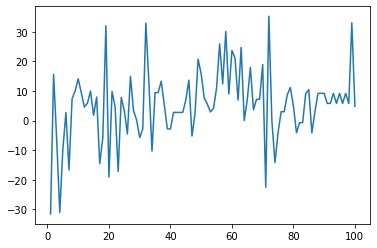

In [13]:
x = np.arange(1,len(total_pro)+1)
y = total_pro
plt.plot(x,y)
plt.show()

In [18]:
np.mean(total_pro)

5.394299621582031

In [25]:
abs(-3) * [data[0]]

[154.52999877929688, 154.52999877929688, 154.52999877929688]

In [27]:
-3 * [data[0]] + list(data[0:1+1])

[154.52999877929688, 155.9600067138672]

In [28]:
type(data)

pandas.core.series.Series